# This is from a training course from freeCodeCamp.org : https://www.youtube.com/watch?v=9Y3yaoi9rUQ

# Unsupervised Learning Trading Strategy  

Download/Load SP500 stocks prices data  
Calculate different features and indicators on each stock  
Aggregate on monthly level and filter top 150 most liquid stocks  
Calculate Monthly Returns for different time-horizons  
Download Fama-French Factors and calculate Rolling Factor Betas  
For each month fit a K-means Clustering Algorithm to group similar assets based on their features  
For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max Sharpe Ratio optimization  
Visualize portfolio returns and compare to SP500 Returns

# Packages needed:  

pandas, numpy, matplotlib, statsmodels, pandas_datareader, datetime, yfinance, sklearn, PyPortfolioOpt

In [7]:
#Installing the packages if not installed

# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install statsmodels
# !pip install pandas_datareader
# !pip install datetime
# !pip install yfinance
# # !pip install sklearn
# !pip install scikit-learn
# !pip install pandas_ta
# !pip install PyPortfolioOpt

In [1]:
#Importing all the packages

from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')


In [2]:
#Loading the SP500 data

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

#Cleaning the data to remove dots(.) from symbol names and replacing it with a dash(-)

sp500['Symbol'] = sp500['Symbol'].str.replace('.','-')

symbols_list = sp500['Symbol'].unique().tolist()

#To download the last 8 years of SP500 data from the end date

end_date = '2023-12-31'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)


df = yf.download(tickers=symbols_list,
                start=start_date,
                end=end_date)

df

[*********************100%%**********************]  503 of 503 completed


Adj Close                                                 \
                     A        AAL        AAPL        ABBV        ABNB   
Date                                                                    
2016-01-04   38.134434  39.095459   23.977480   40.778080         NaN   
2016-01-05   38.003216  38.722763   23.376619   40.608200         NaN   
2016-01-06   38.171928  39.401264   22.919144   40.615276         NaN   
2016-01-07   36.550571  38.655865   21.951851   40.494938         NaN   
2016-01-08   36.166336  38.579411   22.067932   39.390724         NaN   
...                ...        ...         ...         ...         ...   
2023-12-22  139.334351  14.310000  193.600006  154.940002  140.800003   
2023-12-26  139.573929  14.110000  193.050003  154.619995  138.720001   
2023-12-27  139.583923  13.990000  193.149994  154.880005  136.550003   
2023-12-28  139.534012  13.980000  193.580002  154.750000  137.000000   
2023-12-29  139.029999  13.740000  192.529999  154.970001  136.139999   

                                                                       ...  \
                   ABT       ACGL         ACN        ADBE         ADI  ...   
Date                                                                   ...   
2016-01-04   36.956306  22.950001   89.603119   91.970001   46.181305  ...   
2016-01-05   36.947704  23.033333   90.069466   92.339996   45.841984  ...   
2016-01-06   36.637791  23.070000   89.893486   91.019997   43.890919  ...   
2016-01-07   35.759731  23.046667   87.253700   89.110001   42.771152  ...   
2016-01-08   35.010788  22.806667   86.408974   87.849998   42.397907  ...   
...                ...        ...         ...         ...         ...  ...   
2023-12-22  109.029999  73.839996  354.450012  598.750000  197.100006  ...   
2023-12-26  109.230003  73.510002  353.429993  598.260010  198.869995  ...   
2023-12-27  109.790001  73.540001  353.820007  596.080017  199.350006  ...   
2023-12-28  110.400002  74.059998  351.589996  595.520020  200.240005  ...   
2023-12-29  110.070000  74.269997  350.910004  596.599976  198.559998  ...   

             Volume                                                          \
               WYNN      XEL       XOM     XRAY      XYL       YUM      ZBH   
Date                                                                          
2016-01-04  4249800  2819300  20400100  1387100  1353400   4821623  2104084   
2016-01-05  4286100  2141200  11993500  1611200  1075400   5273420  2294737   
2016-01-06  3316100  5191900  18826900  1179700  1866000   5049330  2751233   
2016-01-07  5525600  5212200  21263800  1140400  1555400  11005453  1829589   
2016-01-08  5740000  3005400  19033600  1233700  1471500   5996184  1670969   
...             ...      ...       ...      ...      ...       ...      ...   
2023-12-22  1170500  2429300  12921800  1261200   829300    991500  1337800   
2023-12-26  1150000  2147500  16835100  1335200   440300    627500  1870700   
2023-12-27  1142200  2865900  14558800  1202800  1007700   1050400  1058600   
2023-12-28  1233000  2421900  16329300  1152300   709100    882500   662200   
2023-12-29  1144800  2813300  17741400  1330600   698900   1196800   849600   

                                       
               ZBRA     ZION      ZTS  
Date                                   
2016-01-04   656200  3523300  2871700  
2016-01-05   611300  2653600  3116700  
2016-01-06   881900  4164200  4670500  
2016-01-07  1210600  4234000  4324400  
2016-01-08  1034700  3401600  4946100  
...             ...      ...      ...  
2023-12-22   225900  1534500  1548400  
2023-12-26   220000  1131600   814600  
2023-12-27   275700  1345100   766400  
2023-12-28   193900  1125900   880100  
2023-12-29   251300  1420600  1007200  

[2012 rows x 3018 columns]

In [3]:
df = df.stack()

df

Adj Close       Close        High         Low        Open  \
Date                                                                          
2016-01-04 A      38.134434   40.689999   41.189999   40.340000   41.060001   
           AAL    39.095459   40.910000   41.349998   40.299999   41.290001   
           AAPL   23.977480   26.337500   26.342501   25.500000   25.652500   
           ABBV   40.778080   57.610001   58.320000   56.400002   58.060001   
           ABT    36.956306   42.930000   44.049999   42.500000   43.939999   
...                     ...         ...         ...         ...         ...   
2023-12-29 YUM   130.660004  130.660004  131.250000  130.210007  130.410004   
           ZBH   121.699997  121.699997  122.400002  121.239998  121.459999   
           ZBRA  273.329987  273.329987  276.309998  272.769989  274.730011   
           ZION   43.869999   43.869999   44.650002   43.720001   44.650002   
           ZTS   197.369995  197.369995  198.009995  196.250000  196.679993   

                      Volume  
Date                          
2016-01-04 A       3287300.0  
           AAL    12037200.0  
           AAPL  270597600.0  
           ABBV   10308400.0  
           ABT    12227500.0  
...                      ...  
2023-12-29 YUM     1196800.0  
           ZBH      849600.0  
           ZBRA     251300.0  
           ZION    1420600.0  
           ZTS     1007200.0  

[994508 rows x 6 columns]

In [4]:
df.index.names = ['date','ticker']

df

Adj Close       Close        High         Low        Open  \
date       ticker                                                               
2016-01-04 A        38.134434   40.689999   41.189999   40.340000   41.060001   
           AAL      39.095459   40.910000   41.349998   40.299999   41.290001   
           AAPL     23.977480   26.337500   26.342501   25.500000   25.652500   
           ABBV     40.778080   57.610001   58.320000   56.400002   58.060001   
           ABT      36.956306   42.930000   44.049999   42.500000   43.939999   
...                       ...         ...         ...         ...         ...   
2023-12-29 YUM     130.660004  130.660004  131.250000  130.210007  130.410004   
           ZBH     121.699997  121.699997  122.400002  121.239998  121.459999   
           ZBRA    273.329987  273.329987  276.309998  272.769989  274.730011   
           ZION     43.869999   43.869999   44.650002   43.720001   44.650002   
           ZTS     197.369995  197.369995  198.009995  196.250000  196.679993   

                        Volume  
date       ticker               
2016-01-04 A         3287300.0  
           AAL      12037200.0  
           AAPL    270597600.0  
           ABBV     10308400.0  
           ABT      12227500.0  
...                        ...  
2023-12-29 YUM       1196800.0  
           ZBH        849600.0  
           ZBRA       251300.0  
           ZION      1420600.0  
           ZTS       1007200.0  

[994508 rows x 6 columns]

In [5]:
df.columns = df.columns.str.lower()

df

adj close       close        high         low        open  \
date       ticker                                                               
2016-01-04 A        38.134434   40.689999   41.189999   40.340000   41.060001   
           AAL      39.095459   40.910000   41.349998   40.299999   41.290001   
           AAPL     23.977480   26.337500   26.342501   25.500000   25.652500   
           ABBV     40.778080   57.610001   58.320000   56.400002   58.060001   
           ABT      36.956306   42.930000   44.049999   42.500000   43.939999   
...                       ...         ...         ...         ...         ...   
2023-12-29 YUM     130.660004  130.660004  131.250000  130.210007  130.410004   
           ZBH     121.699997  121.699997  122.400002  121.239998  121.459999   
           ZBRA    273.329987  273.329987  276.309998  272.769989  274.730011   
           ZION     43.869999   43.869999   44.650002   43.720001   44.650002   
           ZTS     197.369995  197.369995  198.009995  196.250000  196.679993   

                        volume  
date       ticker               
2016-01-04 A         3287300.0  
           AAL      12037200.0  
           AAPL    270597600.0  
           ABBV     10308400.0  
           ABT      12227500.0  
...                        ...  
2023-12-29 YUM       1196800.0  
           ZBH        849600.0  
           ZBRA       251300.0  
           ZION      1420600.0  
           ZTS       1007200.0  

[994508 rows x 6 columns]

# 2. Calculate features and technical indicators for each stock

Garman-Klass Volatility  
RSI  
Bollinger Bands  
ATR  
MACD  
Dollar Volume  


In [6]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2 - (2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df

adj close       close        high         low        open  \
date       ticker                                                               
2016-01-04 A        38.134434   40.689999   41.189999   40.340000   41.060001   
           AAL      39.095459   40.910000   41.349998   40.299999   41.290001   
           AAPL     23.977480   26.337500   26.342501   25.500000   25.652500   
           ABBV     40.778080   57.610001   58.320000   56.400002   58.060001   
           ABT      36.956306   42.930000   44.049999   42.500000   43.939999   
...                       ...         ...         ...         ...         ...   
2023-12-29 YUM     130.660004  130.660004  131.250000  130.210007  130.410004   
           ZBH     121.699997  121.699997  122.400002  121.239998  121.459999   
           ZBRA    273.329987  273.329987  276.309998  272.769989  274.730011   
           ZION     43.869999   43.869999   44.650002   43.720001   44.650002   
           ZTS     197.369995  197.369995  198.009995  196.250000  196.679993   

                        volume  german_klass_vol  
date       ticker                                 
2016-01-04 A         3287300.0         -0.001893  
           AAL      12037200.0         -0.000821  
           AAPL    270597600.0         -0.001233  
           ABBV     10308400.0         -0.047666  
           ABT      12227500.0         -0.010932  
...                        ...               ...  
2023-12-29 YUM       1196800.0          0.000030  
           ZBH        849600.0          0.000044  
           ZBRA       251300.0          0.000073  
           ZION      1420600.0          0.000102  
           ZTS       1007200.0          0.000035  

[994508 rows x 7 columns]

In [7]:
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df

adj close       close        high         low        open  \
date       ticker                                                               
2016-01-04 A        38.134434   40.689999   41.189999   40.340000   41.060001   
           AAL      39.095459   40.910000   41.349998   40.299999   41.290001   
           AAPL     23.977480   26.337500   26.342501   25.500000   25.652500   
           ABBV     40.778080   57.610001   58.320000   56.400002   58.060001   
           ABT      36.956306   42.930000   44.049999   42.500000   43.939999   
...                       ...         ...         ...         ...         ...   
2023-12-29 YUM     130.660004  130.660004  131.250000  130.210007  130.410004   
           ZBH     121.699997  121.699997  122.400002  121.239998  121.459999   
           ZBRA    273.329987  273.329987  276.309998  272.769989  274.730011   
           ZION     43.869999   43.869999   44.650002   43.720001   44.650002   
           ZTS     197.369995  197.369995  198.009995  196.250000  196.679993   

                        volume  german_klass_vol        rsi  
date       ticker                                            
2016-01-04 A         3287300.0         -0.001893        NaN  
           AAL      12037200.0         -0.000821        NaN  
           AAPL    270597600.0         -0.001233        NaN  
           ABBV     10308400.0         -0.047666        NaN  
           ABT      12227500.0         -0.010932        NaN  
...                        ...               ...        ...  
2023-12-29 YUM       1196800.0          0.000030  59.338371  
           ZBH        849600.0          0.000044  68.767246  
           ZBRA       251300.0          0.000073  67.914673  
           ZION      1420600.0          0.000102  62.879829  
           ZTS       1007200.0          0.000035  66.791335  

[994508 rows x 8 columns]

In [8]:
df.xs('AAPL',level=1)['rsi'].plot()

<Axes: xlabel='date'>

In [9]:
#Bollinger bounds

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])

df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])

df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

df

adj close       close        high         low        open  \
date       ticker                                                               
2016-01-04 A        38.134434   40.689999   41.189999   40.340000   41.060001   
           AAL      39.095459   40.910000   41.349998   40.299999   41.290001   
           AAPL     23.977480   26.337500   26.342501   25.500000   25.652500   
           ABBV     40.778080   57.610001   58.320000   56.400002   58.060001   
           ABT      36.956306   42.930000   44.049999   42.500000   43.939999   
...                       ...         ...         ...         ...         ...   
2023-12-29 YUM     130.660004  130.660004  131.250000  130.210007  130.410004   
           ZBH     121.699997  121.699997  122.400002  121.239998  121.459999   
           ZBRA    273.329987  273.329987  276.309998  272.769989  274.730011   
           ZION     43.869999   43.869999   44.650002   43.720001   44.650002   
           ZTS     197.369995  197.369995  198.009995  196.250000  196.679993   

                        volume  german_klass_vol        rsi    bb_low  \
date       ticker                                                       
2016-01-04 A         3287300.0         -0.001893        NaN       NaN   
           AAL      12037200.0         -0.000821        NaN       NaN   
           AAPL    270597600.0         -0.001233        NaN       NaN   
           ABBV     10308400.0         -0.047666        NaN       NaN   
           ABT      12227500.0         -0.010932        NaN       NaN   
...                        ...               ...        ...       ...   
2023-12-29 YUM       1196800.0          0.000030  59.338371  4.824633   
           ZBH        849600.0          0.000044  68.767246  4.753563   
           ZBRA       251300.0          0.000073  67.914673  5.415905   
           ZION      1420600.0          0.000102  62.879829  3.611585   
           ZTS       1007200.0          0.000035  66.791335  5.186448   

                     bb_mid   bb_high  
date       ticker                      
2016-01-04 A            NaN       NaN  
           AAL          NaN       NaN  
           AAPL         NaN       NaN  
           ABBV         NaN       NaN  
           ABT          NaN       NaN  
...                     ...       ...  
2023-12-29 YUM     4.862793  4.900952  
           ZBH     4.784470  4.815377  
           ZBRA    5.546306  5.676707  
           ZION    3.749483  3.887381  
           ZTS     5.259449  5.332449  

[994508 rows x 11 columns]

In [10]:
#For ATR

# pandas_ta.atr(high=df['high'],
#              low=df['low'],
#              close=df['close'],
#              length=14)

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                      low=stock_data['low'],
                      close=stock_data['close'],
                      length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

df

adj close       close        high         low        open  \
date       ticker                                                               
2016-01-04 A        38.134434   40.689999   41.189999   40.340000   41.060001   
           AAL      39.095459   40.910000   41.349998   40.299999   41.290001   
           AAPL     23.977480   26.337500   26.342501   25.500000   25.652500   
           ABBV     40.778080   57.610001   58.320000   56.400002   58.060001   
           ABT      36.956306   42.930000   44.049999   42.500000   43.939999   
...                       ...         ...         ...         ...         ...   
2023-12-29 YUM     130.660004  130.660004  131.250000  130.210007  130.410004   
           ZBH     121.699997  121.699997  122.400002  121.239998  121.459999   
           ZBRA    273.329987  273.329987  276.309998  272.769989  274.730011   
           ZION     43.869999   43.869999   44.650002   43.720001   44.650002   
           ZTS     197.369995  197.369995  198.009995  196.250000  196.679993   

                        volume  german_klass_vol        rsi    bb_low  \
date       ticker                                                       
2016-01-04 A         3287300.0         -0.001893        NaN       NaN   
           AAL      12037200.0         -0.000821        NaN       NaN   
           AAPL    270597600.0         -0.001233        NaN       NaN   
           ABBV     10308400.0         -0.047666        NaN       NaN   
           ABT      12227500.0         -0.010932        NaN       NaN   
...                        ...               ...        ...       ...   
2023-12-29 YUM       1196800.0          0.000030  59.338371  4.824633   
           ZBH        849600.0          0.000044  68.767246  4.753563   
           ZBRA       251300.0          0.000073  67.914673  5.415905   
           ZION      1420600.0          0.000102  62.879829  3.611585   
           ZTS       1007200.0          0.000035  66.791335  5.186448   

                     bb_mid   bb_high       atr  
date       ticker                                
2016-01-04 A            NaN       NaN       NaN  
           AAL          NaN       NaN       NaN  
           AAPL         NaN       NaN       NaN  
           ABBV         NaN       NaN       NaN  
           ABT          NaN       NaN       NaN  
...                     ...       ...       ...  
2023-12-29 YUM     4.862793  4.900952 -0.073239  
           ZBH     4.784470  4.815377 -1.054422  
           ZBRA    5.546306  5.676707 -0.154931  
           ZION    3.749483  3.887381  0.177122  
           ZTS     5.259449  5.332449  0.420520  

[994508 rows x 12 columns]

In [11]:
#For MACD

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df

adj close       close        high         low        open  \
date       ticker                                                               
2016-01-04 A        38.134434   40.689999   41.189999   40.340000   41.060001   
           AAL      39.095459   40.910000   41.349998   40.299999   41.290001   
           AAPL     23.977480   26.337500   26.342501   25.500000   25.652500   
           ABBV     40.778080   57.610001   58.320000   56.400002   58.060001   
           ABT      36.956306   42.930000   44.049999   42.500000   43.939999   
...                       ...         ...         ...         ...         ...   
2023-12-29 YUM     130.660004  130.660004  131.250000  130.210007  130.410004   
           ZBH     121.699997  121.699997  122.400002  121.239998  121.459999   
           ZBRA    273.329987  273.329987  276.309998  272.769989  274.730011   
           ZION     43.869999   43.869999   44.650002   43.720001   44.650002   
           ZTS     197.369995  197.369995  198.009995  196.250000  196.679993   

                        volume  german_klass_vol        rsi    bb_low  \
date       ticker                                                       
2016-01-04 A         3287300.0         -0.001893        NaN       NaN   
           AAL      12037200.0         -0.000821        NaN       NaN   
           AAPL    270597600.0         -0.001233        NaN       NaN   
           ABBV     10308400.0         -0.047666        NaN       NaN   
           ABT      12227500.0         -0.010932        NaN       NaN   
...                        ...               ...        ...       ...   
2023-12-29 YUM       1196800.0          0.000030  59.338371  4.824633   
           ZBH        849600.0          0.000044  68.767246  4.753563   
           ZBRA       251300.0          0.000073  67.914673  5.415905   
           ZION      1420600.0          0.000102  62.879829  3.611585   
           ZTS       1007200.0          0.000035  66.791335  5.186448   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2016-01-04 A            NaN       NaN       NaN       NaN  
           AAL          NaN       NaN       NaN       NaN  
           AAPL         NaN       NaN       NaN       NaN  
           ABBV         NaN       NaN       NaN       NaN  
           ABT          NaN       NaN       NaN       NaN  
...                     ...       ...       ...       ...  
2023-12-29 YUM     4.862793  4.900952 -0.073239  0.784240  
           ZBH     4.784470  4.815377 -1.054422  0.973531  
           ZBRA    5.546306  5.676707 -0.154931  1.577769  
           ZION    3.749483  3.887381  0.177122  2.099563  
           ZTS     5.259449  5.332449  0.420520  2.164720  

[994508 rows x 13 columns]

In [12]:
#For dollar volume

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df

adj close       close        high         low        open  \
date       ticker                                                               
2016-01-04 A        38.134434   40.689999   41.189999   40.340000   41.060001   
           AAL      39.095459   40.910000   41.349998   40.299999   41.290001   
           AAPL     23.977480   26.337500   26.342501   25.500000   25.652500   
           ABBV     40.778080   57.610001   58.320000   56.400002   58.060001   
           ABT      36.956306   42.930000   44.049999   42.500000   43.939999   
...                       ...         ...         ...         ...         ...   
2023-12-29 YUM     130.660004  130.660004  131.250000  130.210007  130.410004   
           ZBH     121.699997  121.699997  122.400002  121.239998  121.459999   
           ZBRA    273.329987  273.329987  276.309998  272.769989  274.730011   
           ZION     43.869999   43.869999   44.650002   43.720001   44.650002   
           ZTS     197.369995  197.369995  198.009995  196.250000  196.679993   

                        volume  german_klass_vol        rsi    bb_low  \
date       ticker                                                       
2016-01-04 A         3287300.0         -0.001893        NaN       NaN   
           AAL      12037200.0         -0.000821        NaN       NaN   
           AAPL    270597600.0         -0.001233        NaN       NaN   
           ABBV     10308400.0         -0.047666        NaN       NaN   
           ABT      12227500.0         -0.010932        NaN       NaN   
...                        ...               ...        ...       ...   
2023-12-29 YUM       1196800.0          0.000030  59.338371  4.824633   
           ZBH        849600.0          0.000044  68.767246  4.753563   
           ZBRA       251300.0          0.000073  67.914673  5.415905   
           ZION      1420600.0          0.000102  62.879829  3.611585   
           ZTS       1007200.0          0.000035  66.791335  5.186448   

                     bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2016-01-04 A            NaN       NaN       NaN       NaN     125.359324  
           AAL          NaN       NaN       NaN       NaN     470.599859  
           AAPL         NaN       NaN       NaN       NaN    6488.248524  
           ABBV         NaN       NaN       NaN       NaN     420.356760  
           ABT          NaN       NaN       NaN       NaN     451.883237  
...                     ...       ...       ...       ...            ...  
2023-12-29 YUM     4.862793  4.900952 -0.073239  0.784240     156.373892  
           ZBH     4.784470  4.815377 -1.054422  0.973531     103.396317  
           ZBRA    5.546306  5.676707 -0.154931  1.577769      68.687826  
           ZION    3.749483  3.887381  0.177122  2.099563      62.321720  
           ZTS     5.259449  5.332449  0.420520  2.164720     198.791059  

[994508 rows x 14 columns]

# 3. Aggregate to monthly level and filter top 150 most liquid stocks for each month.

To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.

In [13]:
#To just get the dollar volumes, unstack it first by the ticker
df.unstack('ticker')['dollar_volume']

ticker               A         AAL         AAPL        ABBV        ABNB  \
date                                                                      
2016-01-04  125.359324  470.599859  6488.248524  420.356760         NaN   
2016-01-05   98.321920  407.138875  5216.819878  291.550633         NaN   
2016-01-06   80.298469  488.331388  6275.939945  363.616384         NaN   
2016-01-07  128.084168  437.309932  7120.688708  376.303260         NaN   
2016-01-08  135.142748  341.547380  6249.461835  314.542811         NaN   
...                ...         ...          ...         ...         ...   
2023-12-22  167.772492  360.181280  7186.974307  522.581640  413.402889   
2023-12-26  132.371914  312.647961  5582.870953  320.589098  608.259461   
2023-12-27  165.030073  327.764710  9288.138961  580.397330  544.779892   
2023-12-28  124.548059  238.965724  6591.379704  402.535700  379.599600   
2023-12-29  141.032031  333.085074  8207.322812  575.155663  418.507972   

ticker             ABT       ACGL         ACN         ADBE         ADI  ...  \
date                                                                    ...   
2016-01-04  451.883237  28.015066  252.411986   275.339790  122.329659  ...   
2016-01-05  304.641212  34.494719  216.977343   168.178835  123.292015  ...   
2016-01-06  216.382792  46.439909  281.744164   152.367474  165.894506  ...   
2016-01-07  255.732142  32.682479  278.749396   242.183160  220.827460  ...   
2016-01-08  261.800169  30.180063  201.350191   198.839687  161.332517  ...   
...                ...        ...         ...          ...         ...  ...   
2023-12-22  279.738268  96.243051  820.161883   993.805250  345.831671  ...   
2023-12-26  274.538690  85.168688  542.762440   954.284542  319.564195  ...   
2023-12-27  271.378924  69.921833  463.398064   831.472016  328.150045  ...   
2023-12-28  353.953445  98.973781  457.348267  1013.932385  443.631732  ...   
2023-12-29  390.770513  98.949917  432.847490  1129.900694  306.258940  ...   

ticker            WYNN         XEL          XOM       XRAY         XYL  \
date                                                                     
2016-01-04  262.640620   79.266867  1093.190779  75.943656   44.191682   
2016-01-05  269.891242   60.808633   648.178071  90.011535   35.104575   
2016-01-06  197.993854  149.000265  1009.017027  64.950629   60.152440   
2016-01-07  298.880948  150.157485  1121.380331  62.235278   48.844894   
2016-01-08  297.840035   85.635362   983.488948  65.399108   45.770681   
...                ...         ...          ...        ...         ...   
2023-12-22  105.836608  149.502979  1316.860685  44.244929   93.412351   
2023-12-26  104.650000  132.565174  1719.537104  47.266556   50.026887   
2023-12-27  103.517583  176.367489  1480.047661  42.687374  115.260723   
2023-12-28  113.140083  149.891390  1636.032607  41.010357   81.064312   
2023-12-29  104.302729  174.171403  1773.785232  47.356054   79.926204   

ticker             YUM         ZBH       ZBRA       ZION         ZTS  
date                                                                  
2016-01-04  215.914865  195.298636  43.630737  76.614155  128.425232  
2016-01-05  235.557949  217.430025  39.624466  57.076036  141.563837  
2016-01-06  223.951145  261.812464  54.880637  86.956991  212.183293  
2016-01-07  471.467983  170.103815  71.921746  85.760401  190.486600  
2016-01-08  253.378117  154.701309  61.305975  68.124597  214.690030  
...                ...         ...        ...        ...         ...  
2023-12-22  128.895000  160.964085  60.859720  67.518000  301.907025  
2023-12-26   81.738147  227.140391  60.610000  50.786209  159.254300  
2023-12-27  137.434332  128.228215  76.035305  59.870399  150.904155  
2023-12-28  115.183904   80.543384  53.390366  50.282694  173.520519  
2023-12-29  156.373892  103.396317  68.687826  62.321720  198.791059  

[2012 rows x 503 columns]

In [14]:
#To resample monthly and take the mean
df.unstack('ticker')['dollar_volume'].resample('M').mean()

ticker               A         AAL          AAPL        ABBV         ABNB  \
date                                                                        
2016-01-31   95.208711  475.458004   5981.206900  460.247938          NaN   
2016-02-29   91.918053  338.977802   3548.073564  357.006434          NaN   
2016-03-31   62.013609  298.909269   3235.327858  258.633286          NaN   
2016-04-30   63.234641  362.444592   3975.921259  288.612740          NaN   
2016-05-31  104.726085  304.648988   3742.350752  435.935832          NaN   
...                ...         ...           ...         ...          ...   
2023-08-31  223.626262  345.748578  10384.671266  576.661721   633.134438   
2023-09-30  225.452664  359.415270  11802.970459  636.106464  1474.245625   
2023-10-31  230.270452  511.970157   9288.649985  732.289657   607.690932   
2023-11-30  255.382940  383.225710   9676.940498  740.479255   725.681927   
2023-12-31  236.540083  464.680047  10349.452048  834.666881   733.953895   

ticker             ABT        ACGL         ACN         ADBE         ADI  ...  \
date                                                                     ...   
2016-01-31  326.006446   38.398516  309.260826   300.002638  151.880584  ...   
2016-02-29  245.865725   31.542992  312.497804   379.902608  113.555353  ...   
2016-03-31  230.348671   19.681929  297.120387   378.267646  101.951479  ...   
2016-04-30  311.348734   25.113596  239.114573   233.672570   83.940266  ...   
2016-05-31  400.755892   25.422941  186.575855   193.159803   91.842493  ...   
...                ...         ...         ...          ...         ...  ...   
2023-08-31  438.548193  118.491397  488.369221  1171.830154  613.874720  ...   
2023-09-30  437.996230  122.295319  680.277187  1682.014217  557.926648  ...   
2023-10-31  660.120377  154.133369  567.452103  1359.971110  530.336573  ...   
2023-11-30  600.580409  186.830789  574.901374  1497.060182  590.500074  ...   
2023-12-31  519.336398  139.557395  750.208617  2129.573076  581.020044  ...   

ticker            WYNN         XEL          XOM        XRAY         XYL  \
date                                                                      
2016-01-31  256.464901  115.671625  1161.208791   75.293763   42.733521   
2016-02-29  299.426586  142.168392  1003.647675  141.594549   65.787643   
2016-03-31  307.705470  104.878266   772.885034  152.381615   50.989450   
2016-04-30  358.875728  110.043428   630.806438   63.282503   48.763614   
2016-05-31  214.782919   98.436247   654.031928   90.882036   50.042893   
...                ...         ...          ...         ...         ...   
2023-08-31  211.420244  232.395590  1472.936105   49.314294  141.440107   
2023-09-30  177.905894  290.911285  1849.589699   58.825895  169.693071   
2023-10-31  151.880597  231.375996  2429.285783  102.344373  136.248706   
2023-11-30  275.233217  229.431757  2147.974068  139.395045  141.952778   
2023-12-31  166.428190  268.517624  2283.579811   87.708715  141.442060   

ticker             YUM         ZBH        ZBRA        ZION         ZTS  
date                                                                    
2016-01-31  275.987932  164.399437   53.680463   89.613792  187.407275  
2016-02-29  334.423694  133.118296   53.713541   70.743879  184.782994  
2016-03-31  219.294085  119.219443   35.659440   65.145137  194.946082  
2016-04-30  226.652492  159.701153   36.822120   61.559293  169.779518  
2016-05-31  184.070651  142.575987   52.217700   60.909760  189.990259  
...                ...         ...         ...         ...         ...  
2023-08-31  191.616515  222.739660  147.578104   84.538446  325.628945  
2023-09-30  188.819258  202.585662  105.890261  100.220668  280.971896  
2023-10-31  198.582746  167.953399  110.835386  114.220695  282.646901  
2023-11-30  174.440695  213.723556  103.015525   69.506168  380.626902  
2023-12-31  207.539266  207.682671   98.037275  102.724363  335.154638  

[96 rows x 503 columns]

In [15]:
#To put the mean of the monthly sampled dollar_volume back into the stacking
df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume')

dollar_volume
date       ticker               
2016-01-31 A           95.208711
           AAL        475.458004
           AAPL      5981.206900
           ABBV       460.247938
           ABT        326.006446
...                          ...
2023-12-31 YUM        207.539266
           ZBH        207.682671
           ZBRA        98.037275
           ZION       102.724363
           ZTS        335.154638

[47458 rows x 1 columns]

In [16]:
#To do the monthly resampling of the technical indicator columns

#Create the list of columns to do that operation on
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                         'high', 'low', 'close']]
last_cols

['adj close',
 'german_klass_vol',
 'rsi',
 'bb_low',
 'bb_mid',
 'bb_high',
 'atr',
 'macd']

In [17]:
#After doing the monthly resampling need to take the last value of the month
df.unstack()[last_cols].resample('M').last()

adj close                                                 \
ticker               A        AAL        AAPL        ABBV        ABNB   
date                                                                    
2016-01-31   35.285362  37.260616   22.154415   39.267998         NaN   
2016-02-29   35.004200  39.288376   22.125885   39.060581         NaN   
2016-03-31   37.347195  39.297955   24.940533   40.855888         NaN   
2016-04-30   38.460979  33.241802   21.450827   44.050358         NaN   
2016-05-31   43.132313  30.666256   22.990419   45.444080         NaN   
...                ...        ...         ...         ...         ...   
2023-08-31  120.622383  14.730000  187.622818  145.503586  131.550003   
2023-09-30  111.406578  12.810000  170.984741  147.582764  137.210007   
2023-10-31  103.195465  11.150000  170.545319  141.179993  118.290001   
2023-11-30  127.584213  12.430000  189.949997  142.389999  126.339996   
2023-12-31  139.029999  13.740000  192.529999  154.970001  136.139999   

                                                                       ...  \
ticker             ABT       ACGL         ACN        ADBE         ADI  ...   
date                                                                   ...   
2016-01-31   32.788803  22.516666   92.867630   89.129997   45.689301  ...   
2016-02-29   33.559799  22.646667   88.221626   85.150002   45.321178  ...   
2016-03-31   36.236618  23.700001  101.543739   93.800003   50.623894  ...   
2016-04-30   33.904270  23.496668  100.326263   94.220001   48.169243  ...   
2016-05-31   34.540524  24.219999  105.701523   99.470001   50.397320  ...   
...                ...        ...         ...         ...         ...  ...   
2023-08-31  102.333519  76.860001  322.432709  559.340027  180.071533  ...   
2023-09-30   96.316818  79.709999  305.841522  509.899994  174.268875  ...   
2023-10-31   94.550003  86.680000  297.089996  532.059998  156.592178  ...   
2023-11-30  104.290001  83.690002  333.140015  611.010010  182.520004  ...   
2023-12-31  110.070000  74.269997  350.910004  596.599976  198.559998  ...   

                macd                                                    \
ticker          WYNN       XEL       XOM      XRAY       XYL       YUM   
date                                                                     
2016-01-31       NaN       NaN       NaN       NaN       NaN       NaN   
2016-02-29  1.560842  0.667695  0.730913  0.606775  0.320138  0.071168   
2016-03-31  1.304119  0.611488  0.400749  0.645770  0.380174  0.773180   
2016-04-30 -0.017237 -0.448789  0.651139  0.075146  0.237622  0.051633   
2016-05-31  0.211674 -0.064363  0.432009  0.403566  0.305965 -0.041422   
...              ...       ...       ...       ...       ...       ...   
2023-08-31 -0.526279 -1.841771  0.821789 -0.550694 -1.160481 -1.230850   
2023-09-30 -0.636219 -0.330920  1.557012 -0.890899 -2.010615 -1.442686   
2023-10-31 -0.504859  0.286232 -1.530449 -0.923593 -0.809025 -1.086674   
2023-11-30 -0.446053  0.417135 -1.051462  0.224266  1.585253  0.601788   
2023-12-31  0.322582  0.515482 -0.683288  1.294743  1.965728  0.784240   

                                                    
ticker           ZBH      ZBRA      ZION       ZTS  
date                                                
2016-01-31       NaN       NaN       NaN       NaN  
2016-02-29 -0.442506  0.073515 -0.371834 -0.445664  
2016-03-31  0.747376  0.101511  0.314801 -0.035502  
2016-04-30  1.065937 -0.183658  0.649084  0.197638  
2016-05-31  0.917649 -0.455315  0.358426 -0.155236  
...              ...       ...       ...       ...  
2023-08-31 -1.789548 -0.283424  0.062546  0.809985  
2023-09-30 -1.177806 -1.427583 -0.313357 -1.461055  
2023-10-31 -1.264939 -1.186609 -1.218675 -2.598289  
2023-11-30  0.729316  0.608557  0.505899  0.916313  
2023-12-31  0.973531  1.577769  2.099563  2.164720  

[96 rows x 4024 columns]

In [18]:
#Stack it back
df.unstack()[last_cols].resample('M').last().stack('ticker')

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2016-01-31 A        35.285362 -0.838231       NaN       NaN       NaN   
           AAL      37.260616  2.408200       NaN       NaN       NaN   
           AAPL     22.154415 -0.807900       NaN       NaN       NaN   
           ABBV     39.267998  0.506051       NaN       NaN       NaN   
           ABT      32.788803 -0.360394       NaN       NaN       NaN   
...                       ...       ...       ...       ...       ...   
2023-12-31 YUM     130.660004 -0.073239  4.900952  4.824633  4.862793   
           ZBH     121.699997 -1.054422  4.815377  4.753563  4.784470   
           ZBRA    273.329987 -0.154931  5.676707  5.415905  5.546306   
           ZION     43.869999  0.177122  3.887381  3.611585  3.749483   
           ZTS     197.369995  0.420520  5.332449  5.186448  5.259449   

                   german_klass_vol      macd        rsi  
date       ticker                                         
2016-01-31 A               0.000295       NaN        NaN  
           AAL             0.002147       NaN        NaN  
           AAPL           -0.001265       NaN        NaN  
           ABBV           -0.035988       NaN        NaN  
           ABT            -0.004372       NaN        NaN  
...                             ...       ...        ...  
2023-12-31 YUM             0.000030  0.784240  59.338371  
           ZBH             0.000044  0.973531  68.767246  
           ZBRA            0.000073  1.577769  67.914673  
           ZION            0.000102  2.099563  62.879829  
           ZTS             0.000035  2.164720  66.791335  

[47458 rows x 8 columns]

In [19]:
#Join the monthly avg dollar volume and the monthly tech. indicators
pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'), 
           df.unstack()[last_cols].resample('M').last().stack('ticker')],
         axis=1)

dollar_volume   adj close       atr   bb_high    bb_low  \
date       ticker                                                            
2016-01-31 A           95.208711   35.285362 -0.838231       NaN       NaN   
           AAL        475.458004   37.260616  2.408200       NaN       NaN   
           AAPL      5981.206900   22.154415 -0.807900       NaN       NaN   
           ABBV       460.247938   39.267998  0.506051       NaN       NaN   
           ABT        326.006446   32.788803 -0.360394       NaN       NaN   
...                          ...         ...       ...       ...       ...   
2023-12-31 YUM        207.539266  130.660004 -0.073239  4.900952  4.824633   
           ZBH        207.682671  121.699997 -1.054422  4.815377  4.753563   
           ZBRA        98.037275  273.329987 -0.154931  5.676707  5.415905   
           ZION       102.724363   43.869999  0.177122  3.887381  3.611585   
           ZTS        335.154638  197.369995  0.420520  5.332449  5.186448   

                     bb_mid  german_klass_vol      macd        rsi  
date       ticker                                                   
2016-01-31 A            NaN          0.000295       NaN        NaN  
           AAL          NaN          0.002147       NaN        NaN  
           AAPL         NaN         -0.001265       NaN        NaN  
           ABBV         NaN         -0.035988       NaN        NaN  
           ABT          NaN         -0.004372       NaN        NaN  
...                     ...               ...       ...        ...  
2023-12-31 YUM     4.862793          0.000030  0.784240  59.338371  
           ZBH     4.784470          0.000044  0.973531  68.767246  
           ZBRA    5.546306          0.000073  1.577769  67.914673  
           ZION    3.749483          0.000102  2.099563  62.879829  
           ZTS     5.259449          0.000035  2.164720  66.791335  

[47458 rows x 9 columns]

In [20]:
#Drop the NaN values and call that data

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'), 
           df.unstack()[last_cols].resample('M').last().stack('ticker')],
         axis=1)).dropna()
data

dollar_volume   adj close       atr   bb_high    bb_low  \
date       ticker                                                            
2016-02-29 A           91.918053   35.004200 -0.932886  3.620122  3.522493   
           AAL        338.977802   39.288376  0.977081  3.729458  3.547833   
           AAPL      3548.073564   22.125885 -1.017466  3.155194  3.106253   
           ABBV       357.006434   39.060581 -0.477602  3.734669  3.638599   
           ABT        245.865725   33.559799 -0.797320  3.570935  3.483742   
...                          ...         ...       ...       ...       ...   
2023-12-31 YUM        207.539266  130.660004 -0.073239  4.900952  4.824633   
           ZBH        207.682671  121.699997 -1.054422  4.815377  4.753563   
           ZBRA        98.037275  273.329987 -0.154931  5.676707  5.415905   
           ZION       102.724363   43.869999  0.177122  3.887381  3.611585   
           ZTS        335.154638  197.369995  0.420520  5.332449  5.186448   

                     bb_mid  german_klass_vol      macd        rsi  
date       ticker                                                   
2016-02-29 A       3.571307         -0.001914 -0.240045  48.107895  
           AAL     3.638645         -0.000319  0.529241  56.664376  
           AAPL    3.130723         -0.003013 -0.330067  48.335941  
           ABBV    3.686634         -0.049101 -0.288564  47.896440  
           ABT     3.527338         -0.009363 -0.394515  47.034984  
...                     ...               ...       ...        ...  
2023-12-31 YUM     4.862793          0.000030  0.784240  59.338371  
           ZBH     4.784470          0.000044  0.973531  68.767246  
           ZBRA    5.546306          0.000073  1.577769  67.914673  
           ZION    3.749483          0.000102  2.099563  62.879829  
           ZTS     5.259449          0.000035  2.164720  66.791335  

[46953 rows x 9 columns]

Calculate 5yr rolling average of dollar volume for each stocks before filtering the top 150 for each mmonth

In [21]:
data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean()

ticker               A         AAL          AAPL        ABBV        ABNB  \
date                                                                       
2016-02-29         NaN         NaN           NaN         NaN         NaN   
2016-03-31         NaN         NaN           NaN         NaN         NaN   
2016-04-30         NaN         NaN           NaN         NaN         NaN   
2016-05-31         NaN         NaN           NaN         NaN         NaN   
2016-06-30         NaN         NaN           NaN         NaN         NaN   
...                ...         ...           ...         ...         ...   
2023-08-31  195.397069  563.839976  11011.623335  706.828238  886.680471   
2023-09-30  197.060645  565.745959  11082.097332  711.091311  904.485476   
2023-10-31  197.896201  567.794335  11116.462389  716.418187  895.756225   
2023-11-30  198.965423  568.890078  11137.166556  719.872015  890.896959   
2023-12-31  199.969662  571.857403  11186.181872  726.122008  886.537429   

ticker             ABT       ACGL         ACN         ADBE         ADI  ...  \
date                                                                    ...   
2016-02-29         NaN        NaN         NaN          NaN         NaN  ...   
2016-03-31         NaN        NaN         NaN          NaN         NaN  ...   
2016-04-30         NaN        NaN         NaN          NaN         NaN  ...   
2016-05-31         NaN        NaN         NaN          NaN         NaN  ...   
2016-06-30         NaN        NaN         NaN          NaN         NaN  ...   
...                ...        ...         ...          ...         ...  ...   
2023-08-31  538.080426  82.330530  523.470496  1181.508270  434.990197  ...   
2023-09-30  539.295083  83.786966  529.152441  1195.379019  439.558732  ...   
2023-10-31  541.861092  85.880223  532.775231  1198.646135  443.209902  ...   
2023-11-30  544.944113  88.497428  536.669357  1208.260648  448.662613  ...   
2023-12-31  545.429942  90.256824  542.013371  1224.294074  454.647296  ...   

ticker            WYNN         XEL          XOM       XRAY         XYL  \
date                                                                     
2016-02-29         NaN         NaN          NaN        NaN         NaN   
2016-03-31         NaN         NaN          NaN        NaN         NaN   
2016-04-30         NaN         NaN          NaN        NaN         NaN   
2016-05-31         NaN         NaN          NaN        NaN         NaN   
2016-06-30         NaN         NaN          NaN        NaN         NaN   
...                ...         ...          ...        ...         ...   
2023-08-31  298.812098  188.076974  1308.393839  81.706109   99.037238   
2023-09-30  295.622152  190.507883  1326.453223  80.836079  100.765396   
2023-10-31  293.305009  191.954024  1353.083440  81.031546  101.646379   
2023-11-30  291.798558  191.834747  1374.931539  81.445759  102.830177   
2023-12-31  289.187717  192.431925  1394.219942  81.330661  104.036979   

ticker             YUM         ZBH        ZBRA       ZION         ZTS  
date                                                                   
2016-02-29         NaN         NaN         NaN        NaN         NaN  
2016-03-31         NaN         NaN         NaN        NaN         NaN  
2016-04-30         NaN         NaN         NaN        NaN         NaN  
2016-05-31         NaN         NaN         NaN        NaN         NaN  
2016-06-30         NaN         NaN         NaN        NaN         NaN  
...                ...         ...         ...        ...         ...  
2023-08-31  185.706840  169.374048  123.219053  88.039028  295.726461  
2023-09-30  186.657852  170.605802  124.053116  88.381886  297.435067  
2023-10-31  187.282133  171.041546  124.607920  88.223142  298.691703  
2023-11-30  187.072448  172.625168  124.916334  87.684269  301.421072  
2023-12-31  186.768183  173.326863  125.211179  87.530986  303.789784  

[95 rows x 503 columns]

In [22]:
data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack()

date        ticker
2017-01-31  A           85.176255
            AAL        318.213376
            AAPL      3455.795279
            ABBV       343.019702
            ABT        324.072441
                         ...     
2023-12-31  YUM        186.768183
            ZBH        173.326863
            ZBRA       125.211179
            ZION        87.530986
            ZTS        303.789784
Length: 41433, dtype: float64

In [23]:
#Update the dollar_volume column with the rolling average

data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data

dollar_volume   adj close       atr   bb_high    bb_low  \
date       ticker                                                            
2016-02-29 A                 NaN   35.004200 -0.932886  3.620122  3.522493   
           AAL               NaN   39.288376  0.977081  3.729458  3.547833   
           AAPL              NaN   22.125885 -1.017466  3.155194  3.106253   
           ABBV              NaN   39.060581 -0.477602  3.734669  3.638599   
           ABT               NaN   33.559799 -0.797320  3.570935  3.483742   
...                          ...         ...       ...       ...       ...   
2023-12-31 YUM        186.768183  130.660004 -0.073239  4.900952  4.824633   
           ZBH        173.326863  121.699997 -1.054422  4.815377  4.753563   
           ZBRA       125.211179  273.329987 -0.154931  5.676707  5.415905   
           ZION        87.530986   43.869999  0.177122  3.887381  3.611585   
           ZTS        303.789784  197.369995  0.420520  5.332449  5.186448   

                     bb_mid  german_klass_vol      macd        rsi  
date       ticker                                                   
2016-02-29 A       3.571307         -0.001914 -0.240045  48.107895  
           AAL     3.638645         -0.000319  0.529241  56.664376  
           AAPL    3.130723         -0.003013 -0.330067  48.335941  
           ABBV    3.686634         -0.049101 -0.288564  47.896440  
           ABT     3.527338         -0.009363 -0.394515  47.034984  
...                     ...               ...       ...        ...  
2023-12-31 YUM     4.862793          0.000030  0.784240  59.338371  
           ZBH     4.784470          0.000044  0.973531  68.767246  
           ZBRA    5.546306          0.000073  1.577769  67.914673  
           ZION    3.749483          0.000102  2.099563  62.879829  
           ZTS     5.259449          0.000035  2.164720  66.791335  

[46953 rows x 9 columns]

In [24]:
#Calculate dollar volume rank cross-sectionally for each month

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data

dollar_volume   adj close       atr   bb_high    bb_low  \
date       ticker                                                            
2016-02-29 A                 NaN   35.004200 -0.932886  3.620122  3.522493   
           AAL               NaN   39.288376  0.977081  3.729458  3.547833   
           AAPL              NaN   22.125885 -1.017466  3.155194  3.106253   
           ABBV              NaN   39.060581 -0.477602  3.734669  3.638599   
           ABT               NaN   33.559799 -0.797320  3.570935  3.483742   
...                          ...         ...       ...       ...       ...   
2023-12-31 YUM        186.768183  130.660004 -0.073239  4.900952  4.824633   
           ZBH        173.326863  121.699997 -1.054422  4.815377  4.753563   
           ZBRA       125.211179  273.329987 -0.154931  5.676707  5.415905   
           ZION        87.530986   43.869999  0.177122  3.887381  3.611585   
           ZTS        303.789784  197.369995  0.420520  5.332449  5.186448   

                     bb_mid  german_klass_vol      macd        rsi  \
date       ticker                                                    
2016-02-29 A       3.571307         -0.001914 -0.240045  48.107895   
           AAL     3.638645         -0.000319  0.529241  56.664376   
           AAPL    3.130723         -0.003013 -0.330067  48.335941   
           ABBV    3.686634         -0.049101 -0.288564  47.896440   
           ABT     3.527338         -0.009363 -0.394515  47.034984   
...                     ...               ...       ...        ...   
2023-12-31 YUM     4.862793          0.000030  0.784240  59.338371   
           ZBH     4.784470          0.000044  0.973531  68.767246   
           ZBRA    5.546306          0.000073  1.577769  67.914673   
           ZION    3.749483          0.000102  2.099563  62.879829   
           ZTS     5.259449          0.000035  2.164720  66.791335   

                   dollar_vol_rank  
date       ticker                   
2016-02-29 A                   NaN  
           AAL                 NaN  
           AAPL                NaN  
           ABBV                NaN  
           ABT                 NaN  
...                            ...  
2023-12-31 YUM               257.0  
           ZBH               280.0  
           ZBRA              357.0  
           ZION              449.0  
           ZTS               154.0  

[46953 rows x 10 columns]

In [25]:
#Selecting the top 150 for each month

data[data['dollar_vol_rank']<150]

dollar_volume   adj close       atr   bb_high    bb_low  \
date       ticker                                                            
2017-01-31 AAL        318.213376   42.760242  1.295678  3.891346  3.789143   
           AAPL      3455.795279   28.233555 -1.191554  3.389455  3.332440   
           ABBV       343.019702   45.380970 -1.207862  3.877335  3.814875   
           ABT        324.072441   37.100906 -1.167994  3.643741  3.577130   
           ACN        251.849359  102.222717 -1.021878  4.667883  4.637933   
...                          ...         ...       ...       ...       ...   
2023-12-31 VRTX       387.857519  406.890015  1.086119  6.088512  5.817492   
           VZ         786.777029   37.074799 -1.182997  3.665356  3.616386   
           WFC        992.864410   49.220001 -0.753985  3.975643  3.800094   
           WMT        971.369599  157.649994 -0.005190  5.072549  5.018094   
           XOM       1394.219942   99.980003  0.072672  4.651270  4.594084   

                     bb_mid  german_klass_vol      macd        rsi  \
date       ticker                                                    
2017-01-31 AAL     3.840245         -0.000522 -0.163934  42.277602   
           AAPL    3.360948         -0.001885 -0.108144  67.547962   
           ABBV    3.846105         -0.029823 -0.322387  49.245575   
           ABT     3.610435         -0.002947  0.206063  66.811056   
           ACN     4.652908         -0.004494 -0.450312  41.080164   
...                     ...               ...       ...        ...   
2023-12-31 VRTX    5.953002          0.000028  3.205584  65.899356   
           VZ      3.640871          0.000043  0.466399  57.985178   
           WFC     3.887869          0.000025  1.913446  67.347850   
           WMT     5.045321          0.000017 -0.274379  52.372668   
           XOM     4.622677          0.000041 -0.683288  42.607132   

                   dollar_vol_rank  
date       ticker                   
2017-01-31 AAL                74.0  
           AAPL                1.0  
           ABBV               65.0  
           ABT                71.0  
           ACN               101.0  
...                            ...  
2023-12-31 VRTX              117.0  
           VZ                 45.0  
           WFC                33.0  
           WMT                34.0  
           XOM                17.0  

[12516 rows x 10 columns]

In [26]:
#Drop the columns dollar_volume and dollar_vol_rank as we won't need them for further evaluation

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2017-01-31 AAL      42.760242  1.295678  3.891346  3.789143  3.840245   
           AAPL     28.233555 -1.191554  3.389455  3.332440  3.360948   
           ABBV     45.380970 -1.207862  3.877335  3.814875  3.846105   
           ABT      37.100906 -1.167994  3.643741  3.577130  3.610435   
           ACN     102.222717 -1.021878  4.667883  4.637933  4.652908   
...                       ...       ...       ...       ...       ...   
2023-12-31 VRTX    406.890015  1.086119  6.088512  5.817492  5.953002   
           VZ       37.074799 -1.182997  3.665356  3.616386  3.640871   
           WFC      49.220001 -0.753985  3.975643  3.800094  3.887869   
           WMT     157.649994 -0.005190  5.072549  5.018094  5.045321   
           XOM      99.980003  0.072672  4.651270  4.594084  4.622677   

                   german_klass_vol      macd        rsi  
date       ticker                                         
2017-01-31 AAL            -0.000522 -0.163934  42.277602  
           AAPL           -0.001885 -0.108144  67.547962  
           ABBV           -0.029823 -0.322387  49.245575  
           ABT            -0.002947  0.206063  66.811056  
           ACN            -0.004494 -0.450312  41.080164  
...                             ...       ...        ...  
2023-12-31 VRTX            0.000028  3.205584  65.899356  
           VZ              0.000043  0.466399  57.985178  
           WFC             0.000025  1.913446  67.347850  
           WMT             0.000017 -0.274379  52.372668  
           XOM             0.000041 -0.683288  42.607132  

[12516 rows x 8 columns]

In [ ]:
# data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

# data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

# data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

# data

# 4. Calculate Monthly Returns for different time horizons as features.

To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag) <- percentage change, i.e. returns over various monthly periods as identified by lags

In [27]:
#Example using the Apple stock

g = df.xs('AAPL', level=1)

g

adj close       close        high         low        open  \
date                                                                     
2016-01-04   23.977472   26.337500   26.342501   25.500000   25.652500   
2016-01-05   23.376616   25.677500   26.462500   25.602501   26.437500   
2016-01-06   22.919144   25.174999   25.592501   24.967501   25.139999   
2016-01-07   21.951851   24.112499   25.032499   24.107500   24.670000   
2016-01-08   22.067923   24.240000   24.777500   24.190001   24.637501   
...                ...         ...         ...         ...         ...   
2023-12-22  193.600006  193.600006  195.410004  192.970001  195.179993   
2023-12-26  193.050003  193.050003  193.889999  192.830002  193.610001   
2023-12-27  193.149994  193.149994  193.500000  191.089996  192.490005   
2023-12-28  193.580002  193.580002  194.660004  193.169998  194.139999   
2023-12-29  192.529999  192.529999  194.399994  191.729996  193.899994   

                 volume  german_klass_vol        rsi    bb_low    bb_mid  \
date                                                                       
2016-01-04  270597600.0         -0.001233        NaN       NaN       NaN   
2016-01-05  223164000.0         -0.005303        NaN       NaN       NaN   
2016-01-06  273829600.0         -0.002999        NaN       NaN       NaN   
2016-01-07  324377600.0         -0.004555        NaN       NaN       NaN   
2016-01-08  283192000.0         -0.004399        NaN       NaN       NaN   
...                 ...               ...        ...       ...       ...   
2023-12-22   37122800.0          0.000053  56.992507  5.242022  5.271192   
2023-12-26   28919300.0          0.000012  55.893206  5.244295  5.272039   
2023-12-27   48087700.0          0.000074  56.055415  5.246152  5.272752   
2023-12-28   34049900.0          0.000026  56.775026  5.249548  5.273846   
2023-12-29   42628800.0          0.000076  54.481863  5.251992  5.274517   

             bb_high       atr      macd  dollar_volume  
date                                                     
2016-01-04       NaN       NaN       NaN    6488.246460  
2016-01-05       NaN       NaN       NaN    5216.819027  
2016-01-06       NaN       NaN       NaN    6275.939945  
2016-01-07       NaN       NaN       NaN    7120.688708  
2016-01-08       NaN       NaN       NaN    6249.459135  
...              ...       ...       ...            ...  
2023-12-22  5.300362  0.422687  1.034285    7186.974307  
2023-12-26  5.299783  0.342394  0.868186    5582.870953  
2023-12-27  5.299352  0.330471  0.728764    9288.138961  
2023-12-28  5.298144  0.277644  0.625022    6591.379704  
2023-12-29  5.297042  0.282408  0.491259    8207.322812  

[2012 rows x 14 columns]

In [28]:
#We want to clip off the outliers
outlier_cutoff = 0.005    #This means that our outlier cutoff is 99.5 percentile

#We want to see the lags i.e. momentum patterns for 1 month, 2 months, 3 months, 6 months, 9 months and 12 months
lags = [1, 2, 3, 6, 9, 12]

for lag in lags:
    
    g[f'return_{lag}m'] = (g['adj close']
                          .pct_change(lag)
                          .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                 upper=x.quantile(1-outlier_cutoff)))
                          .add(1)
                          .pow(1/lag)
                          .sub(1))

g

adj close       close        high         low        open  \
date                                                                     
2016-01-04   23.977472   26.337500   26.342501   25.500000   25.652500   
2016-01-05   23.376616   25.677500   26.462500   25.602501   26.437500   
2016-01-06   22.919144   25.174999   25.592501   24.967501   25.139999   
2016-01-07   21.951851   24.112499   25.032499   24.107500   24.670000   
2016-01-08   22.067923   24.240000   24.777500   24.190001   24.637501   
...                ...         ...         ...         ...         ...   
2023-12-22  193.600006  193.600006  195.410004  192.970001  195.179993   
2023-12-26  193.050003  193.050003  193.889999  192.830002  193.610001   
2023-12-27  193.149994  193.149994  193.500000  191.089996  192.490005   
2023-12-28  193.580002  193.580002  194.660004  193.169998  194.139999   
2023-12-29  192.529999  192.529999  194.399994  191.729996  193.899994   

                 volume  german_klass_vol        rsi    bb_low    bb_mid  \
date                                                                       
2016-01-04  270597600.0         -0.001233        NaN       NaN       NaN   
2016-01-05  223164000.0         -0.005303        NaN       NaN       NaN   
2016-01-06  273829600.0         -0.002999        NaN       NaN       NaN   
2016-01-07  324377600.0         -0.004555        NaN       NaN       NaN   
2016-01-08  283192000.0         -0.004399        NaN       NaN       NaN   
...                 ...               ...        ...       ...       ...   
2023-12-22   37122800.0          0.000053  56.992507  5.242022  5.271192   
2023-12-26   28919300.0          0.000012  55.893206  5.244295  5.272039   
2023-12-27   48087700.0          0.000074  56.055415  5.246152  5.272752   
2023-12-28   34049900.0          0.000026  56.775026  5.249548  5.273846   
2023-12-29   42628800.0          0.000076  54.481863  5.251992  5.274517   

             bb_high       atr      macd  dollar_volume  return_1m  return_2m  \
date                                                                            
2016-01-04       NaN       NaN       NaN    6488.246460        NaN        NaN   
2016-01-05       NaN       NaN       NaN    5216.819027  -0.025059        NaN   
2016-01-06       NaN       NaN       NaN    6275.939945  -0.019570  -0.022318   
2016-01-07       NaN       NaN       NaN    7120.688708  -0.042205  -0.030953   
2016-01-08       NaN       NaN       NaN    6249.459135   0.005288  -0.018746   
...              ...       ...       ...            ...        ...        ...   
2023-12-22  5.300362  0.422687  1.034285    7186.974307  -0.005547  -0.003162   
2023-12-26  5.299783  0.342394  0.868186    5582.870953  -0.002841  -0.004195   
2023-12-27  5.299352  0.330471  0.728764    9288.138961   0.000518  -0.001163   
2023-12-28  5.298144  0.277644  0.625022    6591.379704   0.002226   0.001372   
2023-12-29  5.297042  0.282408  0.491259    8207.322812  -0.005424  -0.001606   

            return_3m  return_6m  return_9m  return_12m  
date                                                     
2016-01-04        NaN        NaN        NaN         NaN  
2016-01-05        NaN        NaN        NaN         NaN  
2016-01-06        NaN        NaN        NaN         NaN  
2016-01-07  -0.028993        NaN        NaN         NaN  
2016-01-08  -0.019020        NaN        NaN         NaN  
...               ...        ...        ...         ...  
2023-12-22  -0.005685  -0.003831   0.000241    0.000553  
2023-12-26  -0.003055  -0.003850  -0.000951   -0.000525  
2023-12-27  -0.002627  -0.002345  -0.002729   -0.001097  
2023-12-28  -0.000034  -0.002864  -0.002567    0.000172  
2023-12-29  -0.000899  -0.001977  -0.002867   -0.000938  

[2012 rows x 20 columns]

In [27]:
#The function to calculate the returns of each stock

def calculate_returns(df):
    
    outlier_cutoff = 0.005    #This means that our outlier cutoff is 99.5 percentile
    
    lags = [1, 2, 3, 6, 9, 12]
    
    for lag in lags:
        
        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
        
    return df


In [28]:
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2018-01-31 AAL      52.943867  1.275944  4.089372  3.908840  3.999106   
           AAPL     39.581039 -0.960483  3.781592  3.700759  3.741176   
           ABBV     86.127281  1.476496  4.536019  4.272026  4.404022   
           ABT      56.398464 -0.696011  4.073903  3.956251  4.015077   
           ACN     147.171082 -0.984613  5.015497  4.968583  4.992040   
...                       ...       ...       ...       ...       ...   
2023-12-31 VRTX    406.890015  1.086119  6.088512  5.817492  5.953002   
           VZ       37.074799 -1.182997  3.665356  3.616386  3.640871   
           WFC      49.220001 -0.753985  3.975643  3.800094  3.887869   
           WMT     157.649994 -0.005190  5.072549  5.018094  5.045321   
           XOM      99.980003  0.072672  4.651270  4.594084  4.622677   

                   german_klass_vol      macd        rsi  return_1m  \
date       ticker                                                     
2018-01-31 AAL             0.000502  0.617050  53.332161   0.044013   
           AAPL           -0.001000 -0.414727  40.100690  -0.010636   
           ABBV           -0.033621  2.091141  62.305717   0.168700   
           ABT            -0.004175  0.975507  69.274825   0.094398   
           ACN            -0.002706  0.293256  63.135408   0.049709   
...                             ...       ...        ...        ...   
2023-12-31 VRTX            0.000028  3.205584  65.899356   0.146783   
           VZ              0.000043  0.466399  57.985178  -0.016436   
           WFC             0.000025  1.913446  67.347850   0.103835   
           WMT             0.000017 -0.274379  52.372668   0.016350   
           XOM             0.000041 -0.683288  42.607132  -0.026864   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2018-01-31 AAL      0.037235   0.051541   0.013139   0.028045    0.017961  
           AAPL    -0.012944  -0.001992   0.021212   0.018481    0.028553  
           ABBV     0.079892   0.077893   0.081692   0.063580    0.054846  
           ABT      0.052610   0.048209   0.041483   0.041095    0.035516  
           ACN      0.041987   0.041220   0.039209   0.032852    0.030836  
...                      ...        ...        ...        ...         ...  
2023-12-31 VRTX     0.060030   0.053758   0.024490   0.028824    0.028985  
           VZ       0.035933   0.055029   0.008786   0.002693    0.002233  
           WFC      0.117430   0.067168   0.026895   0.033852    0.017357  
           WMT     -0.015960  -0.003544   0.001708   0.008697    0.010148  
           XOM     -0.023690  -0.049736  -0.008782  -0.007363   -0.005374  

[10343 rows x 14 columns]

# 5. Download Fama-French Factors and Calculate Rolling Factor Betas.

We will introduce the Fama--French data to estimate the exposure of assets to common risk factors using linear regression.  

The five Fama--French factors, namely market risk, size, value, operating profitability, and investment have been shown emperically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.  

We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

In [29]:
web.DataReader('F-F_Research_Data_5_Factors_2x3',
              'famafrench',
              start='2010')[0]

Mkt-RF   SMB   HML   RMW   CMA    RF
Date                                         
2010-01   -3.36  0.34  0.43 -1.27  0.46  0.00
2010-02    3.40  1.51  3.23 -0.27  1.43  0.00
2010-03    6.31  1.85  2.21 -0.65  1.69  0.01
2010-04    2.00  4.98  2.89  0.69  1.72  0.01
2010-05   -7.89  0.04 -2.44  1.30 -0.21  0.01
...         ...   ...   ...   ...   ...   ...
2023-07    3.21  2.86  4.11 -0.57  0.57  0.45
2023-08   -2.39 -3.65 -1.06  3.43 -2.37  0.45
2023-09   -5.24 -1.80  1.52  1.86 -0.83  0.43
2023-10   -3.19 -4.04  0.19  2.46 -0.66  0.47
2023-11    8.84 -0.10  1.65 -3.89 -0.99  0.44

[167 rows x 6 columns]

In [30]:
#Dropping the risk free return column (as it won't be used in this module/project)

web.DataReader('F-F_Research_Data_5_Factors_2x3',
              'famafrench',
              start='2010')[0].drop('RF',axis=1)

Mkt-RF   SMB   HML   RMW   CMA
Date                                   
2010-01   -3.36  0.34  0.43 -1.27  0.46
2010-02    3.40  1.51  3.23 -0.27  1.43
2010-03    6.31  1.85  2.21 -0.65  1.69
2010-04    2.00  4.98  2.89  0.69  1.72
2010-05   -7.89  0.04 -2.44  1.30 -0.21
...         ...   ...   ...   ...   ...
2023-07    3.21  2.86  4.11 -0.57  0.57
2023-08   -2.39 -3.65 -1.06  3.43 -2.37
2023-09   -5.24 -1.80  1.52  1.86 -0.83
2023-10   -3.19 -4.04  0.19  2.46 -0.66
2023-11    8.84 -0.10  1.65 -3.89 -0.99

[167 rows x 5 columns]

In [31]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                              'famafrench',
                              start='2010')[0].drop('RF',axis=1)

factor_data

Mkt-RF   SMB   HML   RMW   CMA
Date                                   
2010-01   -3.36  0.34  0.43 -1.27  0.46
2010-02    3.40  1.51  3.23 -0.27  1.43
2010-03    6.31  1.85  2.21 -0.65  1.69
2010-04    2.00  4.98  2.89  0.69  1.72
2010-05   -7.89  0.04 -2.44  1.30 -0.21
...         ...   ...   ...   ...   ...
2023-07    3.21  2.86  4.11 -0.57  0.57
2023-08   -2.39 -3.65 -1.06  3.43 -2.37
2023-09   -5.24 -1.80  1.52  1.86 -0.83
2023-10   -3.19 -4.04  0.19  2.46 -0.66
2023-11    8.84 -0.10  1.65 -3.89 -0.99

[167 rows x 5 columns]

In [32]:
factor_data.index

PeriodIndex(['2010-01', '2010-02', '2010-03', '2010-04', '2010-05', '2010-06',
             '2010-07', '2010-08', '2010-09', '2010-10',
             ...
             '2023-02', '2023-03', '2023-04', '2023-05', '2023-06', '2023-07',
             '2023-08', '2023-09', '2023-10', '2023-11'],
            dtype='period[M]', name='Date', length=167)

In [33]:
#Need to fix the index

factor_data.index = factor_data.index.to_timestamp()

factor_data

Mkt-RF   SMB   HML   RMW   CMA
Date                                      
2010-01-01   -3.36  0.34  0.43 -1.27  0.46
2010-02-01    3.40  1.51  3.23 -0.27  1.43
2010-03-01    6.31  1.85  2.21 -0.65  1.69
2010-04-01    2.00  4.98  2.89  0.69  1.72
2010-05-01   -7.89  0.04 -2.44  1.30 -0.21
...            ...   ...   ...   ...   ...
2023-07-01    3.21  2.86  4.11 -0.57  0.57
2023-08-01   -2.39 -3.65 -1.06  3.43 -2.37
2023-09-01   -5.24 -1.80  1.52  1.86 -0.83
2023-10-01   -3.19 -4.04  0.19  2.46 -0.66
2023-11-01    8.84 -0.10  1.65 -3.89 -0.99

[167 rows x 5 columns]

In [45]:
# Fix the date to the end of the month instead of the beginning as our data has the end of the month

factor_data.resample('M').last()

Mkt-RF   SMB   HML   RMW   CMA
Date                                      
2010-01-31   -3.36  0.34  0.43 -1.27  0.46
2010-02-28    3.40  1.51  3.23 -0.27  1.43
2010-03-31    6.31  1.85  2.21 -0.65  1.69
2010-04-30    2.00  4.98  2.89  0.69  1.72
2010-05-31   -7.89  0.04 -2.44  1.30 -0.21
...            ...   ...   ...   ...   ...
2023-07-31    3.21  2.86  4.11 -0.57  0.57
2023-08-31   -2.39 -3.65 -1.06  3.43 -2.37
2023-09-30   -5.24 -1.80  1.52  1.86 -0.83
2023-10-31   -3.19 -4.04  0.19  2.46 -0.66
2023-11-30    8.84 -0.10  1.65 -3.89 -0.99

[167 rows x 5 columns]

In [47]:
# Since the factors are currently in percentages we have to divide the factors by 100

factor_data.resample('M').last().div(100)

Mkt-RF     SMB     HML     RMW     CMA
Date                                              
2010-01-31 -0.0336  0.0034  0.0043 -0.0127  0.0046
2010-02-28  0.0340  0.0151  0.0323 -0.0027  0.0143
2010-03-31  0.0631  0.0185  0.0221 -0.0065  0.0169
2010-04-30  0.0200  0.0498  0.0289  0.0069  0.0172
2010-05-31 -0.0789  0.0004 -0.0244  0.0130 -0.0021
...            ...     ...     ...     ...     ...
2023-07-31  0.0321  0.0286  0.0411 -0.0057  0.0057
2023-08-31 -0.0239 -0.0365 -0.0106  0.0343 -0.0237
2023-09-30 -0.0524 -0.0180  0.0152  0.0186 -0.0083
2023-10-31 -0.0319 -0.0404  0.0019  0.0246 -0.0066
2023-11-30  0.0884 -0.0010  0.0165 -0.0389 -0.0099

[167 rows x 5 columns]

In [34]:
# Assign those changes

factor_data = factor_data.resample('M').last().div(100)

factor_data

Mkt-RF     SMB     HML     RMW     CMA
Date                                              
2010-01-31 -0.0336  0.0034  0.0043 -0.0127  0.0046
2010-02-28  0.0340  0.0151  0.0323 -0.0027  0.0143
2010-03-31  0.0631  0.0185  0.0221 -0.0065  0.0169
2010-04-30  0.0200  0.0498  0.0289  0.0069  0.0172
2010-05-31 -0.0789  0.0004 -0.0244  0.0130 -0.0021
...            ...     ...     ...     ...     ...
2023-07-31  0.0321  0.0286  0.0411 -0.0057  0.0057
2023-08-31 -0.0239 -0.0365 -0.0106  0.0343 -0.0237
2023-09-30 -0.0524 -0.0180  0.0152  0.0186 -0.0083
2023-10-31 -0.0319 -0.0404  0.0019  0.0246 -0.0066
2023-11-30  0.0884 -0.0010  0.0165 -0.0389 -0.0099

[167 rows x 5 columns]

In [35]:
factor_data.index.name = 'date'

factor_data

Mkt-RF     SMB     HML     RMW     CMA
date                                              
2010-01-31 -0.0336  0.0034  0.0043 -0.0127  0.0046
2010-02-28  0.0340  0.0151  0.0323 -0.0027  0.0143
2010-03-31  0.0631  0.0185  0.0221 -0.0065  0.0169
2010-04-30  0.0200  0.0498  0.0289  0.0069  0.0172
2010-05-31 -0.0789  0.0004 -0.0244  0.0130 -0.0021
...            ...     ...     ...     ...     ...
2023-07-31  0.0321  0.0286  0.0411 -0.0057  0.0057
2023-08-31 -0.0239 -0.0365 -0.0106  0.0343 -0.0237
2023-09-30 -0.0524 -0.0180  0.0152  0.0186 -0.0083
2023-10-31 -0.0319 -0.0404  0.0019  0.0246 -0.0066
2023-11-30  0.0884 -0.0010  0.0165 -0.0389 -0.0099

[167 rows x 5 columns]

In [36]:
# Join this with the 1-month return and sort the index and reassign

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-01-31 AAL     0.0557 -0.0318 -0.0129 -0.0076 -0.0096   0.044013
           AAPL    0.0557 -0.0318 -0.0129 -0.0076 -0.0096  -0.010636
           ABBV    0.0557 -0.0318 -0.0129 -0.0076 -0.0096   0.168700
           ABT     0.0557 -0.0318 -0.0129 -0.0076 -0.0096   0.094398
           ACN     0.0557 -0.0318 -0.0129 -0.0076 -0.0096   0.049709
...                   ...     ...     ...     ...     ...        ...
2023-11-30 VRTX    0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.020160
           VZ      0.0884 -0.0010  0.0165 -0.0389 -0.0099   0.091090
           WFC     0.0884 -0.0010  0.0165 -0.0389 -0.0099   0.131192
           WMT     0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.047243
           XOM     0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.020506

[10197 rows x 6 columns]

In [42]:
# factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-01-31 AAL     0.0557 -0.0318 -0.0129 -0.0076 -0.0096   0.044013
           AAPL    0.0557 -0.0318 -0.0129 -0.0076 -0.0096  -0.010636
           ABBV    0.0557 -0.0318 -0.0129 -0.0076 -0.0096   0.168700
           ABT     0.0557 -0.0318 -0.0129 -0.0076 -0.0096   0.094398
           ACN     0.0557 -0.0318 -0.0129 -0.0076 -0.0096   0.049710
...                   ...     ...     ...     ...     ...        ...
2023-11-30 VRTX    0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.020160
           VZ      0.0884 -0.0010  0.0165 -0.0389 -0.0099   0.091090
           WFC     0.0884 -0.0010  0.0165 -0.0389 -0.0099   0.131192
           WMT     0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.047243
           XOM     0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.020506

[10198 rows x 6 columns]

In [43]:
# To check for two stocks

# Apple stock

factor_data.xs('AAPL', level=1).head()

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date                                                         
2018-01-31  0.0557 -0.0318 -0.0129 -0.0076 -0.0096  -0.010636
2018-02-28 -0.0365  0.0032 -0.0104  0.0052 -0.0237   0.068185
2018-03-31 -0.0235  0.0359 -0.0021 -0.0046  0.0001  -0.058051
2018-04-30  0.0028  0.0093  0.0054 -0.0242  0.0130  -0.015020
2018-05-31  0.0265  0.0473 -0.0320 -0.0204 -0.0150   0.135124

In [44]:
# Microsoft stock

factor_data.xs('MSFT', level=1).head()

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date                                                         
2018-01-31  0.0557 -0.0318 -0.0129 -0.0076 -0.0096   0.110708
2018-02-28 -0.0365  0.0032 -0.0104  0.0052 -0.0237  -0.008415
2018-03-31 -0.0235  0.0359 -0.0021 -0.0046  0.0001  -0.026661
2018-04-30  0.0028  0.0093  0.0054 -0.0242  0.0130   0.024652
2018-05-31  0.0265  0.0473 -0.0320 -0.0204 -0.0150   0.061467

Filter out stocks that have less than 10 months of data.  

Because we will be using rolling window for the regression of around 2 yrs i.e. 24 months and stocks that dont have enough data will break our function. 

In [37]:
factor_data.groupby(level=1).size()

ticker
AAL     71
AAPL    71
ABBV    71
ABNB    12
ABT     71
        ..
WDC     53
WFC     71
WMT     71
WYNN    66
XOM     71
Length: 175, dtype: int64

In [38]:
# To do the filtering

observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

valid_stocks

ticker
AAL     71
AAPL    71
ABBV    71
ABNB    12
ABT     71
        ..
WDC     53
WFC     71
WMT     71
WYNN    66
XOM     71
Length: 164, dtype: int64

In [56]:
factor_data.index.get_level_values('ticker')

Index(['AAL', 'AAPL', 'ABBV', 'ABT', 'ACN', 'ADBE', 'AIG', 'AMAT', 'AMD',
       'AMGN',
       ...
       'UNP', 'UPS', 'USB', 'V', 'VLO', 'VRTX', 'VZ', 'WFC', 'WMT', 'XOM'],
      dtype='object', name='ticker', length=10198)

In [39]:
factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-01-31 AAL     0.0557 -0.0318 -0.0129 -0.0076 -0.0096   0.044013
           AAPL    0.0557 -0.0318 -0.0129 -0.0076 -0.0096  -0.010636
           ABBV    0.0557 -0.0318 -0.0129 -0.0076 -0.0096   0.168700
           ABT     0.0557 -0.0318 -0.0129 -0.0076 -0.0096   0.094398
           ACN     0.0557 -0.0318 -0.0129 -0.0076 -0.0096   0.049709
...                   ...     ...     ...     ...     ...        ...
2023-11-30 VRTX    0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.020160
           VZ      0.0884 -0.0010  0.0165 -0.0389 -0.0099   0.091090
           WFC     0.0884 -0.0010  0.0165 -0.0389 -0.0099   0.131192
           WMT     0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.047243
           XOM     0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.020506

[10146 rows x 6 columns]

In [40]:
# Filtering the factor data stocks to have only the valid stocks (>=10 months of data) remain

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-01-31 AAL     0.0557 -0.0318 -0.0129 -0.0076 -0.0096   0.044013
           AAPL    0.0557 -0.0318 -0.0129 -0.0076 -0.0096  -0.010636
           ABBV    0.0557 -0.0318 -0.0129 -0.0076 -0.0096   0.168700
           ABT     0.0557 -0.0318 -0.0129 -0.0076 -0.0096   0.094398
           ACN     0.0557 -0.0318 -0.0129 -0.0076 -0.0096   0.049709
...                   ...     ...     ...     ...     ...        ...
2023-11-30 VRTX    0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.020160
           VZ      0.0884 -0.0010  0.0165 -0.0389 -0.0099   0.091090
           WFC     0.0884 -0.0010  0.0165 -0.0389 -0.0099   0.131192
           WMT     0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.047243
           XOM     0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.020506

[10146 rows x 6 columns]

Calculate the Rolling Factor Betas

In [80]:
(factor_data.groupby(level=1,
                    group_keys=False)
 .apply(lambda x: RollingOLS(endog=x['return_1m'],
                             exog=sm.add_constant(x.drop('return_1m', axis=1)),
                             window=min(24, x.shape[0]),
                             min_nobs=len(x.columns)+1)
       .fit(params_only=True)
       .params
       .drop('const', axis=1)))

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2018-01-31 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-11-30 VRTX    0.376280 -0.326575 -0.445064  0.318978  0.869254
           VZ      0.444390 -0.662955  0.517151  0.210200 -0.205923
           WFC     1.037897  0.401003  2.011853 -0.363959 -1.477538
           WMT     0.497263  0.081988 -0.731001  0.577487  0.752986
           XOM     0.722590 -0.210771  1.202657  0.229339  0.172210

[10147 rows x 5 columns]

In [41]:
betas = (factor_data.groupby(level=1,
                        group_keys=False)
        .apply(lambda x: RollingOLS(endog=x['return_1m'],
                                 exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                 window=min(24, x.shape[0]),
                                 min_nobs=len(x.columns)+1)
           .fit(params_only=True)
           .params
           .drop('const', axis=1)))

betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2018-01-31 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-11-30 VRTX    0.376280 -0.326575 -0.445064  0.318978  0.869254
           VZ      0.444391 -0.662956  0.517151  0.210199 -0.205923
           WFC     1.037896  0.401001  2.011854 -0.363960 -1.477539
           WMT     0.497263  0.081987 -0.731000  0.577486  0.752985
           XOM     0.722590 -0.210772  1.202658  0.229339  0.172209

[10146 rows x 5 columns]

The above calculated betas are calculated at the end of each month and are applicable to the next month so we will have to shift them by 1 month before joining it to our data set

In [83]:
betas.groupby('ticker').shift()

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2018-01-31 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-11-30 VRTX    0.516204 -0.609203 -0.241966 -0.128932  0.711989
           VZ      0.351305 -0.548070  0.454875  0.270572 -0.154161
           WFC     1.081137  0.341769  2.046624 -0.411061 -1.505823
           WMT     0.686502 -0.333752 -0.422957 -0.137132  0.516080
           XOM     1.016426 -0.781944  1.606911 -0.638695 -0.141898

[10147 rows x 5 columns]

In [87]:
data.join(betas.groupby('ticker').shift())

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2018-01-31 AAL      52.943863  1.275944  4.089372  3.908840  3.999106   
           AAPL     39.581055 -0.960483  3.781592  3.700760  3.741176   
           ABBV     86.127296  1.476496  4.536019  4.272025  4.404022   
           ABT      56.398483 -0.696011  4.073903  3.956251  4.015077   
           ACN     147.171127 -0.984613  5.015497  4.968583  4.992040   
...                       ...       ...       ...       ...       ...   
2023-12-31 VRTX    406.890015  1.086119  6.088512  5.817492  5.953002   
           VZ       37.700001 -1.182997  3.681654  3.632663  3.657159   
           WFC      49.220001 -0.753985  3.975643  3.800094  3.887869   
           WMT     157.649994 -0.005190  5.072549  5.018094  5.045321   
           XOM      99.980003  0.072672  4.651270  4.594084  4.622677   

                   german_klass_vol      macd        rsi  return_1m  \
date       ticker                                                     
2018-01-31 AAL             0.000502  0.617049  53.332148   0.044013   
           AAPL           -0.001000 -0.414726  40.100801  -0.010636   
           ABBV           -0.033621  2.091141  62.305741   0.168700   
           ABT            -0.004175  0.975509  69.275047   0.094398   
           ACN            -0.002706  0.293258  63.135362   0.049710   
...                             ...       ...        ...        ...   
2023-12-31 VRTX            0.000028  3.205584  65.899356   0.146783   
           VZ              0.000041  0.466400  57.985190  -0.016436   
           WFC             0.000025  1.913446  67.347850   0.103835   
           WMT             0.000017 -0.274379  52.372668   0.016350   
           XOM             0.000041 -0.683288  42.607132  -0.026864   

                   return_2m  return_3m  return_6m  return_9m  return_12m  \
date       ticker                                                           
2018-01-31 AAL      0.037235   0.051541   0.013139   0.028045    0.017961   
           AAPL    -0.012944  -0.001992   0.021212   0.018481    0.028553   
           ABBV     0.079892   0.077893   0.081693   0.063580    0.054846   
           ABT      0.052610   0.048209   0.041483   0.041095    0.035516   
           ACN      0.041987   0.041220   0.039210   0.032852    0.030836   
...                      ...        ...        ...        ...         ...   
2023-12-31 VRTX     0.060030   0.053758   0.024490   0.028824    0.028985   
           VZ       0.035933   0.055029   0.008786   0.002693    0.002233   
           WFC      0.117430   0.067168   0.026895   0.033852    0.017357   
           WMT     -0.015960  -0.003544   0.001708   0.008697    0.010148   
           XOM     -0.023690  -0.049736  -0.008782  -0.007363   -0.005374   

                   Mkt-RF  SMB  HML  RMW  CMA  
date       ticker                              
2018-01-31 AAL        NaN  NaN  NaN  NaN  NaN  
           AAPL       NaN  NaN  NaN  NaN  NaN  
           ABBV       NaN  NaN  NaN  NaN  NaN  
           ABT        NaN  NaN  NaN  NaN  NaN  
           ACN        NaN  NaN  NaN  NaN  NaN  
...                   ...  ...  ...  ...  ...  
2023-12-31 VRTX       NaN  NaN  NaN  NaN  NaN  
           VZ         NaN  NaN  NaN  NaN  NaN  
           WFC        NaN  NaN  NaN  NaN  NaN  
           WMT        NaN  NaN  NaN  NaN  NaN  
           XOM        NaN  NaN  NaN  NaN  NaN  

[10344 rows x 19 columns]

In [42]:
data = (data.join(betas.groupby('ticker').shift()))

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2018-01-31 AAL      52.943867  1.275944  4.089372  3.908840  3.999106   
           AAPL     39.581039 -0.960483  3.781592  3.700759  3.741176   
           ABBV     86.127281  1.476496  4.536019  4.272026  4.404022   
           ABT      56.398464 -0.696011  4.073903  3.956251  4.015077   
           ACN     147.171082 -0.984613  5.015497  4.968583  4.992040   
...                       ...       ...       ...       ...       ...   
2023-12-31 VRTX    406.890015  1.086119  6.088512  5.817492  5.953002   
           VZ       37.074799 -1.182997  3.665356  3.616386  3.640871   
           WFC      49.220001 -0.753985  3.975643  3.800094  3.887869   
           WMT     157.649994 -0.005190  5.072549  5.018094  5.045321   
           XOM      99.980003  0.072672  4.651270  4.594084  4.622677   

                   german_klass_vol      macd        rsi  return_1m  \
date       ticker                                                     
2018-01-31 AAL             0.000502  0.617050  53.332161   0.044013   
           AAPL           -0.001000 -0.414727  40.100690  -0.010636   
           ABBV           -0.033621  2.091141  62.305717   0.168700   
           ABT            -0.004175  0.975507  69.274825   0.094398   
           ACN            -0.002706  0.293256  63.135408   0.049709   
...                             ...       ...        ...        ...   
2023-12-31 VRTX            0.000028  3.205584  65.899356   0.146783   
           VZ              0.000043  0.466399  57.985178  -0.016436   
           WFC             0.000025  1.913446  67.347850   0.103835   
           WMT             0.000017 -0.274379  52.372668   0.016350   
           XOM             0.000041 -0.683288  42.607132  -0.026864   

                   return_2m  return_3m  return_6m  return_9m  return_12m  \
date       ticker                                                           
2018-01-31 AAL      0.037235   0.051541   0.013139   0.028045    0.017961   
           AAPL    -0.012944  -0.001992   0.021212   0.018481    0.028553   
           ABBV     0.079892   0.077893   0.081692   0.063580    0.054846   
           ABT      0.052610   0.048209   0.041483   0.041095    0.035516   
           ACN      0.041987   0.041220   0.039209   0.032852    0.030836   
...                      ...        ...        ...        ...         ...   
2023-12-31 VRTX     0.060030   0.053758   0.024490   0.028824    0.028985   
           VZ       0.035933   0.055029   0.008786   0.002693    0.002233   
           WFC      0.117430   0.067168   0.026895   0.033852    0.017357   
           WMT     -0.015960  -0.003544   0.001708   0.008697    0.010148   
           XOM     -0.023690  -0.049736  -0.008782  -0.007363   -0.005374   

                   Mkt-RF  SMB  HML  RMW  CMA  
date       ticker                              
2018-01-31 AAL        NaN  NaN  NaN  NaN  NaN  
           AAPL       NaN  NaN  NaN  NaN  NaN  
           ABBV       NaN  NaN  NaN  NaN  NaN  
           ABT        NaN  NaN  NaN  NaN  NaN  
           ACN        NaN  NaN  NaN  NaN  NaN  
...                   ...  ...  ...  ...  ...  
2023-12-31 VRTX       NaN  NaN  NaN  NaN  NaN  
           VZ         NaN  NaN  NaN  NaN  NaN  
           WFC        NaN  NaN  NaN  NaN  NaN  
           WMT        NaN  NaN  NaN  NaN  NaN  
           XOM        NaN  NaN  NaN  NaN  NaN  

[10343 rows x 19 columns]

In [43]:
# To resolve the NaN issue

factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2018-01-31 AAL      52.943867  1.275944  4.089372  3.908840  3.999106   
           AAPL     39.581039 -0.960483  3.781592  3.700759  3.741176   
           ABBV     86.127281  1.476496  4.536019  4.272026  4.404022   
           ABT      56.398464 -0.696011  4.073903  3.956251  4.015077   
           ACN     147.171082 -0.984613  5.015497  4.968583  4.992040   
...                       ...       ...       ...       ...       ...   
2023-12-31 VRTX    406.890015  1.086119  6.088512  5.817492  5.953002   
           VZ       37.074799 -1.182997  3.665356  3.616386  3.640871   
           WFC      49.220001 -0.753985  3.975643  3.800094  3.887869   
           WMT     157.649994 -0.005190  5.072549  5.018094  5.045321   
           XOM      99.980003  0.072672  4.651270  4.594084  4.622677   

                   german_klass_vol      macd        rsi  return_1m  \
date       ticker                                                     
2018-01-31 AAL             0.000502  0.617050  53.332161   0.044013   
           AAPL           -0.001000 -0.414727  40.100690  -0.010636   
           ABBV           -0.033621  2.091141  62.305717   0.168700   
           ABT            -0.004175  0.975507  69.274825   0.094398   
           ACN            -0.002706  0.293256  63.135408   0.049709   
...                             ...       ...        ...        ...   
2023-12-31 VRTX            0.000028  3.205584  65.899356   0.146783   
           VZ              0.000043  0.466399  57.985178  -0.016436   
           WFC             0.000025  1.913446  67.347850   0.103835   
           WMT             0.000017 -0.274379  52.372668   0.016350   
           XOM             0.000041 -0.683288  42.607132  -0.026864   

                   return_2m  return_3m  return_6m  return_9m  return_12m  \
date       ticker                                                           
2018-01-31 AAL      0.037235   0.051541   0.013139   0.028045    0.017961   
           AAPL    -0.012944  -0.001992   0.021212   0.018481    0.028553   
           ABBV     0.079892   0.077893   0.081692   0.063580    0.054846   
           ABT      0.052610   0.048209   0.041483   0.041095    0.035516   
           ACN      0.041987   0.041220   0.039209   0.032852    0.030836   
...                      ...        ...        ...        ...         ...   
2023-12-31 VRTX     0.060030   0.053758   0.024490   0.028824    0.028985   
           VZ       0.035933   0.055029   0.008786   0.002693    0.002233   
           WFC      0.117430   0.067168   0.026895   0.033852    0.017357   
           WMT     -0.015960  -0.003544   0.001708   0.008697    0.010148   
           XOM     -0.023690  -0.049736  -0.008782  -0.007363   -0.005374   

                     Mkt-RF       SMB       HML       RMW       CMA  
date       ticker                                                    
2018-01-31 AAL     1.249866  1.364709  0.550423  0.308895  0.674377  
           AAPL    1.309649 -0.322089 -0.616276  0.569702  0.568892  
           ABBV    0.471599  0.471134 -0.092797  0.370261  0.262704  
           ABT     0.817002 -0.161576 -0.518631  0.287617  0.988571  
           ACN     1.214378 -0.164183 -0.309566  0.294671  0.177457  
...                     ...       ...       ...       ...       ...  
2023-12-31 VRTX    0.525011  0.001544 -0.906215  0.132005  0.860918  
           VZ      0.488887 -0.360819  0.085436  0.291998  0.474502  
           WFC     1.076098 -0.094079  1.438222 -0.732211 -0.616143  
           WMT     0.610658 -0.446031 -0.313553  0.315892  0.700381  
           XOM     1.138796  0.273602  0.675689 -0.489313  0.647678  

[10343 rows x 19 columns]

In [44]:
data = data.dropna()

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2018-01-31 AAL      52.943867  1.275944  4.089372  3.908840  3.999106   
           AAPL     39.581039 -0.960483  3.781592  3.700759  3.741176   
           ABBV     86.127281  1.476496  4.536019  4.272026  4.404022   
           ABT      56.398464 -0.696011  4.073903  3.956251  4.015077   
           ACN     147.171082 -0.984613  5.015497  4.968583  4.992040   
...                       ...       ...       ...       ...       ...   
2023-12-31 VRTX    406.890015  1.086119  6.088512  5.817492  5.953002   
           VZ       37.074799 -1.182997  3.665356  3.616386  3.640871   
           WFC      49.220001 -0.753985  3.975643  3.800094  3.887869   
           WMT     157.649994 -0.005190  5.072549  5.018094  5.045321   
           XOM      99.980003  0.072672  4.651270  4.594084  4.622677   

                   german_klass_vol      macd        rsi  return_1m  \
date       ticker                                                     
2018-01-31 AAL             0.000502  0.617050  53.332161   0.044013   
           AAPL           -0.001000 -0.414727  40.100690  -0.010636   
           ABBV           -0.033621  2.091141  62.305717   0.168700   
           ABT            -0.004175  0.975507  69.274825   0.094398   
           ACN            -0.002706  0.293256  63.135408   0.049709   
...                             ...       ...        ...        ...   
2023-12-31 VRTX            0.000028  3.205584  65.899356   0.146783   
           VZ              0.000043  0.466399  57.985178  -0.016436   
           WFC             0.000025  1.913446  67.347850   0.103835   
           WMT             0.000017 -0.274379  52.372668   0.016350   
           XOM             0.000041 -0.683288  42.607132  -0.026864   

                   return_2m  return_3m  return_6m  return_9m  return_12m  \
date       ticker                                                           
2018-01-31 AAL      0.037235   0.051541   0.013139   0.028045    0.017961   
           AAPL    -0.012944  -0.001992   0.021212   0.018481    0.028553   
           ABBV     0.079892   0.077893   0.081692   0.063580    0.054846   
           ABT      0.052610   0.048209   0.041483   0.041095    0.035516   
           ACN      0.041987   0.041220   0.039209   0.032852    0.030836   
...                      ...        ...        ...        ...         ...   
2023-12-31 VRTX     0.060030   0.053758   0.024490   0.028824    0.028985   
           VZ       0.035933   0.055029   0.008786   0.002693    0.002233   
           WFC      0.117430   0.067168   0.026895   0.033852    0.017357   
           WMT     -0.015960  -0.003544   0.001708   0.008697    0.010148   
           XOM     -0.023690  -0.049736  -0.008782  -0.007363   -0.005374   

                     Mkt-RF       SMB       HML       RMW       CMA  
date       ticker                                                    
2018-01-31 AAL     1.249866  1.364709  0.550423  0.308895  0.674377  
           AAPL    1.309649 -0.322089 -0.616276  0.569702  0.568892  
           ABBV    0.471599  0.471134 -0.092797  0.370261  0.262704  
           ABT     0.817002 -0.161576 -0.518631  0.287617  0.988571  
           ACN     1.214378 -0.164183 -0.309566  0.294671  0.177457  
...                     ...       ...       ...       ...       ...  
2023-12-31 VRTX    0.525011  0.001544 -0.906215  0.132005  0.860918  
           VZ      0.488887 -0.360819  0.085436  0.291998  0.474502  
           WFC     1.076098 -0.094079  1.438222 -0.732211 -0.616143  
           WMT     0.610658 -0.446031 -0.313553  0.315892  0.700381  
           XOM     1.138796  0.273602  0.675689 -0.489313  0.647678  

[10146 rows x 19 columns]

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10146 entries, (Timestamp('2018-01-31 00:00:00'), 'AAL') to (Timestamp('2023-12-31 00:00:00'), 'XOM')
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   adj close         10146 non-null  float64
 1   atr               10146 non-null  float64
 2   bb_high           10146 non-null  float64
 3   bb_low            10146 non-null  float64
 4   bb_mid            10146 non-null  float64
 5   german_klass_vol  10146 non-null  float64
 6   macd              10146 non-null  float64
 7   rsi               10146 non-null  float64
 8   return_1m         10146 non-null  float64
 9   return_2m         10146 non-null  float64
 10  return_3m         10146 non-null  float64
 11  return_6m         10146 non-null  float64
 12  return_9m         10146 non-null  float64
 13  return_12m        10146 non-null  float64
 14  Mkt-RF            10146 non-null  float64
 15  SMB        

In [46]:
# We don't need the adj close column anymore so dropping that

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10146 entries, (Timestamp('2018-01-31 00:00:00'), 'AAL') to (Timestamp('2023-12-31 00:00:00'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   atr               10146 non-null  float64
 1   bb_high           10146 non-null  float64
 2   bb_low            10146 non-null  float64
 3   bb_mid            10146 non-null  float64
 4   german_klass_vol  10146 non-null  float64
 5   macd              10146 non-null  float64
 6   rsi               10146 non-null  float64
 7   return_1m         10146 non-null  float64
 8   return_2m         10146 non-null  float64
 9   return_3m         10146 non-null  float64
 10  return_6m         10146 non-null  float64
 11  return_9m         10146 non-null  float64
 12  return_12m        10146 non-null  float64
 13  Mkt-RF            10146 non-null  float64
 14  SMB               10146 non-null  float64
 15  HML        

# Everything above this so far is to prepare the data for our unsupervised machine learning model

#
# At this point we have to decide on what ML model and approach to use for predictions etc.  
  
  
  

# 6. For each month fit a K-means Clustering Algorithm to group similar assets based on their features.  
  
  
# K-Means Clustering  
  
You may want to initialize predefined centroids for each cluster based on your research.  
For visualization perpose of this module I will initially rely on the 'k-means++' initialization.  
Then I will pre-define my centroids for each cluster.

In [47]:
from sklearn.cluster import KMeans

In [49]:
# Fit K-means model for each month and assign a cluster to each stock to get the labels all at once

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                          random_state=0,
                          init='random').fit(df).labels_
    
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

atr   bb_high    bb_low    bb_mid  german_klass_vol  \
date       ticker                                                             
2018-01-31 AAL     1.275944  4.089372  3.908840  3.999106          0.000502   
           AAPL   -0.960483  3.781592  3.700759  3.741176         -0.001000   
           ABBV    1.476496  4.536019  4.272026  4.404022         -0.033621   
           ABT    -0.696011  4.073903  3.956251  4.015077         -0.004175   
           ACN    -0.984613  5.015497  4.968583  4.992040         -0.002706   
...                     ...       ...       ...       ...               ...   
2023-12-31 VRTX    1.086119  6.088512  5.817492  5.953002          0.000028   
           VZ     -1.182997  3.665356  3.616386  3.640871          0.000043   
           WFC    -0.753985  3.975643  3.800094  3.887869          0.000025   
           WMT    -0.005190  5.072549  5.018094  5.045321          0.000017   
           XOM     0.072672  4.651270  4.594084  4.622677          0.000041   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2018-01-31 AAL     0.617050  53.332161   0.044013   0.037235   0.051541   
           AAPL   -0.414727  40.100690  -0.010636  -0.012944  -0.001992   
           ABBV    2.091141  62.305717   0.168700   0.079892   0.077893   
           ABT     0.975507  69.274825   0.094398   0.052610   0.048209   
           ACN     0.293256  63.135408   0.049709   0.041987   0.041220   
...                     ...        ...        ...        ...        ...   
2023-12-31 VRTX    3.205584  65.899356   0.146783   0.060030   0.053758   
           VZ      0.466399  57.985178  -0.016436   0.035933   0.055029   
           WFC     1.913446  67.347850   0.103835   0.117430   0.067168   
           WMT    -0.274379  52.372668   0.016350  -0.015960  -0.003544   
           XOM    -0.683288  42.607132  -0.026864  -0.023690  -0.049736   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-01-31 AAL      0.013139   0.028045    0.017961  1.249866  1.364709   
           AAPL     0.021212   0.018481    0.028553  1.309649 -0.322089   
           ABBV     0.081692   0.063580    0.054846  0.471599  0.471134   
           ABT      0.041483   0.041095    0.035516  0.817002 -0.161576   
           ACN      0.039209   0.032852    0.030836  1.214378 -0.164183   
...                      ...        ...         ...       ...       ...   
2023-12-31 VRTX     0.024490   0.028824    0.028985  0.525011  0.001544   
           VZ       0.008786   0.002693    0.002233  0.488887 -0.360819   
           WFC      0.026895   0.033852    0.017357  1.076098 -0.094079   
           WMT      0.001708   0.008697    0.010148  0.610658 -0.446031   
           XOM     -0.008782  -0.007363   -0.005374  1.138796  0.273602   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-01-31 AAL     0.550423  0.308895  0.674377        2  
           AAPL   -0.616276  0.569702  0.568892        0  
           ABBV   -0.092797  0.370261  0.262704        1  
           ABT    -0.518631  0.287617  0.988571        3  
           ACN    -0.309566  0.294671  0.177457        1  
...                     ...       ...       ...      ...  
2023-12-31 VRTX   -0.906215  0.132005  0.860918        3  
           VZ      0.085436  0.291998  0.474502        2  
           WFC     1.438222 -0.732211 -0.616143        3  
           WMT    -0.313553  0.315892  0.700381        1  
           XOM     0.675689 -0.489313  0.647678        1  

[10146 rows x 19 columns]

In [50]:
# Using the non-normalized RSI to visualize the clustering job

def plot_clusters(data):
    
    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]
    
    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster_0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster_1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster_2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster_3')
    
    plt.legend()
    plt.show()
    return


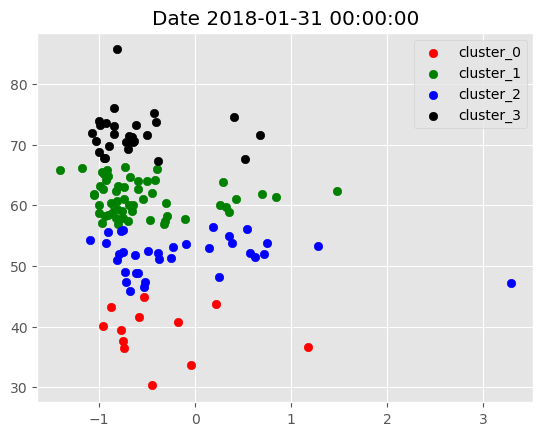

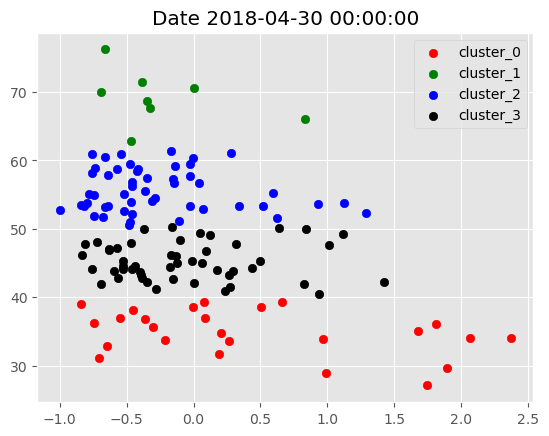

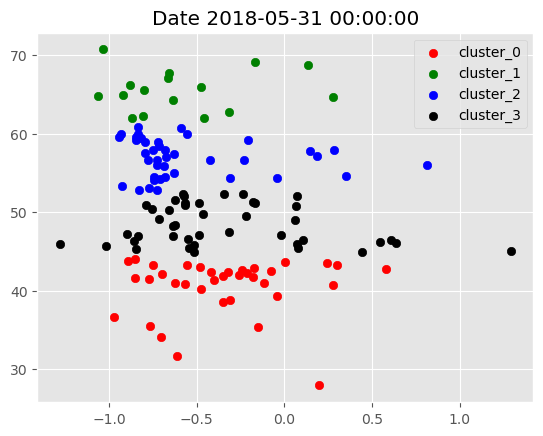

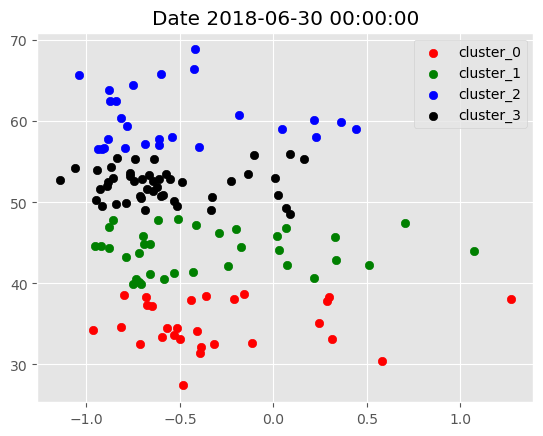

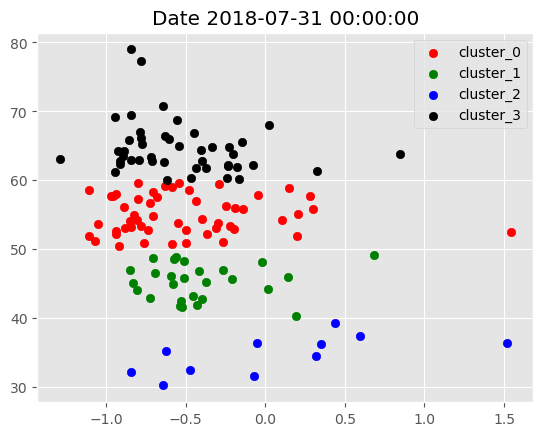

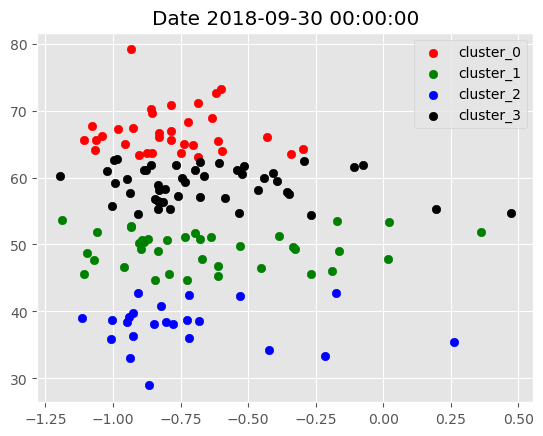

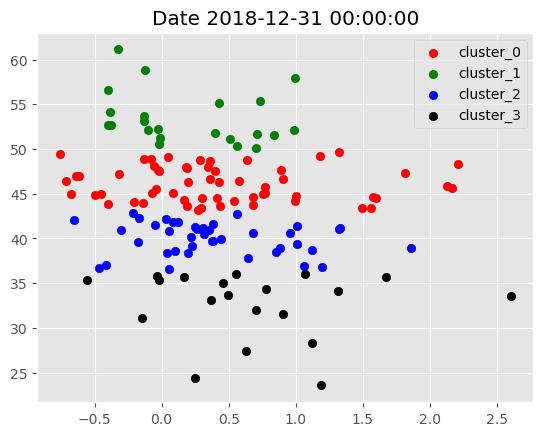

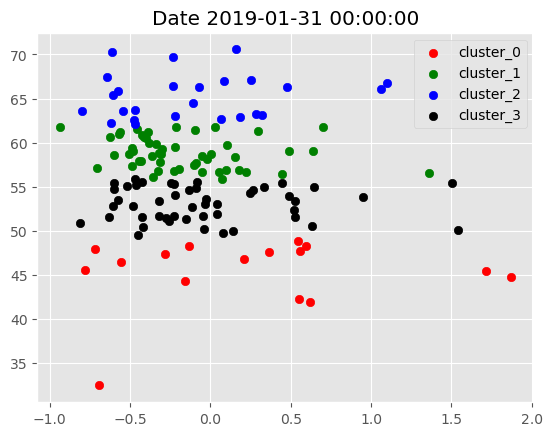

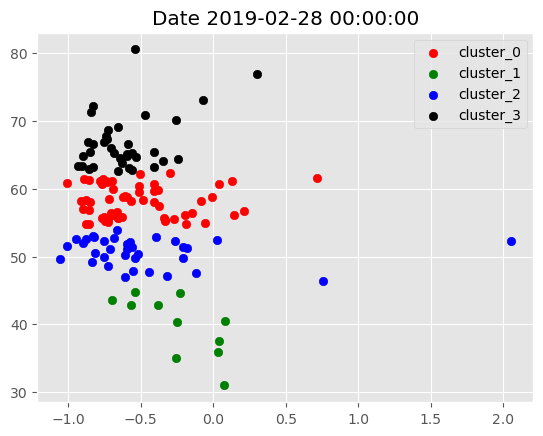

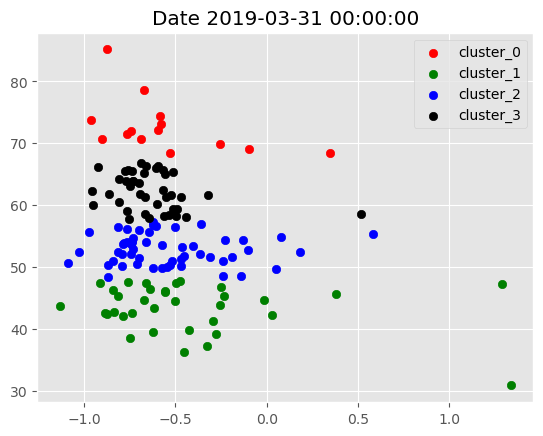

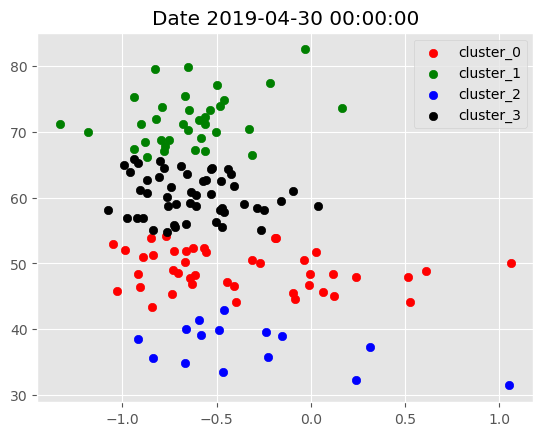

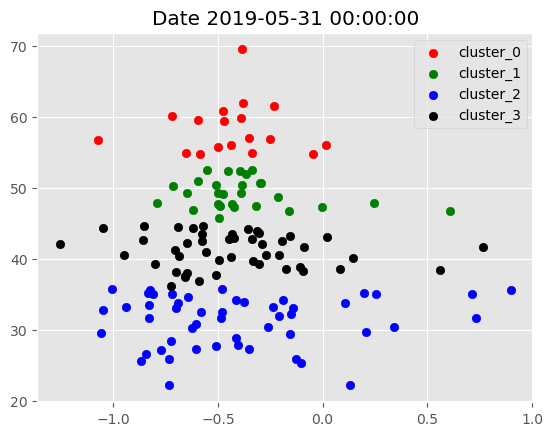

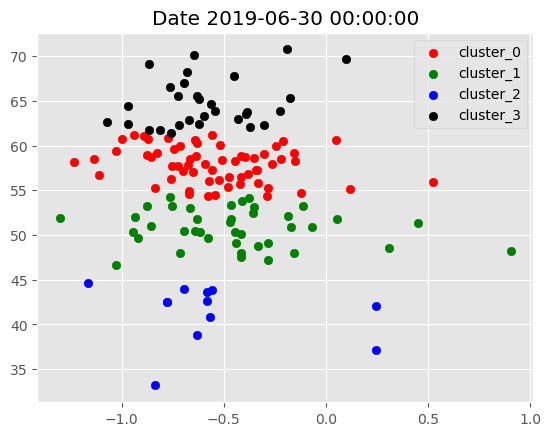

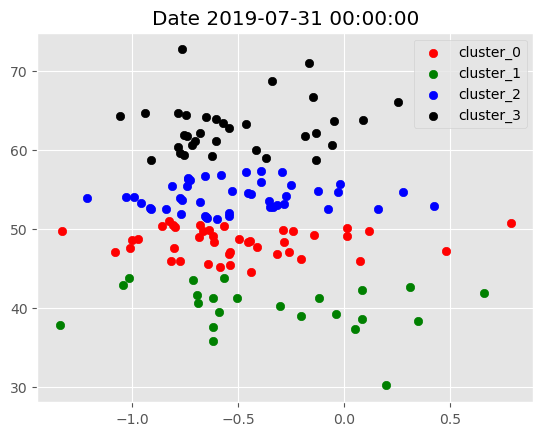

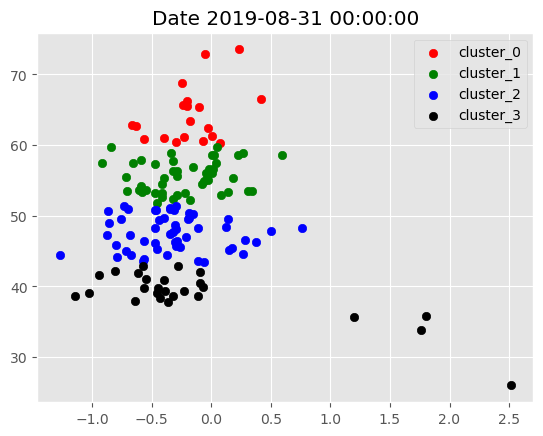

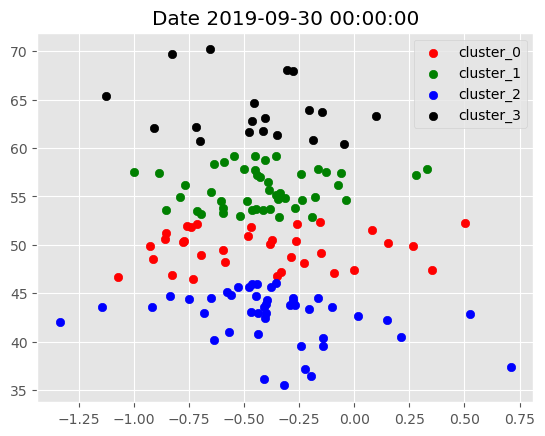

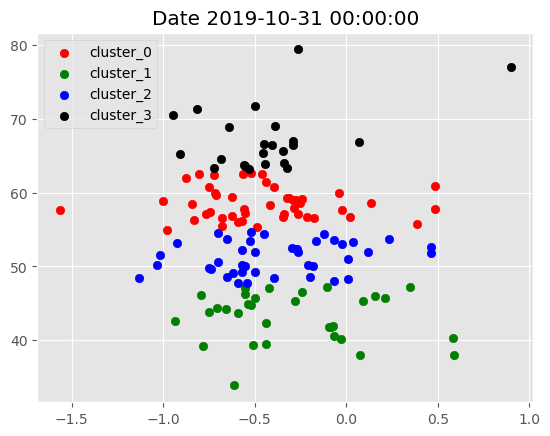

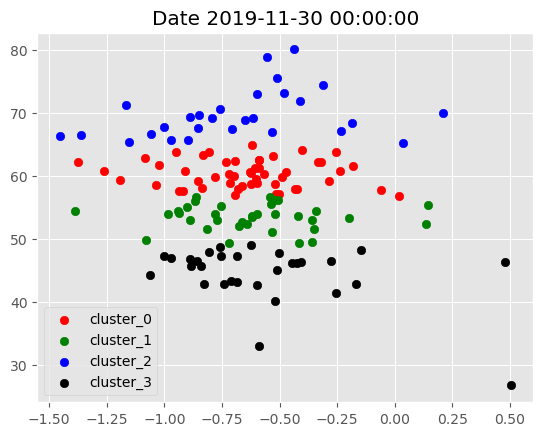

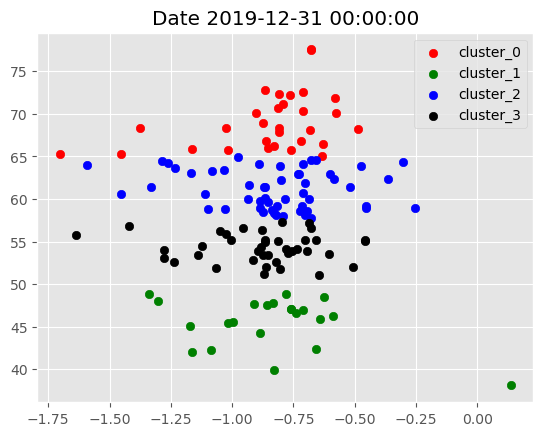

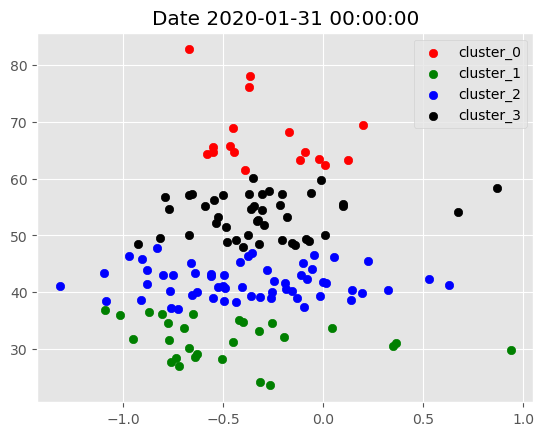

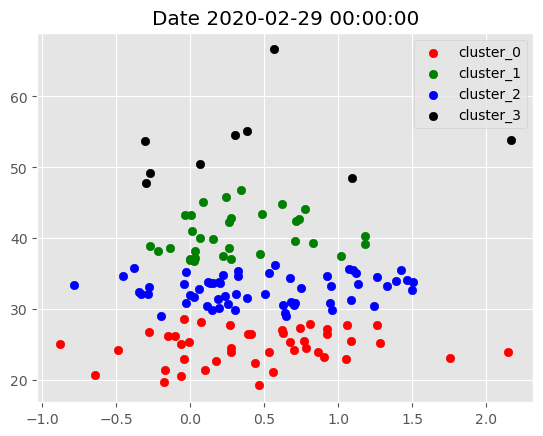

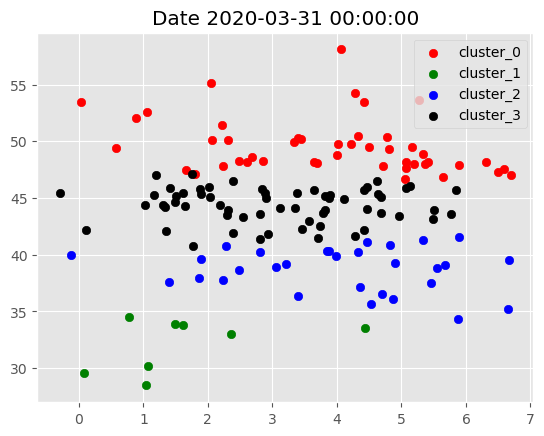

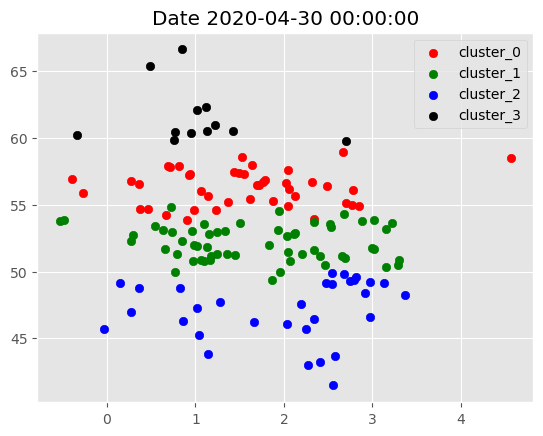

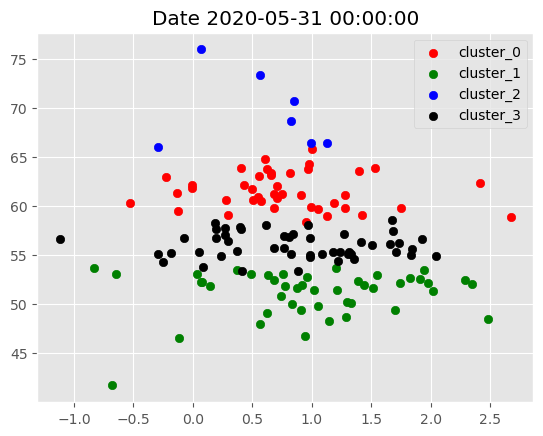

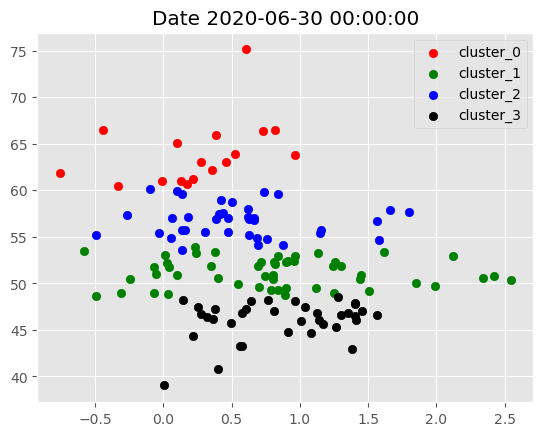

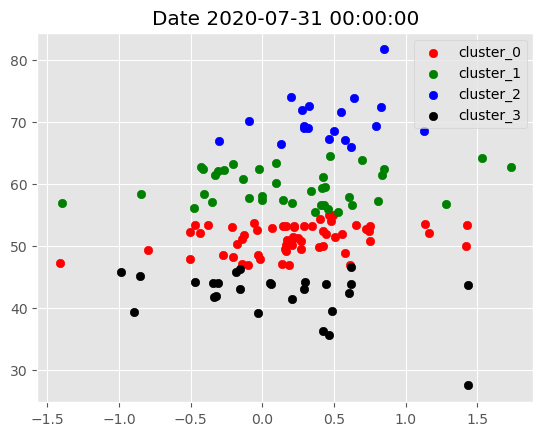

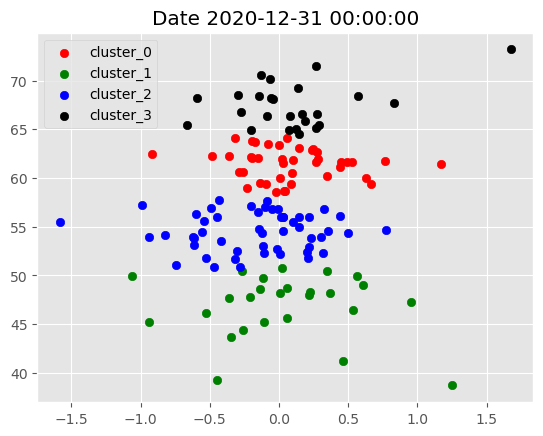

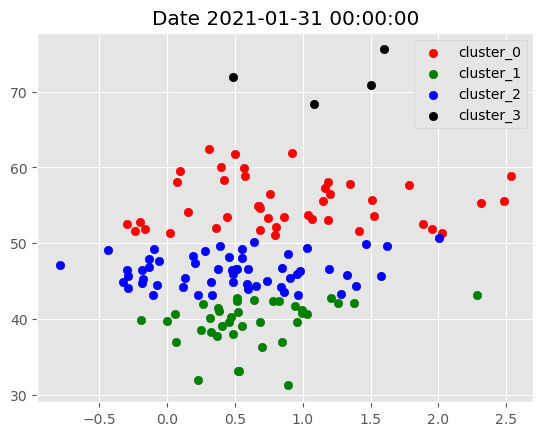

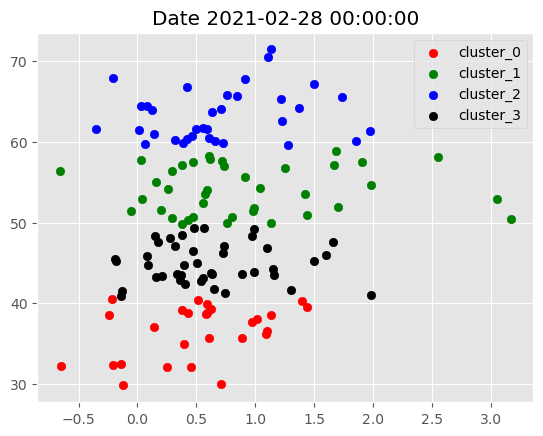

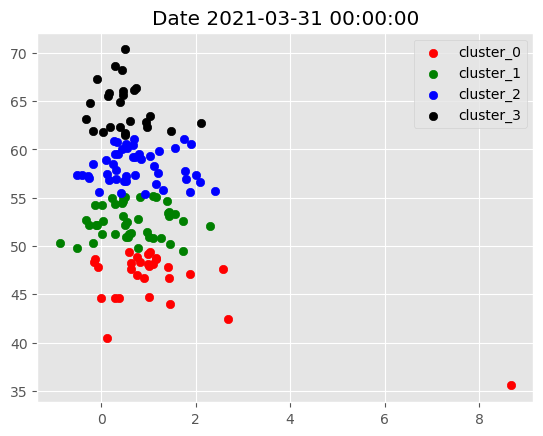

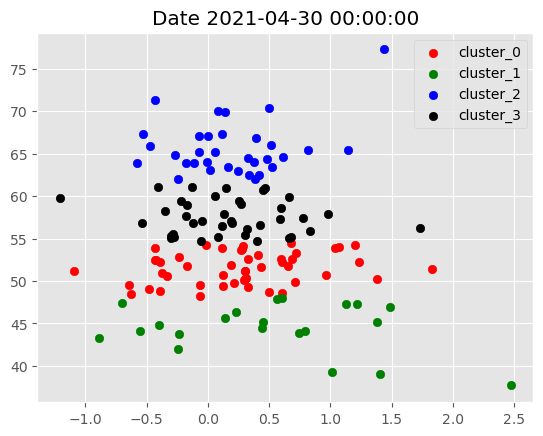

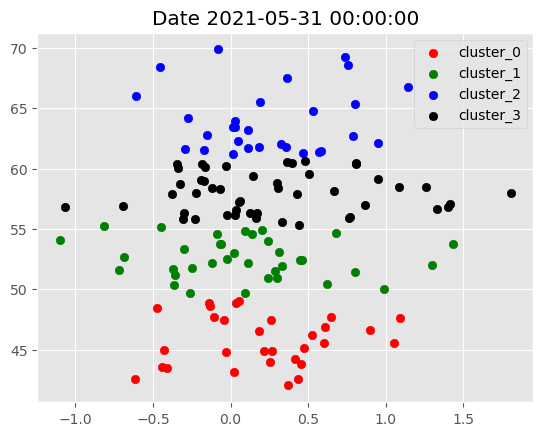

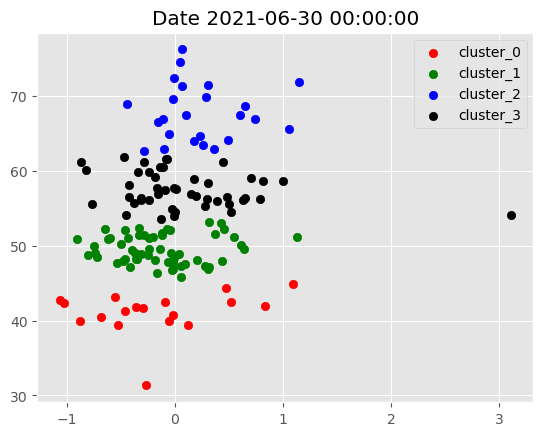

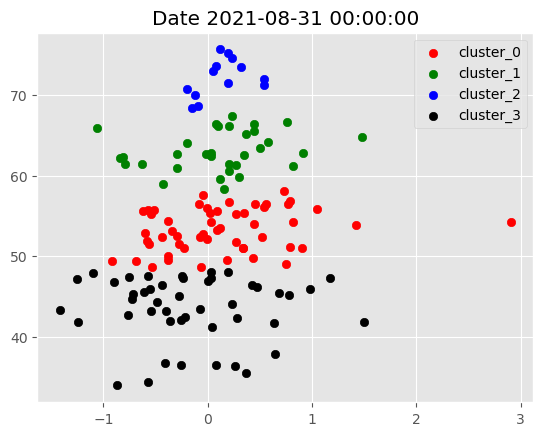

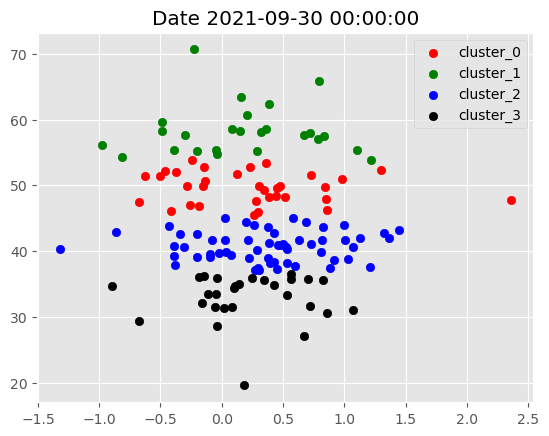

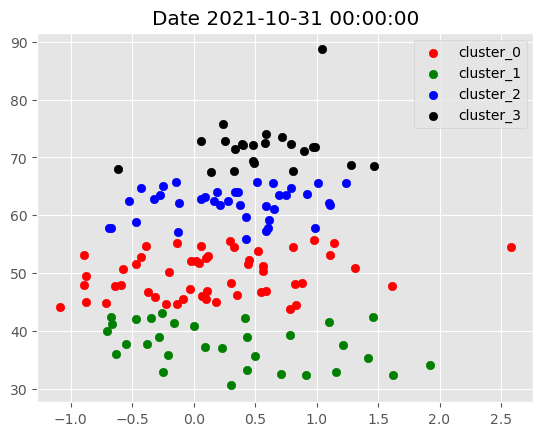

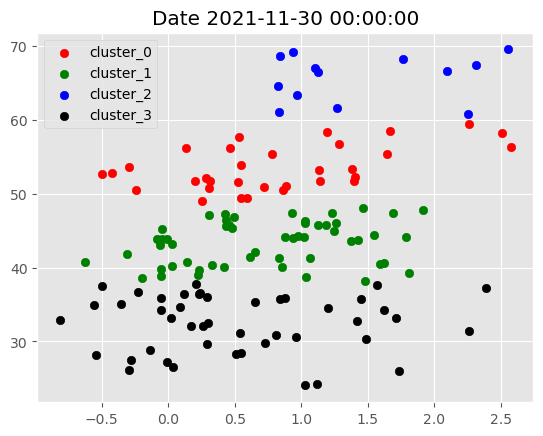

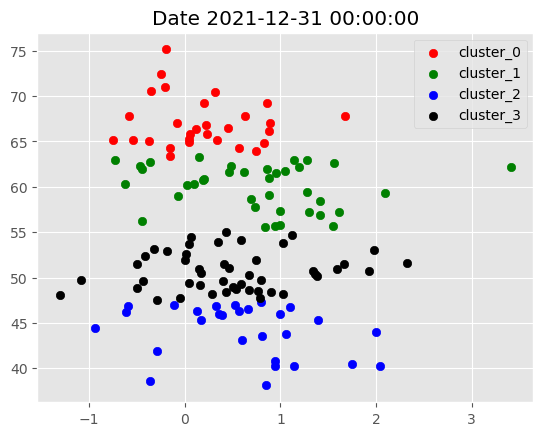

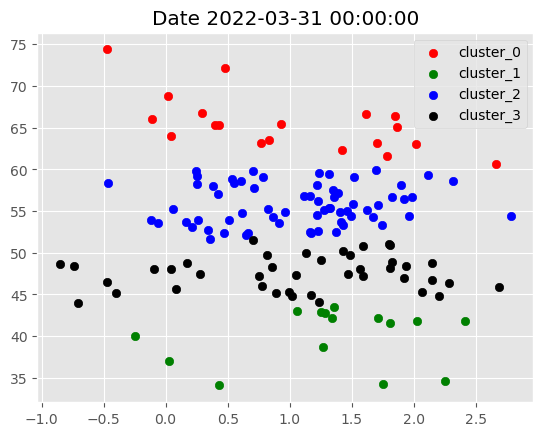

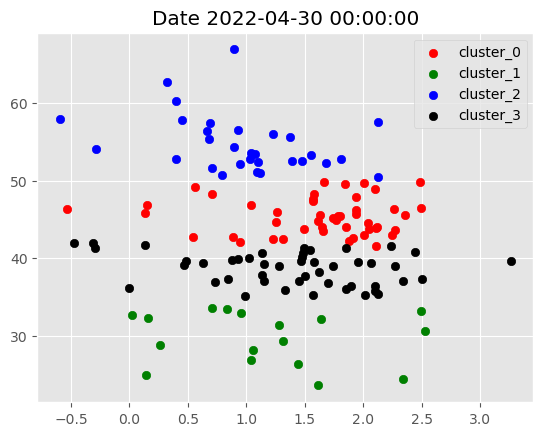

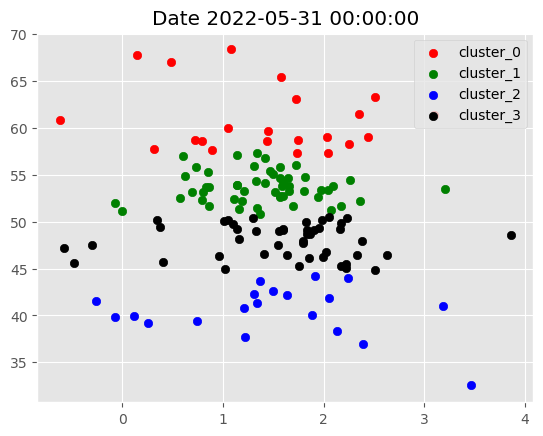

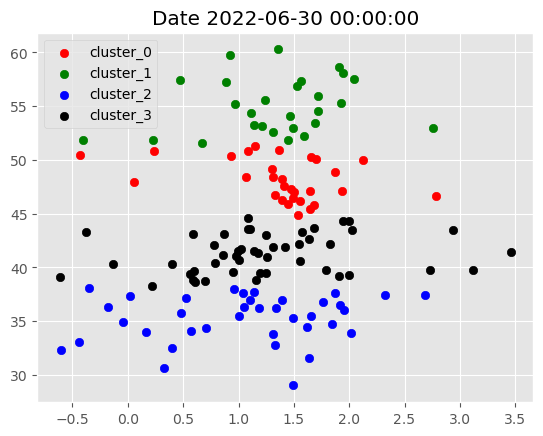

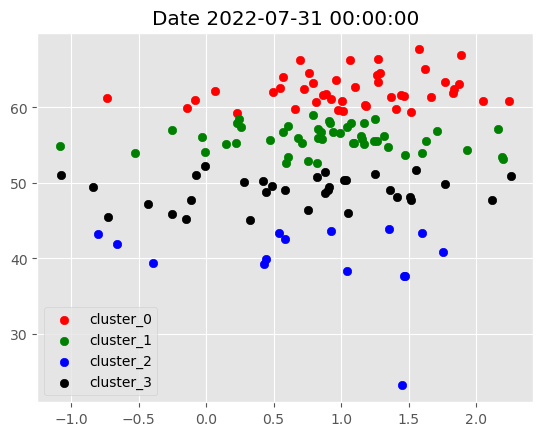

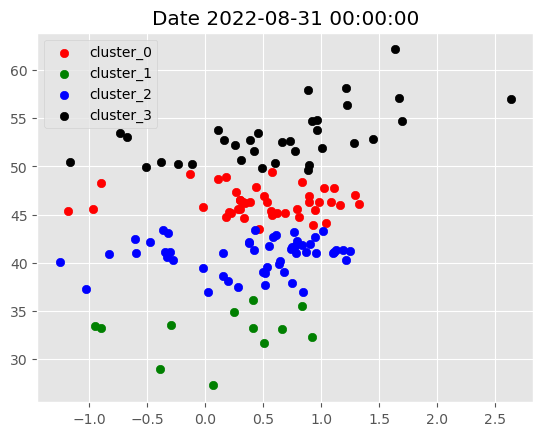

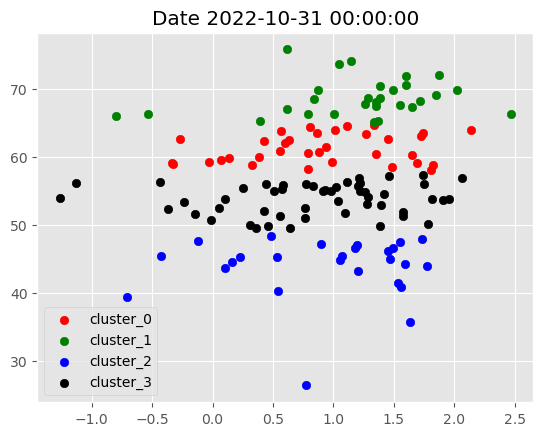

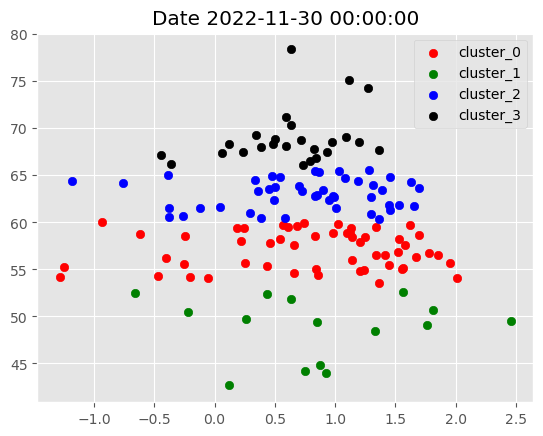

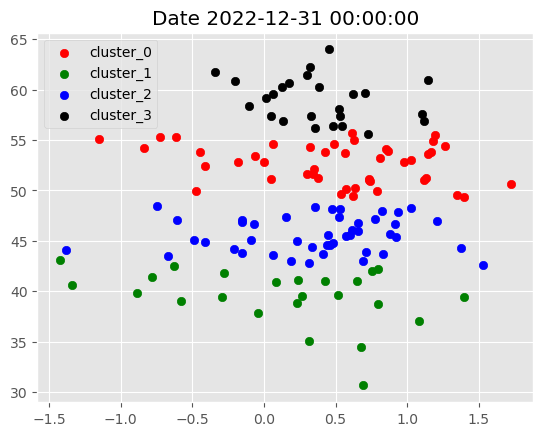

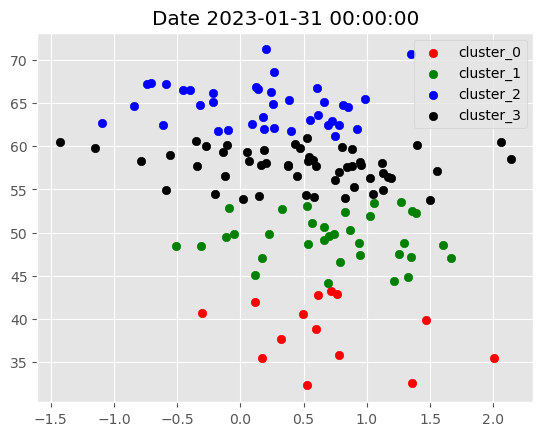

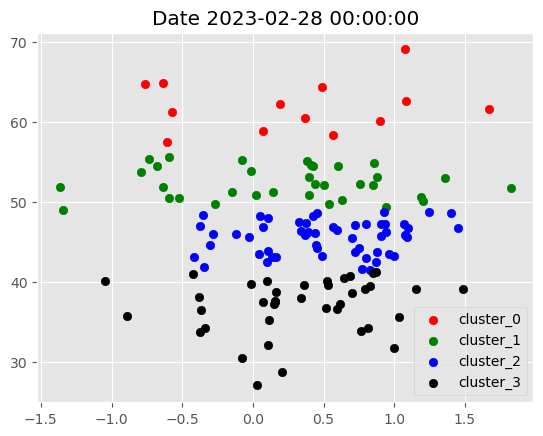

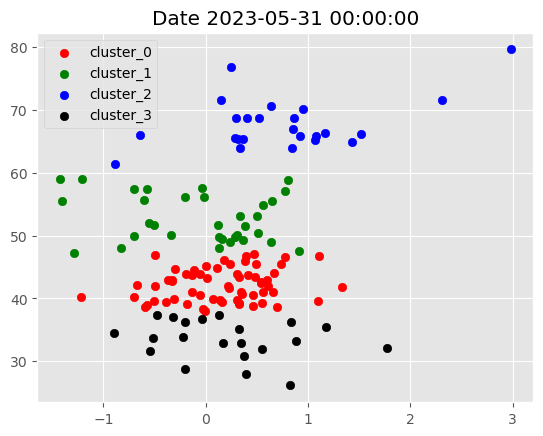

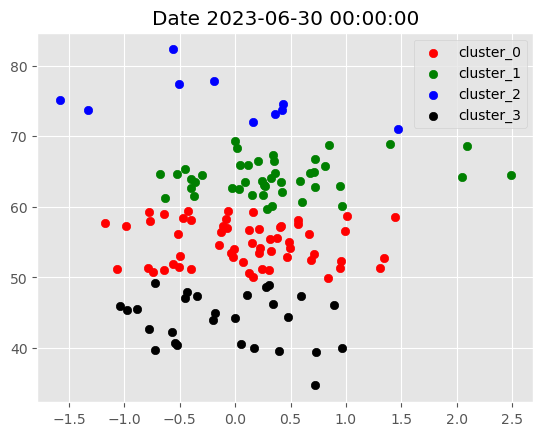

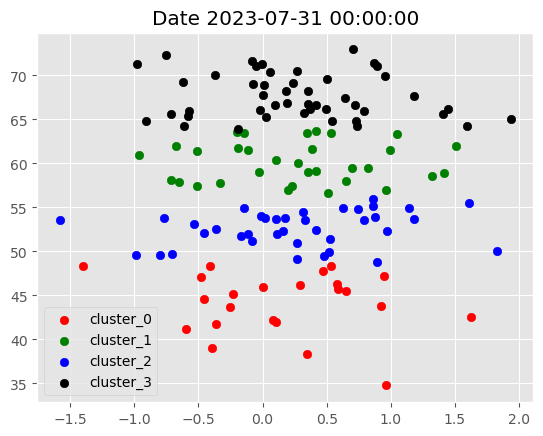

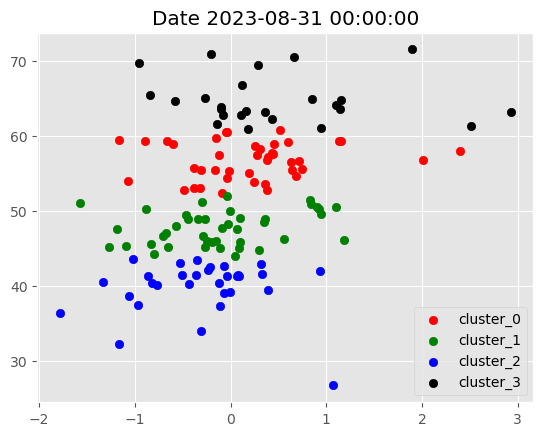

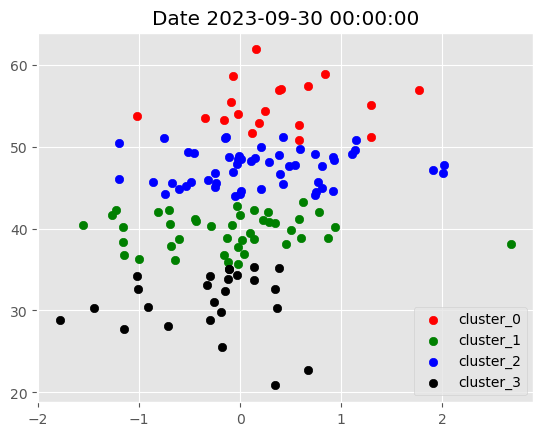

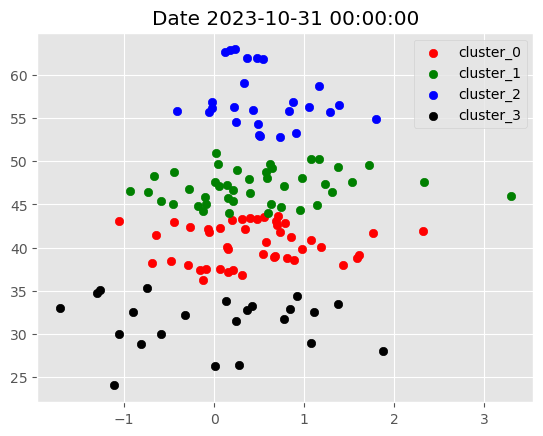

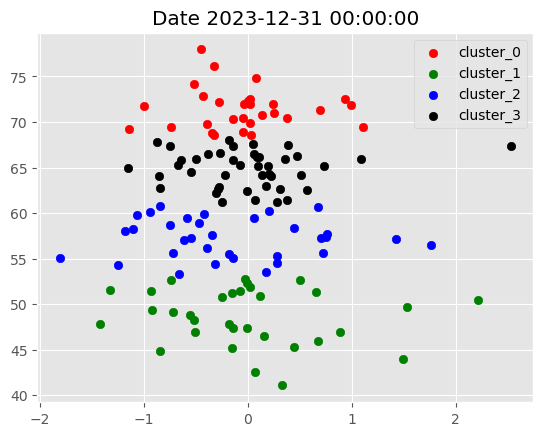

In [52]:
# Plotting the clustering for each month

plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

RSI acts as the stocks momentum. We want the highest upward momentum so we will select only stocks with RSI in the cluster intervals ~65-70 and >70  

Now our clustering function is assigning the centriods randomly so the clusters numbers 0,1,2,3 are assigned to the intervals randomly. We want to specify the cluster number assigned to the RSI interval, so rewriting the function by specifying the centroids

# Applying pre-defined centroids

In [53]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18)) # Because we have 18 columns/features

initial_centroids

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]])

In [54]:
initial_centroids[:, 6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [61]:
data = data.drop('cluster', axis=1)

data

atr   bb_high    bb_low    bb_mid  german_klass_vol  \
date       ticker                                                             
2018-01-31 AAL     1.275944  4.089372  3.908840  3.999106          0.000502   
           AAPL   -0.960483  3.781592  3.700759  3.741176         -0.001000   
           ABBV    1.476496  4.536019  4.272026  4.404022         -0.033621   
           ABT    -0.696011  4.073903  3.956251  4.015077         -0.004175   
           ACN    -0.984613  5.015497  4.968583  4.992040         -0.002706   
...                     ...       ...       ...       ...               ...   
2023-12-31 VRTX    1.086119  6.088512  5.817492  5.953002          0.000028   
           VZ     -1.182997  3.665356  3.616386  3.640871          0.000043   
           WFC    -0.753985  3.975643  3.800094  3.887869          0.000025   
           WMT    -0.005190  5.072549  5.018094  5.045321          0.000017   
           XOM     0.072672  4.651270  4.594084  4.622677          0.000041   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2018-01-31 AAL     0.617050  53.332161   0.044013   0.037235   0.051541   
           AAPL   -0.414727  40.100690  -0.010636  -0.012944  -0.001992   
           ABBV    2.091141  62.305717   0.168700   0.079892   0.077893   
           ABT     0.975507  69.274825   0.094398   0.052610   0.048209   
           ACN     0.293256  63.135408   0.049709   0.041987   0.041220   
...                     ...        ...        ...        ...        ...   
2023-12-31 VRTX    3.205584  65.899356   0.146783   0.060030   0.053758   
           VZ      0.466399  57.985178  -0.016436   0.035933   0.055029   
           WFC     1.913446  67.347850   0.103835   0.117430   0.067168   
           WMT    -0.274379  52.372668   0.016350  -0.015960  -0.003544   
           XOM    -0.683288  42.607132  -0.026864  -0.023690  -0.049736   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-01-31 AAL      0.013139   0.028045    0.017961  1.249866  1.364709   
           AAPL     0.021212   0.018481    0.028553  1.309649 -0.322089   
           ABBV     0.081692   0.063580    0.054846  0.471599  0.471134   
           ABT      0.041483   0.041095    0.035516  0.817002 -0.161576   
           ACN      0.039209   0.032852    0.030836  1.214378 -0.164183   
...                      ...        ...         ...       ...       ...   
2023-12-31 VRTX     0.024490   0.028824    0.028985  0.525011  0.001544   
           VZ       0.008786   0.002693    0.002233  0.488887 -0.360819   
           WFC      0.026895   0.033852    0.017357  1.076098 -0.094079   
           WMT      0.001708   0.008697    0.010148  0.610658 -0.446031   
           XOM     -0.008782  -0.007363   -0.005374  1.138796  0.273602   

                        HML       RMW       CMA  
date       ticker                                
2018-01-31 AAL     0.550423  0.308895  0.674377  
           AAPL   -0.616276  0.569702  0.568892  
           ABBV   -0.092797  0.370261  0.262704  
           ABT    -0.518631  0.287617  0.988571  
           ACN    -0.309566  0.294671  0.177457  
...                     ...       ...       ...  
2023-12-31 VRTX   -0.906215  0.132005  0.860918  
           VZ      0.085436  0.291998  0.474502  
           WFC     1.438222 -0.732211 -0.616143  
           WMT    -0.313553  0.315892  0.700381  
           XOM     0.675689 -0.489313  0.647678  

[10146 rows x 18 columns]

In [62]:
# Fit K-means model for each month and assign a cluster to each stock to get the labels all at once with pre-defined centroids

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                          random_state=0,
                          init=initial_centroids).fit(df).labels_
    
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

atr   bb_high    bb_low    bb_mid  german_klass_vol  \
date       ticker                                                             
2018-01-31 AAL     1.275944  4.089372  3.908840  3.999106          0.000502   
           AAPL   -0.960483  3.781592  3.700759  3.741176         -0.001000   
           ABBV    1.476496  4.536019  4.272026  4.404022         -0.033621   
           ABT    -0.696011  4.073903  3.956251  4.015077         -0.004175   
           ACN    -0.984613  5.015497  4.968583  4.992040         -0.002706   
...                     ...       ...       ...       ...               ...   
2023-12-31 VRTX    1.086119  6.088512  5.817492  5.953002          0.000028   
           VZ     -1.182997  3.665356  3.616386  3.640871          0.000043   
           WFC    -0.753985  3.975643  3.800094  3.887869          0.000025   
           WMT    -0.005190  5.072549  5.018094  5.045321          0.000017   
           XOM     0.072672  4.651270  4.594084  4.622677          0.000041   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2018-01-31 AAL     0.617050  53.332161   0.044013   0.037235   0.051541   
           AAPL   -0.414727  40.100690  -0.010636  -0.012944  -0.001992   
           ABBV    2.091141  62.305717   0.168700   0.079892   0.077893   
           ABT     0.975507  69.274825   0.094398   0.052610   0.048209   
           ACN     0.293256  63.135408   0.049709   0.041987   0.041220   
...                     ...        ...        ...        ...        ...   
2023-12-31 VRTX    3.205584  65.899356   0.146783   0.060030   0.053758   
           VZ      0.466399  57.985178  -0.016436   0.035933   0.055029   
           WFC     1.913446  67.347850   0.103835   0.117430   0.067168   
           WMT    -0.274379  52.372668   0.016350  -0.015960  -0.003544   
           XOM    -0.683288  42.607132  -0.026864  -0.023690  -0.049736   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-01-31 AAL      0.013139   0.028045    0.017961  1.249866  1.364709   
           AAPL     0.021212   0.018481    0.028553  1.309649 -0.322089   
           ABBV     0.081692   0.063580    0.054846  0.471599  0.471134   
           ABT      0.041483   0.041095    0.035516  0.817002 -0.161576   
           ACN      0.039209   0.032852    0.030836  1.214378 -0.164183   
...                      ...        ...         ...       ...       ...   
2023-12-31 VRTX     0.024490   0.028824    0.028985  0.525011  0.001544   
           VZ       0.008786   0.002693    0.002233  0.488887 -0.360819   
           WFC      0.026895   0.033852    0.017357  1.076098 -0.094079   
           WMT      0.001708   0.008697    0.010148  0.610658 -0.446031   
           XOM     -0.008782  -0.007363   -0.005374  1.138796  0.273602   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-01-31 AAL     0.550423  0.308895  0.674377        1  
           AAPL   -0.616276  0.569702  0.568892        0  
           ABBV   -0.092797  0.370261  0.262704        2  
           ABT    -0.518631  0.287617  0.988571        3  
           ACN    -0.309566  0.294671  0.177457        2  
...                     ...       ...       ...      ...  
2023-12-31 VRTX   -0.906215  0.132005  0.860918        0  
           VZ      0.085436  0.291998  0.474502        2  
           WFC     1.438222 -0.732211 -0.616143        0  
           WMT    -0.313553  0.315892  0.700381        2  
           XOM     0.675689 -0.489313  0.647678        1  

[10146 rows x 19 columns]

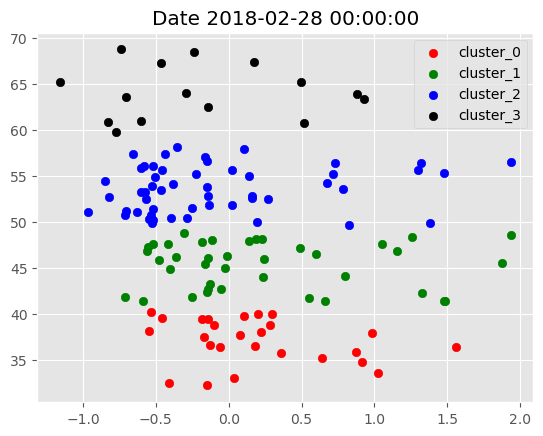

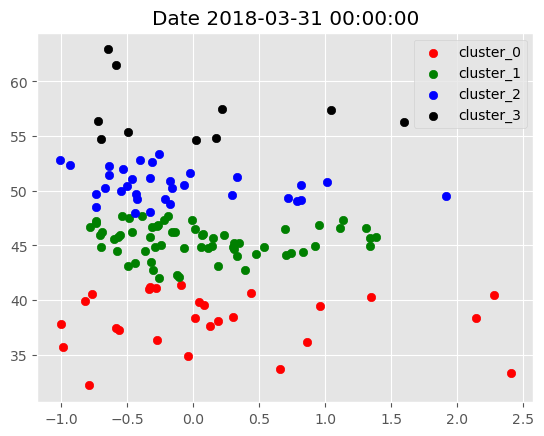

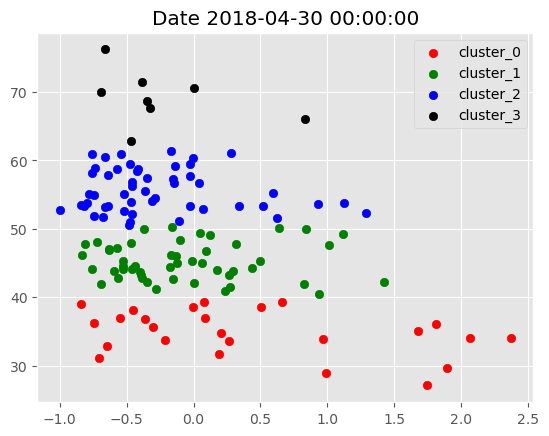

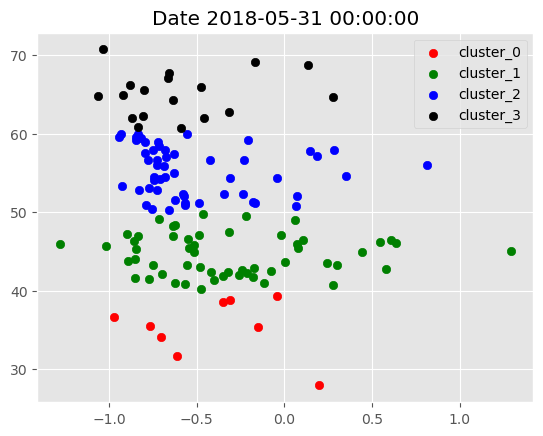

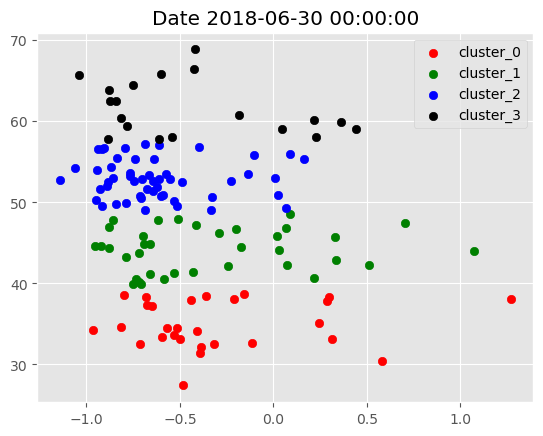

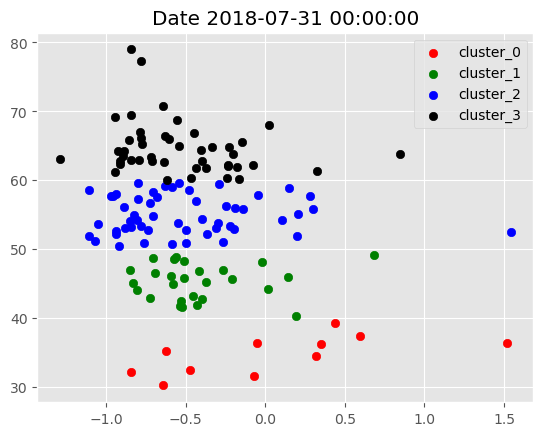

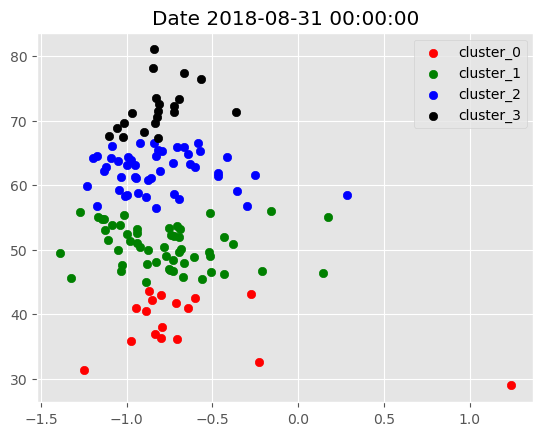

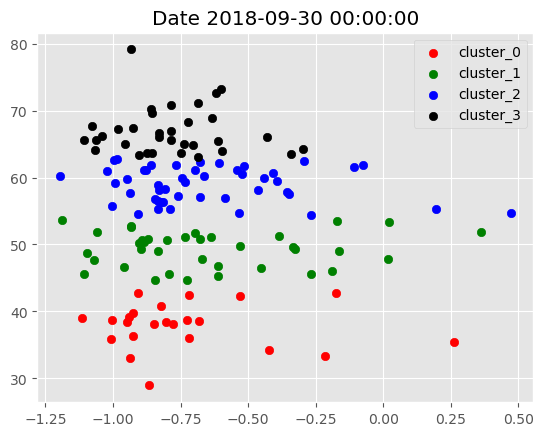

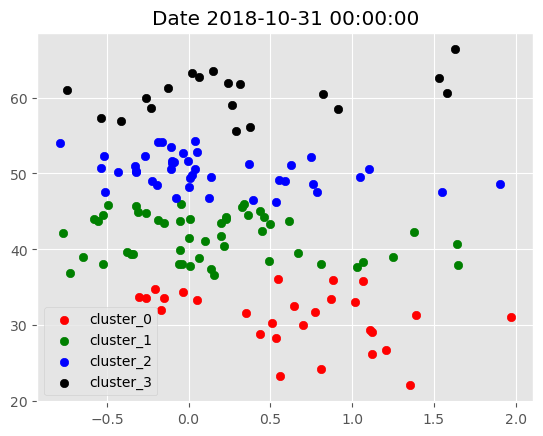

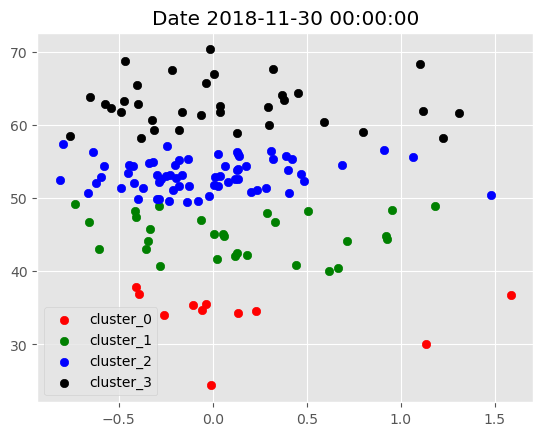

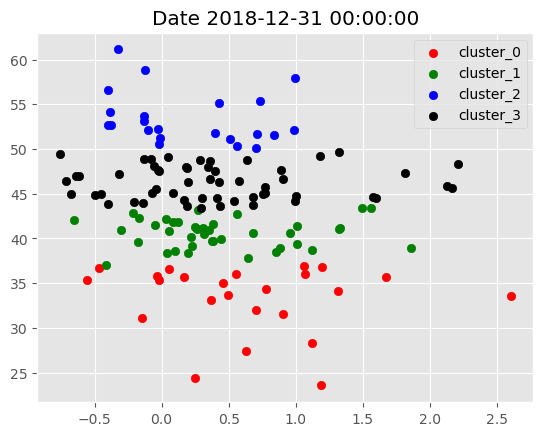

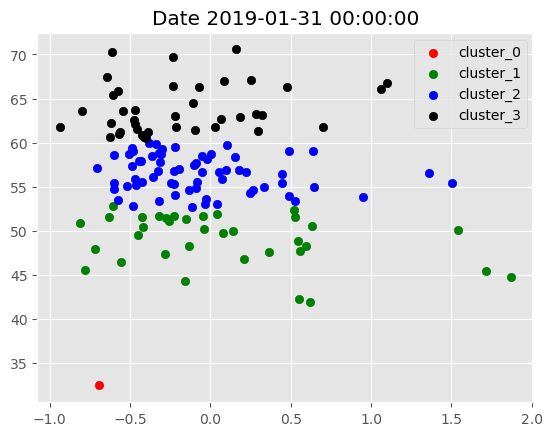

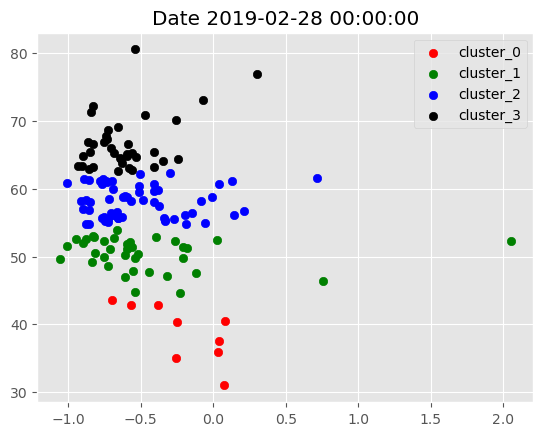

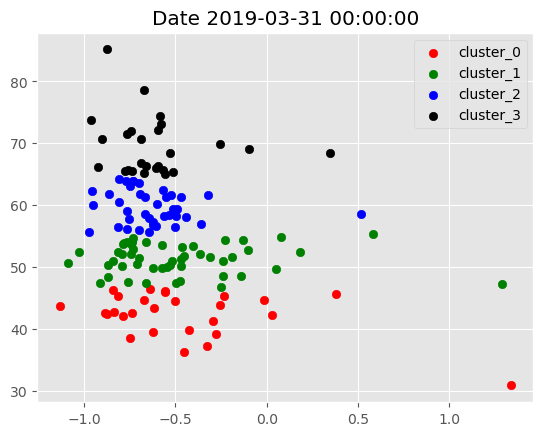

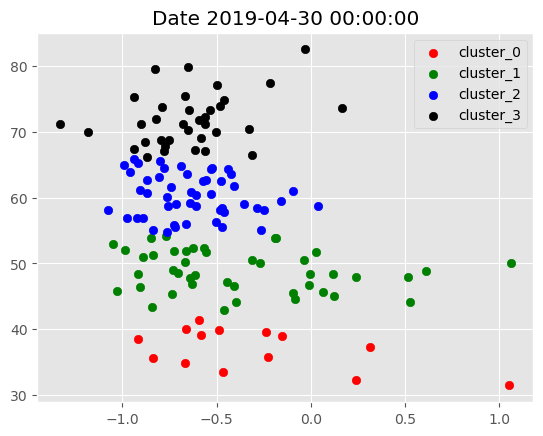

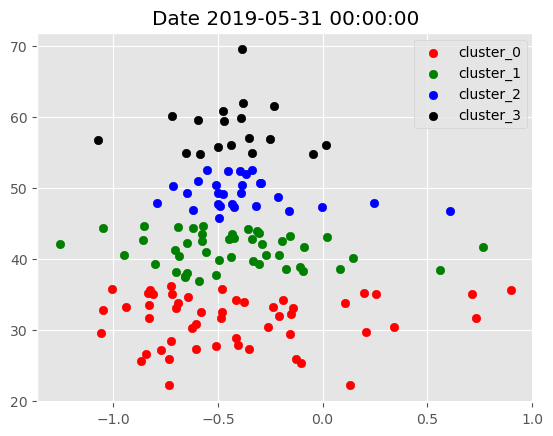

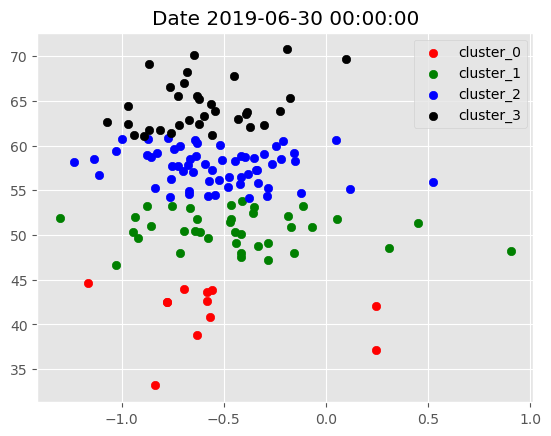

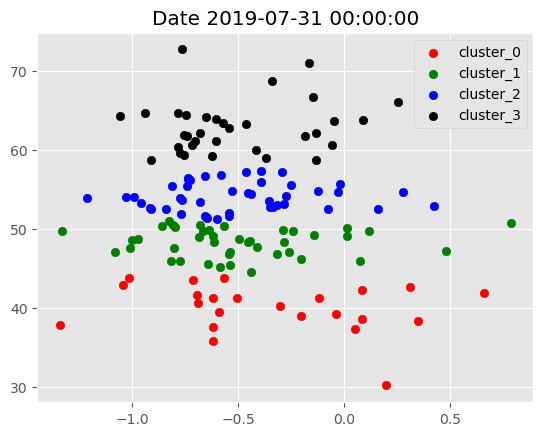

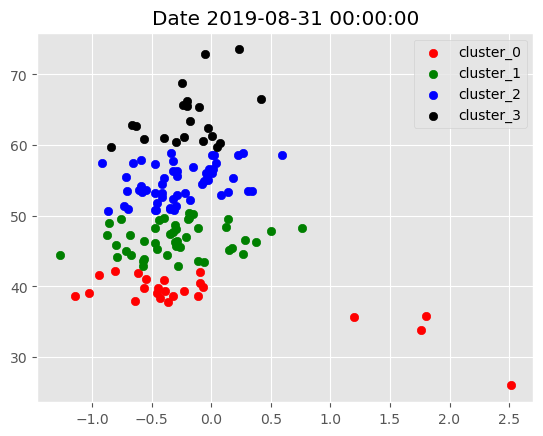

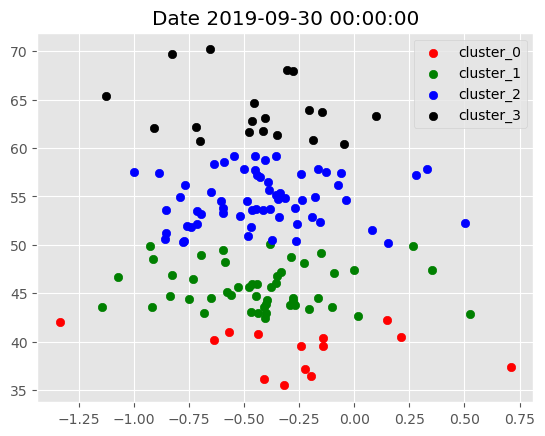

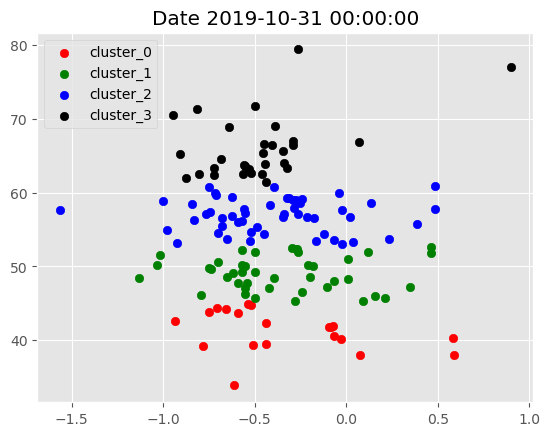

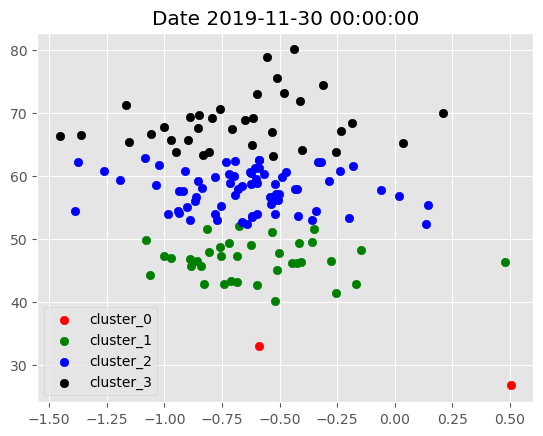

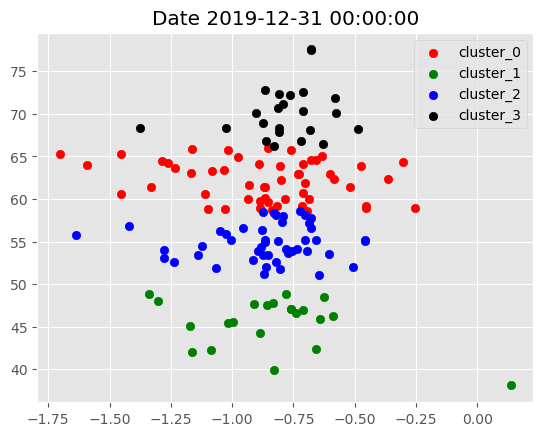

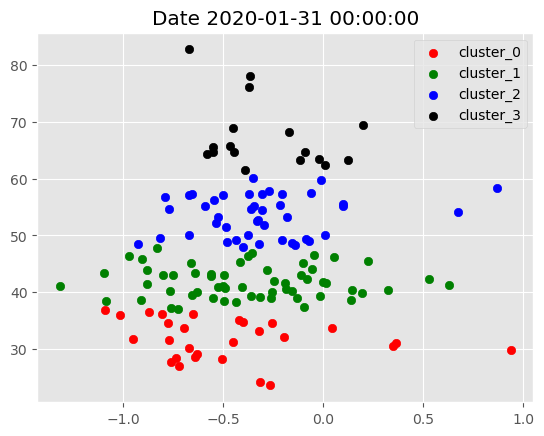

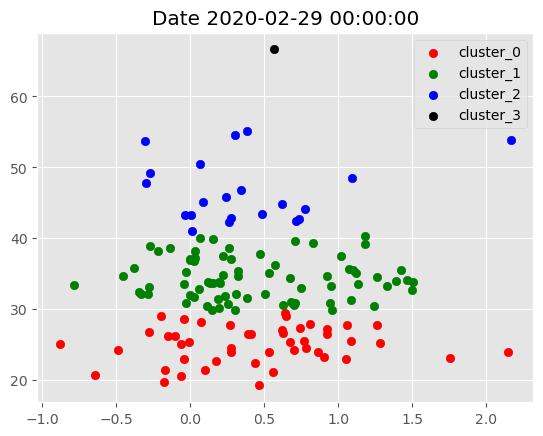

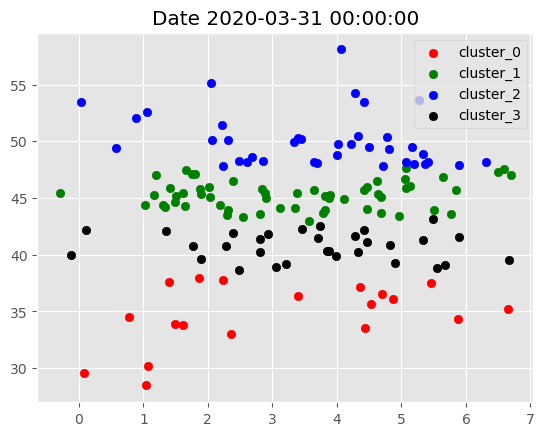

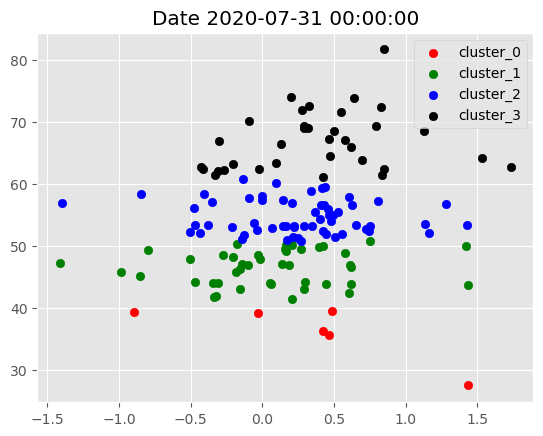

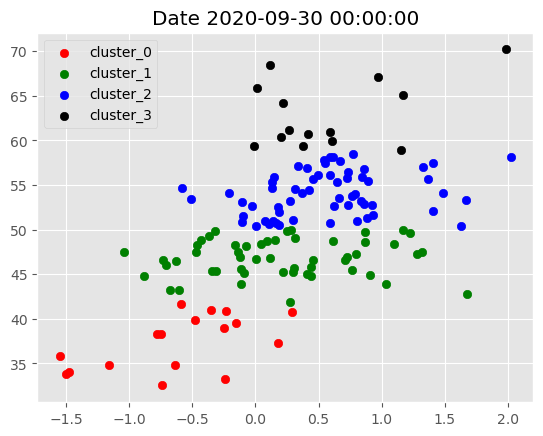

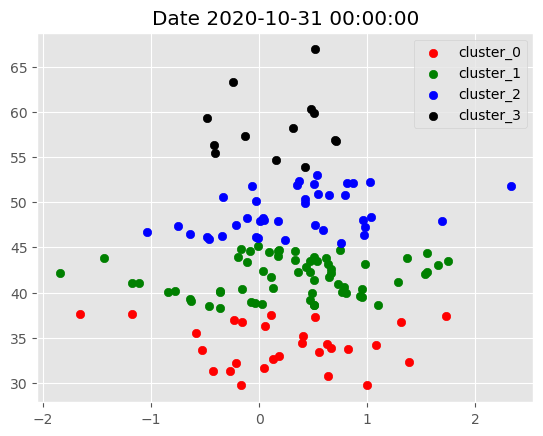

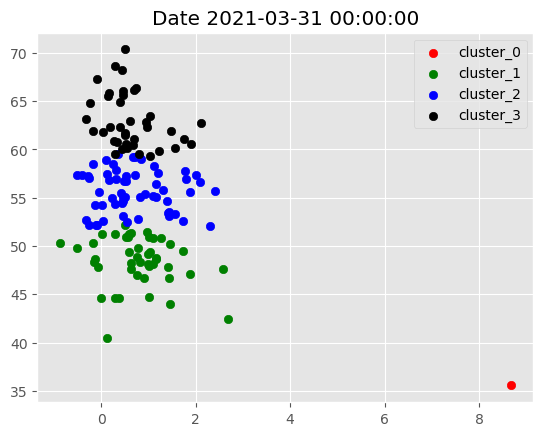

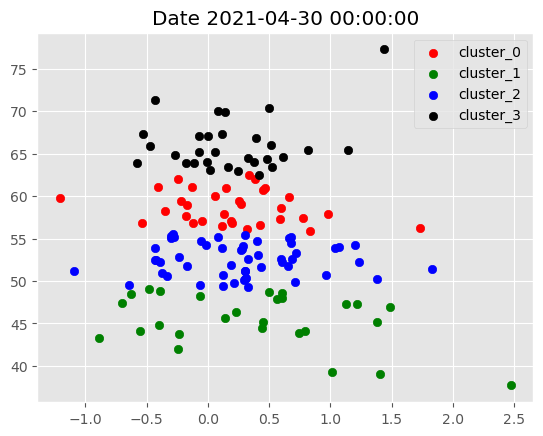

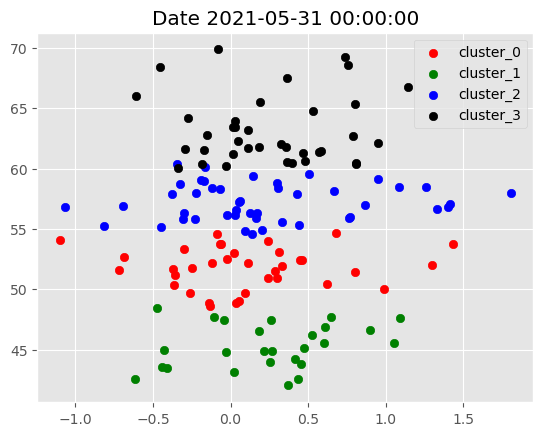

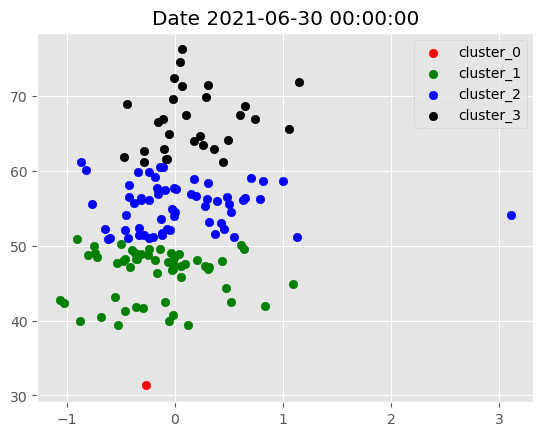

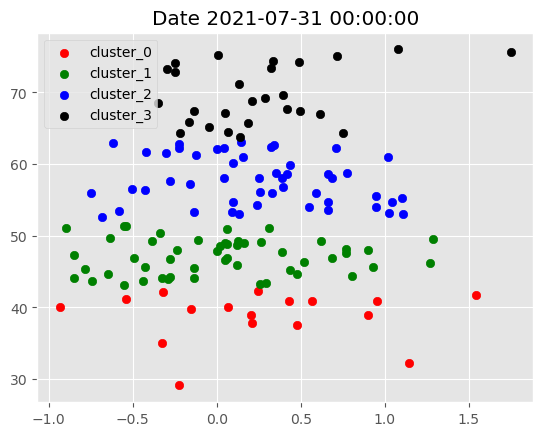

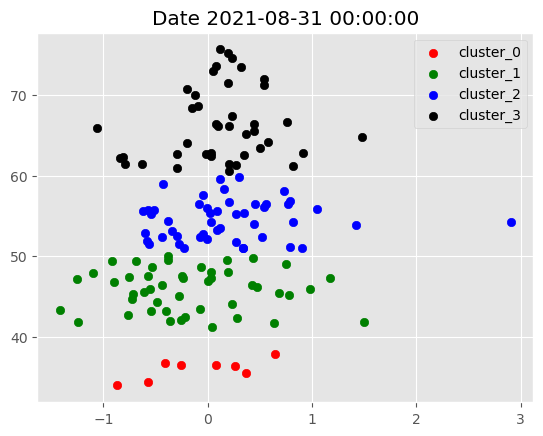

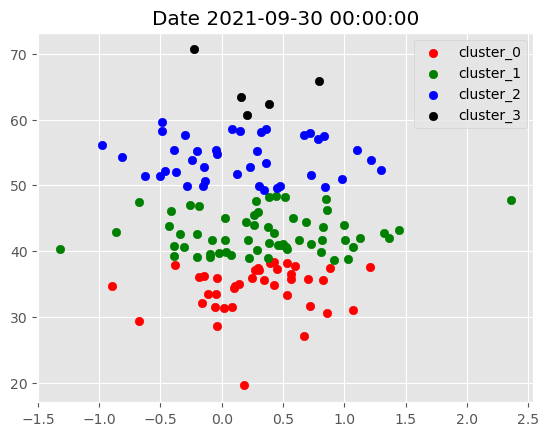

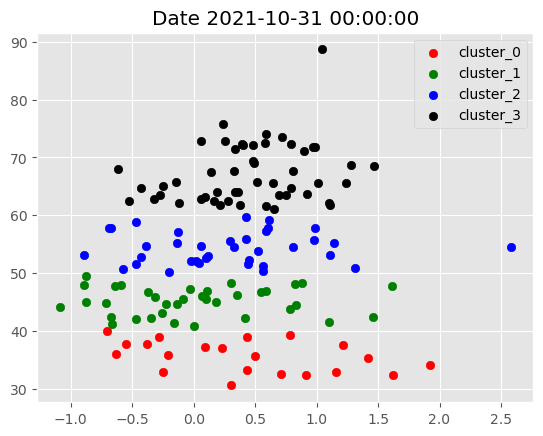

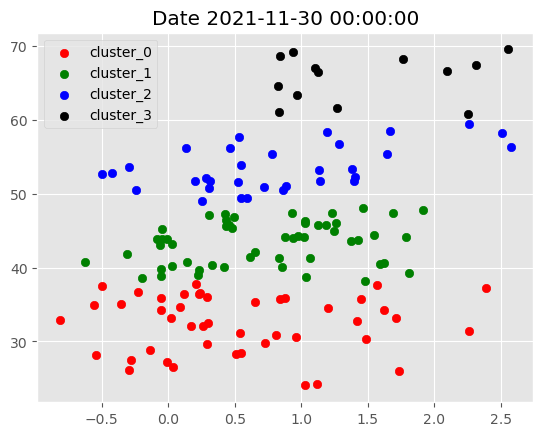

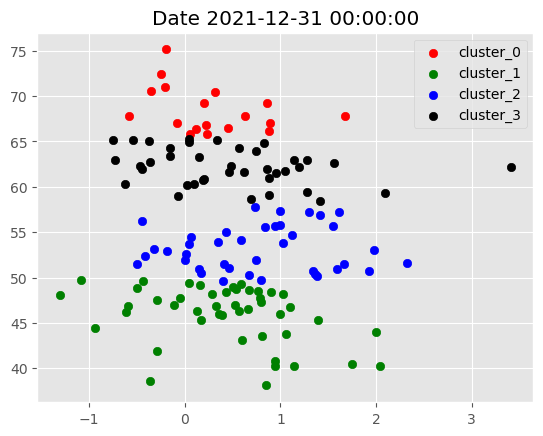

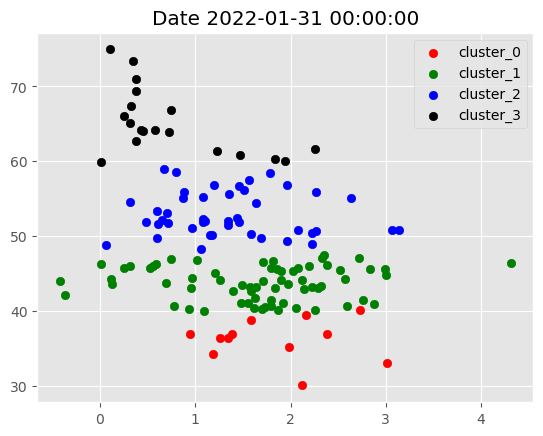

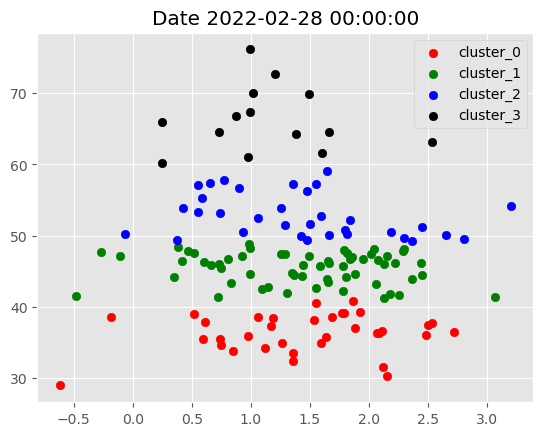

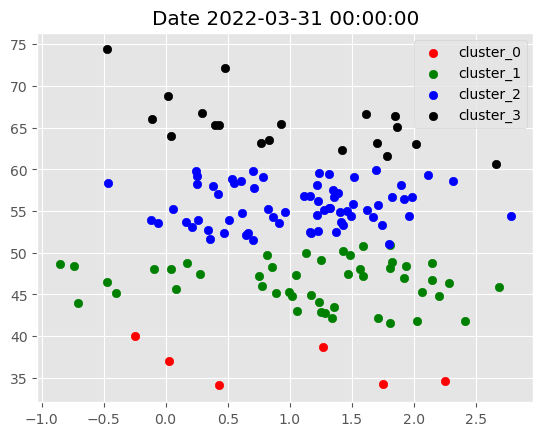

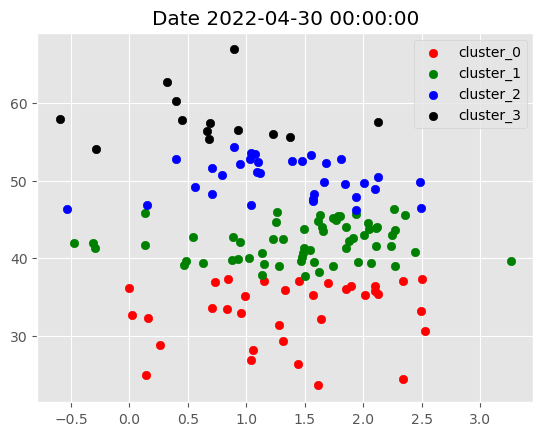

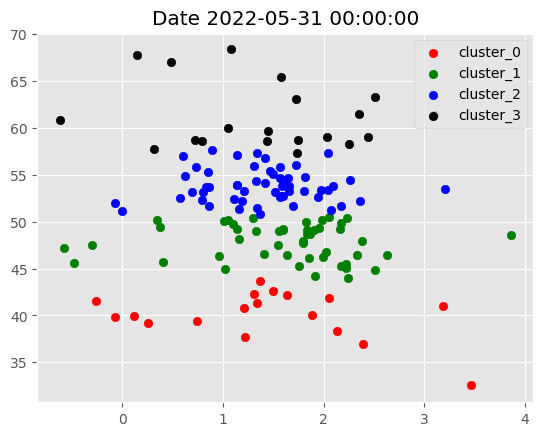

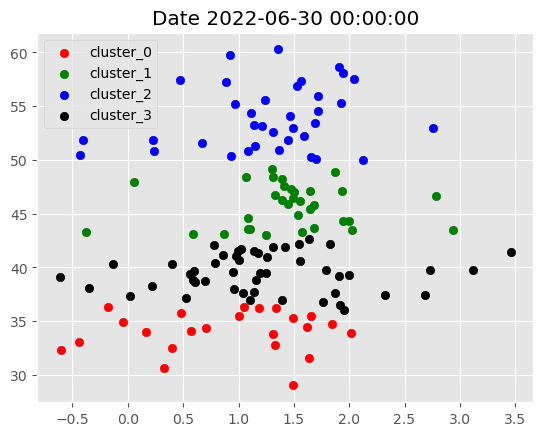

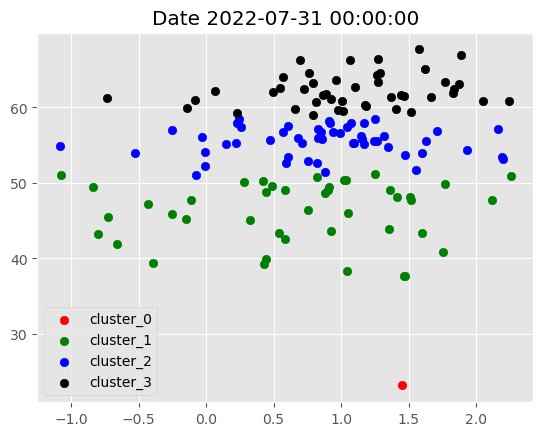

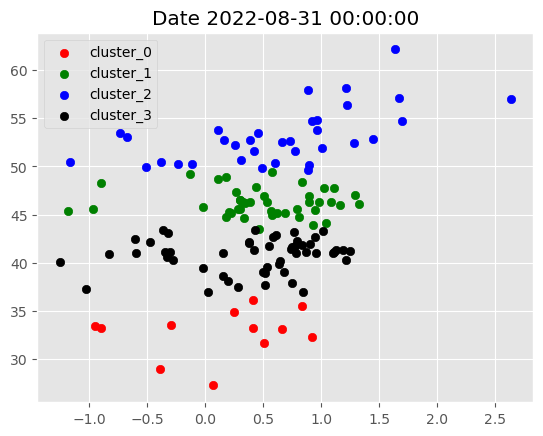

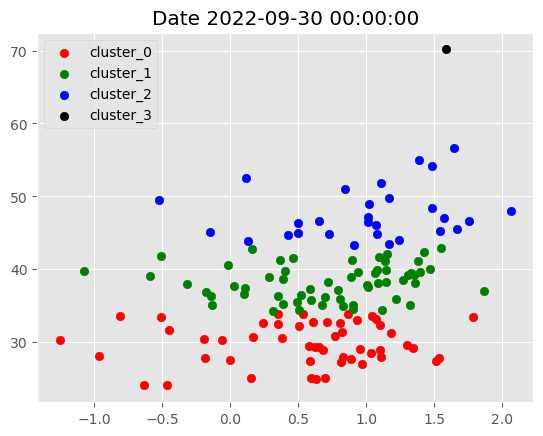

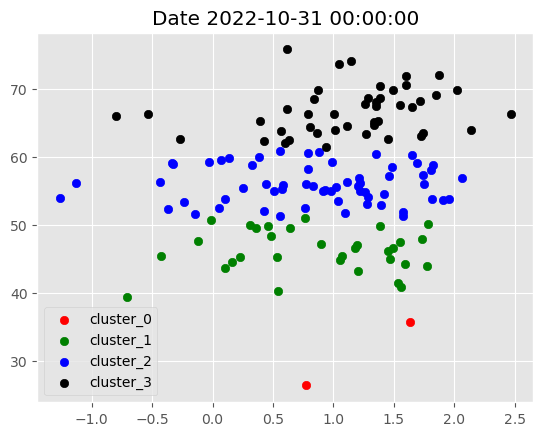

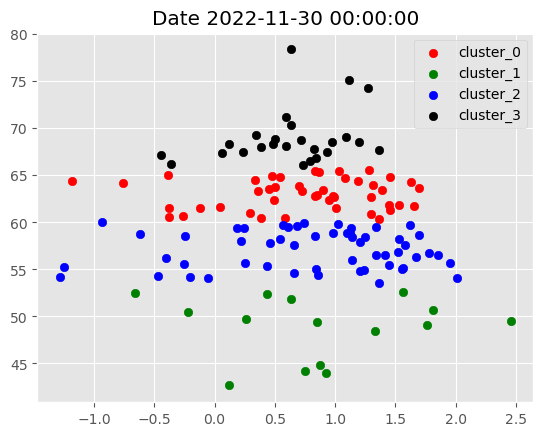

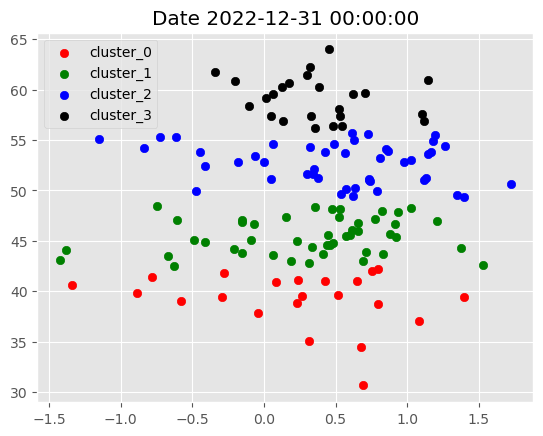

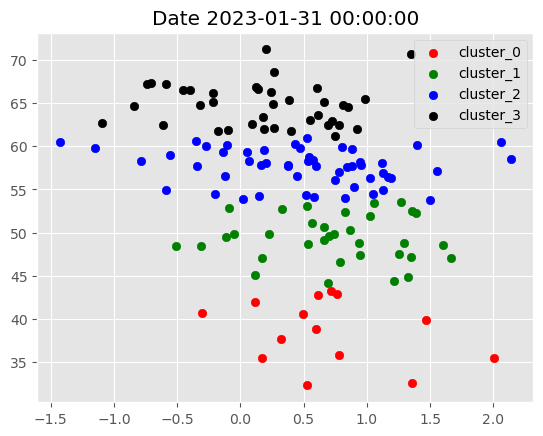

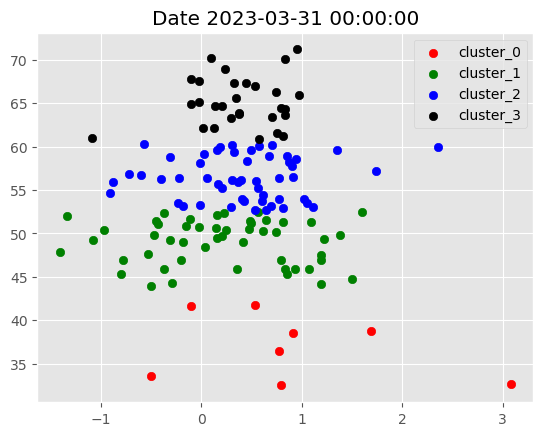

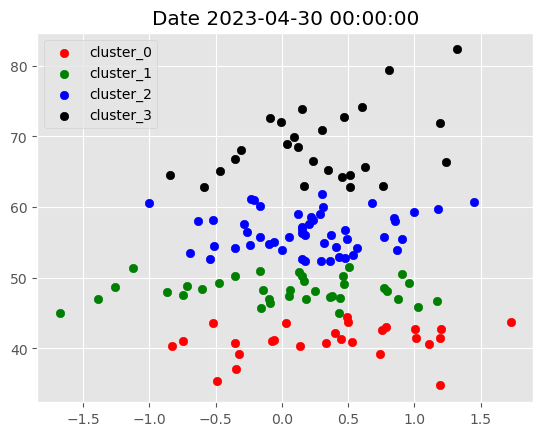

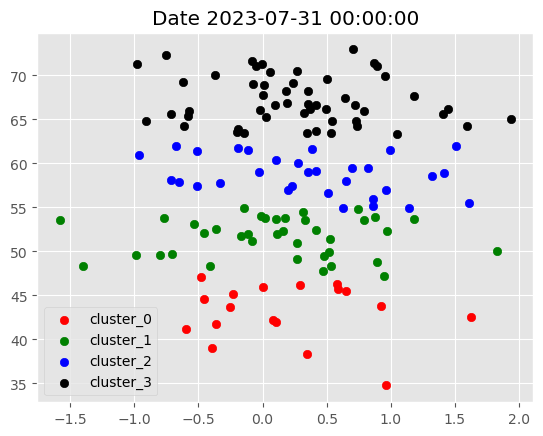

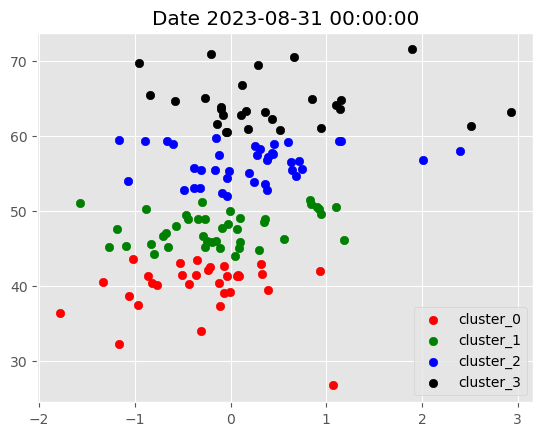

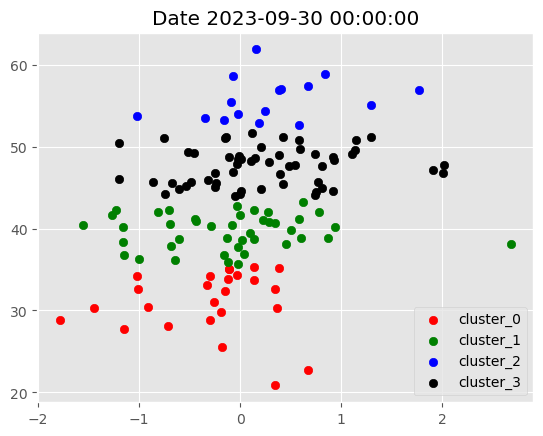

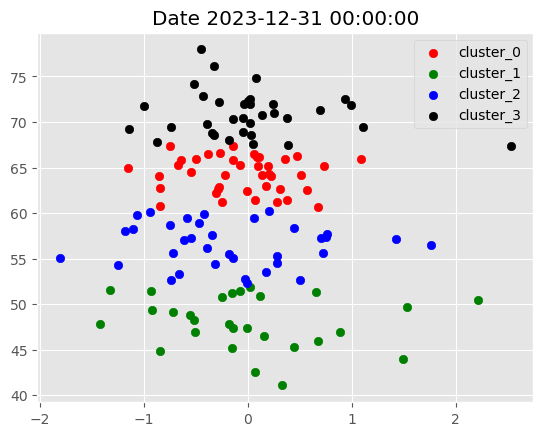

In [63]:
# Plotting the clustering for each month

plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

  
# 7. For each month select assets based on the cluster and form a portfolio based on  Efficient Frontier max sharpe rario optimization  

First we will filter only stocks corresponding to the cluster we choose based on our hypothesis (we will choose the highest upward momentum stocks from the >75 RSI bracket)  

Momentum is persistent and the idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus we will select stocks corresponding to cluster 3

In [64]:
data[data['cluster']==3]

atr   bb_high    bb_low    bb_mid  german_klass_vol  \
date       ticker                                                             
2018-01-31 ABT    -0.696011  4.073903  3.956251  4.015077         -0.004175   
           ADBE   -0.920625  5.332143  5.203949  5.268046          0.000156   
           AMZN   -0.817706  4.307725  4.091259  4.199492          0.000119   
           BA      0.405704  5.852751  5.655521  5.754136         -0.001303   
           BAC    -1.071647  3.387528  3.288741  3.338135         -0.007677   
...                     ...       ...       ...       ...               ...   
2023-12-31 RCL    -0.326823  4.899976  4.724033  4.812005          0.000094   
           SHW     0.077800  5.782916  5.633216  5.708066          0.000031   
           TGT    -0.321697  4.977524  4.889194  4.933359          0.000064   
           TMUS    0.136549  5.087858  5.031128  5.059493          0.000090   
           UNP    -0.048801  5.526710  5.426836  5.476773          0.000026   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2018-01-31 ABT     0.975507  69.274825   0.094398   0.052610   0.048209   
           ADBE    0.403125  65.801036   0.139922   0.049184   0.044779   
           AMZN    1.121539  85.692945   0.240639   0.110389   0.094933   
           BA      1.688856  74.629830   0.201621   0.131476   0.113610   
           BAC     0.939124  71.844604   0.084011   0.065814   0.054714   
...                     ...        ...        ...        ...        ...   
2023-12-31 RCL     2.097334  76.180888   0.205007   0.236231   0.120115   
           SHW     2.778281  74.792666   0.118723   0.142578   0.070191   
           TGT     1.302491  68.563405   0.064345   0.139653   0.091783   
           TMUS    1.462557  70.815994   0.065670   0.057994   0.047630   
           UNP     2.303599  70.412739   0.096454   0.090744   0.066475   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-01-31 ABT      0.041483   0.041095    0.035516  0.817002 -0.161576   
           ADBE     0.053053   0.045588    0.048329  1.157158 -0.380018   
           AMZN     0.066176   0.051289    0.048331  1.310359 -0.575603   
           BA       0.067304   0.077266    0.066622  1.010586  1.366856   
           BAC      0.049879   0.037140    0.030600  1.334643 -0.244818   
...                      ...        ...         ...       ...       ...   
2023-12-31 RCL      0.037644   0.079036    0.083562  2.196600  1.221617   
           SHW      0.027967   0.037897    0.023873  0.934501 -0.097511   
           TGT      0.016057  -0.013835   -0.001132  0.881807  0.481317   
           TMUS     0.024945   0.011843    0.011731  0.346440  0.854615   
           UNP      0.032872   0.024447    0.016437  1.143676 -0.221028   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-01-31 ABT    -0.518631  0.287617  0.988571        3  
           ADBE   -0.199375 -0.121659 -0.613360        3  
           AMZN   -0.488790 -0.516189 -0.085689        3  
           BA      0.160524  0.315491  0.156491        3  
           BAC     1.335717 -0.716335 -0.659742        3  
...                     ...       ...       ...      ...  
2023-12-31 RCL     0.334091 -1.481253  0.522961        3  
           SHW     0.015339  0.941924 -0.160321        3  
           TGT    -0.654176  1.056121  0.521789        3  
           TMUS   -0.301609  0.585263 -0.022974        3  
           UNP     0.003286 -0.242204  0.087720        3  

[1938 rows x 19 columns]

In [65]:
filtered_df = data[data['cluster']==3].copy()

filtered_df

atr   bb_high    bb_low    bb_mid  german_klass_vol  \
date       ticker                                                             
2018-01-31 ABT    -0.696011  4.073903  3.956251  4.015077         -0.004175   
           ADBE   -0.920625  5.332143  5.203949  5.268046          0.000156   
           AMZN   -0.817706  4.307725  4.091259  4.199492          0.000119   
           BA      0.405704  5.852751  5.655521  5.754136         -0.001303   
           BAC    -1.071647  3.387528  3.288741  3.338135         -0.007677   
...                     ...       ...       ...       ...               ...   
2023-12-31 RCL    -0.326823  4.899976  4.724033  4.812005          0.000094   
           SHW     0.077800  5.782916  5.633216  5.708066          0.000031   
           TGT    -0.321697  4.977524  4.889194  4.933359          0.000064   
           TMUS    0.136549  5.087858  5.031128  5.059493          0.000090   
           UNP    -0.048801  5.526710  5.426836  5.476773          0.000026   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2018-01-31 ABT     0.975507  69.274825   0.094398   0.052610   0.048209   
           ADBE    0.403125  65.801036   0.139922   0.049184   0.044779   
           AMZN    1.121539  85.692945   0.240639   0.110389   0.094933   
           BA      1.688856  74.629830   0.201621   0.131476   0.113610   
           BAC     0.939124  71.844604   0.084011   0.065814   0.054714   
...                     ...        ...        ...        ...        ...   
2023-12-31 RCL     2.097334  76.180888   0.205007   0.236231   0.120115   
           SHW     2.778281  74.792666   0.118723   0.142578   0.070191   
           TGT     1.302491  68.563405   0.064345   0.139653   0.091783   
           TMUS    1.462557  70.815994   0.065670   0.057994   0.047630   
           UNP     2.303599  70.412739   0.096454   0.090744   0.066475   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-01-31 ABT      0.041483   0.041095    0.035516  0.817002 -0.161576   
           ADBE     0.053053   0.045588    0.048329  1.157158 -0.380018   
           AMZN     0.066176   0.051289    0.048331  1.310359 -0.575603   
           BA       0.067304   0.077266    0.066622  1.010586  1.366856   
           BAC      0.049879   0.037140    0.030600  1.334643 -0.244818   
...                      ...        ...         ...       ...       ...   
2023-12-31 RCL      0.037644   0.079036    0.083562  2.196600  1.221617   
           SHW      0.027967   0.037897    0.023873  0.934501 -0.097511   
           TGT      0.016057  -0.013835   -0.001132  0.881807  0.481317   
           TMUS     0.024945   0.011843    0.011731  0.346440  0.854615   
           UNP      0.032872   0.024447    0.016437  1.143676 -0.221028   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-01-31 ABT    -0.518631  0.287617  0.988571        3  
           ADBE   -0.199375 -0.121659 -0.613360        3  
           AMZN   -0.488790 -0.516189 -0.085689        3  
           BA      0.160524  0.315491  0.156491        3  
           BAC     1.335717 -0.716335 -0.659742        3  
...                     ...       ...       ...      ...  
2023-12-31 RCL     0.334091 -1.481253  0.522961        3  
           SHW     0.015339  0.941924 -0.160321        3  
           TGT    -0.654176  1.056121  0.521789        3  
           TMUS   -0.301609  0.585263 -0.022974        3  
           UNP     0.003286 -0.242204  0.087720        3  

[1938 rows x 19 columns]

In [70]:
# filtered_df.xs('AAPL', level=1)

The goal is to use the list of stocks in each month bracket of the filtered dataset to invest in the next month

In [71]:
filtered_df = filtered_df.reset_index(level=1)

filtered_df

ticker       atr   bb_high    bb_low    bb_mid  german_klass_vol  \
date                                                                          
2018-01-31    ABT -0.696011  4.073903  3.956251  4.015077         -0.004175   
2018-01-31   ADBE -0.920625  5.332143  5.203949  5.268046          0.000156   
2018-01-31   AMZN -0.817706  4.307725  4.091259  4.199492          0.000119   
2018-01-31     BA  0.405704  5.852751  5.655521  5.754136         -0.001303   
2018-01-31    BAC -1.071647  3.387528  3.288741  3.338135         -0.007677   
...           ...       ...       ...       ...       ...               ...   
2023-12-31    RCL -0.326823  4.899976  4.724033  4.812005          0.000094   
2023-12-31    SHW  0.077800  5.782916  5.633216  5.708066          0.000031   
2023-12-31    TGT -0.321697  4.977524  4.889194  4.933359          0.000064   
2023-12-31   TMUS  0.136549  5.087858  5.031128  5.059493          0.000090   
2023-12-31    UNP -0.048801  5.526710  5.426836  5.476773          0.000026   

                macd        rsi  return_1m  return_2m  return_3m  return_6m  \
date                                                                          
2018-01-31  0.975507  69.274825   0.094398   0.052610   0.048209   0.041483   
2018-01-31  0.403125  65.801036   0.139922   0.049184   0.044779   0.053053   
2018-01-31  1.121539  85.692945   0.240639   0.110389   0.094933   0.066176   
2018-01-31  1.688856  74.629830   0.201621   0.131476   0.113610   0.067304   
2018-01-31  0.939124  71.844604   0.084011   0.065814   0.054714   0.049879   
...              ...        ...        ...        ...        ...        ...   
2023-12-31  2.097334  76.180888   0.205007   0.236231   0.120115   0.037644   
2023-12-31  2.778281  74.792666   0.118723   0.142578   0.070191   0.027967   
2023-12-31  1.302491  68.563405   0.064345   0.139653   0.091783   0.016057   
2023-12-31  1.462557  70.815994   0.065670   0.057994   0.047630   0.024945   
2023-12-31  2.303599  70.412739   0.096454   0.090744   0.066475   0.032872   

            return_9m  return_12m    Mkt-RF       SMB       HML       RMW  \
date                                                                        
2018-01-31   0.041095    0.035516  0.817002 -0.161576 -0.518631  0.287617   
2018-01-31   0.045588    0.048329  1.157158 -0.380018 -0.199375 -0.121659   
2018-01-31   0.051289    0.048331  1.310359 -0.575603 -0.488790 -0.516189   
2018-01-31   0.077266    0.066622  1.010586  1.366856  0.160524  0.315491   
2018-01-31   0.037140    0.030600  1.334643 -0.244818  1.335717 -0.716335   
...               ...         ...       ...       ...       ...       ...   
2023-12-31   0.079036    0.083562  2.196600  1.221617  0.334091 -1.481253   
2023-12-31   0.037897    0.023873  0.934501 -0.097511  0.015339  0.941924   
2023-12-31  -0.013835   -0.001132  0.881807  0.481317 -0.654176  1.056121   
2023-12-31   0.011843    0.011731  0.346440  0.854615 -0.301609  0.585263   
2023-12-31   0.024447    0.016437  1.143676 -0.221028  0.003286 -0.242204   

                 CMA  cluster  
date                           
2018-01-31  0.988571        3  
2018-01-31 -0.613360        3  
2018-01-31 -0.085689        3  
2018-01-31  0.156491        3  
2018-01-31 -0.659742        3  
...              ...      ...  
2023-12-31  0.522961        3  
2023-12-31 -0.160321        3  
2023-12-31  0.521789        3  
2023-12-31 -0.022974        3  
2023-12-31  0.087720        3  

[1938 rows x 20 columns]

In [72]:
filtered_df.index = filtered_df.index + pd.DateOffset(1)

filtered_df

ticker       atr   bb_high    bb_low    bb_mid  german_klass_vol  \
date                                                                          
2018-02-01    ABT -0.696011  4.073903  3.956251  4.015077         -0.004175   
2018-02-01   ADBE -0.920625  5.332143  5.203949  5.268046          0.000156   
2018-02-01   AMZN -0.817706  4.307725  4.091259  4.199492          0.000119   
2018-02-01     BA  0.405704  5.852751  5.655521  5.754136         -0.001303   
2018-02-01    BAC -1.071647  3.387528  3.288741  3.338135         -0.007677   
...           ...       ...       ...       ...       ...               ...   
2024-01-01    RCL -0.326823  4.899976  4.724033  4.812005          0.000094   
2024-01-01    SHW  0.077800  5.782916  5.633216  5.708066          0.000031   
2024-01-01    TGT -0.321697  4.977524  4.889194  4.933359          0.000064   
2024-01-01   TMUS  0.136549  5.087858  5.031128  5.059493          0.000090   
2024-01-01    UNP -0.048801  5.526710  5.426836  5.476773          0.000026   

                macd        rsi  return_1m  return_2m  return_3m  return_6m  \
date                                                                          
2018-02-01  0.975507  69.274825   0.094398   0.052610   0.048209   0.041483   
2018-02-01  0.403125  65.801036   0.139922   0.049184   0.044779   0.053053   
2018-02-01  1.121539  85.692945   0.240639   0.110389   0.094933   0.066176   
2018-02-01  1.688856  74.629830   0.201621   0.131476   0.113610   0.067304   
2018-02-01  0.939124  71.844604   0.084011   0.065814   0.054714   0.049879   
...              ...        ...        ...        ...        ...        ...   
2024-01-01  2.097334  76.180888   0.205007   0.236231   0.120115   0.037644   
2024-01-01  2.778281  74.792666   0.118723   0.142578   0.070191   0.027967   
2024-01-01  1.302491  68.563405   0.064345   0.139653   0.091783   0.016057   
2024-01-01  1.462557  70.815994   0.065670   0.057994   0.047630   0.024945   
2024-01-01  2.303599  70.412739   0.096454   0.090744   0.066475   0.032872   

            return_9m  return_12m    Mkt-RF       SMB       HML       RMW  \
date                                                                        
2018-02-01   0.041095    0.035516  0.817002 -0.161576 -0.518631  0.287617   
2018-02-01   0.045588    0.048329  1.157158 -0.380018 -0.199375 -0.121659   
2018-02-01   0.051289    0.048331  1.310359 -0.575603 -0.488790 -0.516189   
2018-02-01   0.077266    0.066622  1.010586  1.366856  0.160524  0.315491   
2018-02-01   0.037140    0.030600  1.334643 -0.244818  1.335717 -0.716335   
...               ...         ...       ...       ...       ...       ...   
2024-01-01   0.079036    0.083562  2.196600  1.221617  0.334091 -1.481253   
2024-01-01   0.037897    0.023873  0.934501 -0.097511  0.015339  0.941924   
2024-01-01  -0.013835   -0.001132  0.881807  0.481317 -0.654176  1.056121   
2024-01-01   0.011843    0.011731  0.346440  0.854615 -0.301609  0.585263   
2024-01-01   0.024447    0.016437  1.143676 -0.221028  0.003286 -0.242204   

                 CMA  cluster  
date                           
2018-02-01  0.988571        3  
2018-02-01 -0.613360        3  
2018-02-01 -0.085689        3  
2018-02-01  0.156491        3  
2018-02-01 -0.659742        3  
...              ...      ...  
2024-01-01  0.522961        3  
2024-01-01 -0.160321        3  
2024-01-01  0.521789        3  
2024-01-01 -0.022974        3  
2024-01-01  0.087720        3  

[1938 rows x 20 columns]

In [73]:
filtered_df.reset_index().set_index(['date', 'ticker'])

# If the above doesn't work then try
# filtered_df.reset_index().set_index(['date', 'ticker']).unstack().stack()

atr   bb_high    bb_low    bb_mid  german_klass_vol  \
date       ticker                                                             
2018-02-01 ABT    -0.696011  4.073903  3.956251  4.015077         -0.004175   
           ADBE   -0.920625  5.332143  5.203949  5.268046          0.000156   
           AMZN   -0.817706  4.307725  4.091259  4.199492          0.000119   
           BA      0.405704  5.852751  5.655521  5.754136         -0.001303   
           BAC    -1.071647  3.387528  3.288741  3.338135         -0.007677   
...                     ...       ...       ...       ...               ...   
2024-01-01 RCL    -0.326823  4.899976  4.724033  4.812005          0.000094   
           SHW     0.077800  5.782916  5.633216  5.708066          0.000031   
           TGT    -0.321697  4.977524  4.889194  4.933359          0.000064   
           TMUS    0.136549  5.087858  5.031128  5.059493          0.000090   
           UNP    -0.048801  5.526710  5.426836  5.476773          0.000026   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2018-02-01 ABT     0.975507  69.274825   0.094398   0.052610   0.048209   
           ADBE    0.403125  65.801036   0.139922   0.049184   0.044779   
           AMZN    1.121539  85.692945   0.240639   0.110389   0.094933   
           BA      1.688856  74.629830   0.201621   0.131476   0.113610   
           BAC     0.939124  71.844604   0.084011   0.065814   0.054714   
...                     ...        ...        ...        ...        ...   
2024-01-01 RCL     2.097334  76.180888   0.205007   0.236231   0.120115   
           SHW     2.778281  74.792666   0.118723   0.142578   0.070191   
           TGT     1.302491  68.563405   0.064345   0.139653   0.091783   
           TMUS    1.462557  70.815994   0.065670   0.057994   0.047630   
           UNP     2.303599  70.412739   0.096454   0.090744   0.066475   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-02-01 ABT      0.041483   0.041095    0.035516  0.817002 -0.161576   
           ADBE     0.053053   0.045588    0.048329  1.157158 -0.380018   
           AMZN     0.066176   0.051289    0.048331  1.310359 -0.575603   
           BA       0.067304   0.077266    0.066622  1.010586  1.366856   
           BAC      0.049879   0.037140    0.030600  1.334643 -0.244818   
...                      ...        ...         ...       ...       ...   
2024-01-01 RCL      0.037644   0.079036    0.083562  2.196600  1.221617   
           SHW      0.027967   0.037897    0.023873  0.934501 -0.097511   
           TGT      0.016057  -0.013835   -0.001132  0.881807  0.481317   
           TMUS     0.024945   0.011843    0.011731  0.346440  0.854615   
           UNP      0.032872   0.024447    0.016437  1.143676 -0.221028   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-02-01 ABT    -0.518631  0.287617  0.988571        3  
           ADBE   -0.199375 -0.121659 -0.613360        3  
           AMZN   -0.488790 -0.516189 -0.085689        3  
           BA      0.160524  0.315491  0.156491        3  
           BAC     1.335717 -0.716335 -0.659742        3  
...                     ...       ...       ...      ...  
2024-01-01 RCL     0.334091 -1.481253  0.522961        3  
           SHW     0.015339  0.941924 -0.160321        3  
           TGT    -0.654176  1.056121  0.521789        3  
           TMUS   -0.301609  0.585263 -0.022974        3  
           UNP     0.003286 -0.242204  0.087720        3  

[1938 rows x 19 columns]

In [74]:
filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

filtered_df

atr   bb_high    bb_low    bb_mid  german_klass_vol  \
date       ticker                                                             
2018-02-01 ABT    -0.696011  4.073903  3.956251  4.015077         -0.004175   
           ADBE   -0.920625  5.332143  5.203949  5.268046          0.000156   
           AMZN   -0.817706  4.307725  4.091259  4.199492          0.000119   
           BA      0.405704  5.852751  5.655521  5.754136         -0.001303   
           BAC    -1.071647  3.387528  3.288741  3.338135         -0.007677   
...                     ...       ...       ...       ...               ...   
2024-01-01 RCL    -0.326823  4.899976  4.724033  4.812005          0.000094   
           SHW     0.077800  5.782916  5.633216  5.708066          0.000031   
           TGT    -0.321697  4.977524  4.889194  4.933359          0.000064   
           TMUS    0.136549  5.087858  5.031128  5.059493          0.000090   
           UNP    -0.048801  5.526710  5.426836  5.476773          0.000026   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2018-02-01 ABT     0.975507  69.274825   0.094398   0.052610   0.048209   
           ADBE    0.403125  65.801036   0.139922   0.049184   0.044779   
           AMZN    1.121539  85.692945   0.240639   0.110389   0.094933   
           BA      1.688856  74.629830   0.201621   0.131476   0.113610   
           BAC     0.939124  71.844604   0.084011   0.065814   0.054714   
...                     ...        ...        ...        ...        ...   
2024-01-01 RCL     2.097334  76.180888   0.205007   0.236231   0.120115   
           SHW     2.778281  74.792666   0.118723   0.142578   0.070191   
           TGT     1.302491  68.563405   0.064345   0.139653   0.091783   
           TMUS    1.462557  70.815994   0.065670   0.057994   0.047630   
           UNP     2.303599  70.412739   0.096454   0.090744   0.066475   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-02-01 ABT      0.041483   0.041095    0.035516  0.817002 -0.161576   
           ADBE     0.053053   0.045588    0.048329  1.157158 -0.380018   
           AMZN     0.066176   0.051289    0.048331  1.310359 -0.575603   
           BA       0.067304   0.077266    0.066622  1.010586  1.366856   
           BAC      0.049879   0.037140    0.030600  1.334643 -0.244818   
...                      ...        ...         ...       ...       ...   
2024-01-01 RCL      0.037644   0.079036    0.083562  2.196600  1.221617   
           SHW      0.027967   0.037897    0.023873  0.934501 -0.097511   
           TGT      0.016057  -0.013835   -0.001132  0.881807  0.481317   
           TMUS     0.024945   0.011843    0.011731  0.346440  0.854615   
           UNP      0.032872   0.024447    0.016437  1.143676 -0.221028   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-02-01 ABT    -0.518631  0.287617  0.988571        3  
           ADBE   -0.199375 -0.121659 -0.613360        3  
           AMZN   -0.488790 -0.516189 -0.085689        3  
           BA      0.160524  0.315491  0.156491        3  
           BAC     1.335717 -0.716335 -0.659742        3  
...                     ...       ...       ...      ...  
2024-01-01 RCL     0.334091 -1.481253  0.522961        3  
           SHW     0.015339  0.941924 -0.160321        3  
           TGT    -0.654176  1.056121  0.521789        3  
           TMUS   -0.301609  0.585263 -0.022974        3  
           UNP     0.003286 -0.242204  0.087720        3  

[1938 rows x 19 columns]

In [75]:
dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

fixed_dates

{'2018-02-01': ['ABT',
  'ADBE',
  'AMZN',
  'BA',
  'BAC',
  'BRK-B',
  'CHTR',
  'CRM',
  'CTSH',
  'DG',
  'EA',
  'GD',
  'GOOG',
  'GOOGL',
  'JPM',
  'KR',
  'LMT',
  'LOW',
  'MA',
  'MAR',
  'MSFT',
  'NFLX',
  'NKE',
  'NVDA',
  'NXPI',
  'PNC',
  'PYPL',
  'RTX',
  'TMO',
  'V',
  'WFC',
  'WMT'],
 '2018-03-01': ['AAPL',
  'ADBE',
  'AMZN',
  'BA',
  'BKNG',
  'CRM',
  'CSCO',
  'CTSH',
  'INTC',
  'MA',
  'MU',
  'NFLX',
  'NXPI',
  'PANW',
  'TJX'],
 '2018-04-01': ['AMT',
  'BKNG',
  'CL',
  'COP',
  'INTC',
  'NEE',
  'PANW',
  'STZ',
  'TJX',
  'WYNN'],
 '2018-05-01': ['CMG', 'COP', 'EOG', 'HAL', 'OXY', 'PXD', 'ULTA', 'VLO'],
 '2018-06-01': ['ADBE',
  'AMD',
  'AMZN',
  'BIIB',
  'CMG',
  'CSX',
  'EXPE',
  'GM',
  'LLY',
  'LOW',
  'META',
  'NEE',
  'NFLX',
  'OXY',
  'PANW',
  'TJX',
  'TXN',
  'VLO'],
 '2018-07-01': ['ACN',
  'AMT',
  'BSX',
  'COST',
  'CRM',
  'EA',
  'EOG',
  'KR',
  'MDLZ',
  'NEE',
  'NFLX',
  'NKE',
  'PARA',
  'PEP',
  'PG',
  'REGN',
  'SHW',


So now we have a directory with lists of stocks at the start of each month that we want to invest in that month

# Define portfolio optimization function  

We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio  

To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function  

Apply single stock weight bounds constraint for diversification (minimum half of equally weight and maximum 10% of portfolio)  

 

In [77]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [78]:
# Portfolio optimization function

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                  frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()



Download Fresh Daily Prices Data only for short listed stocks

In [91]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0] - pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%%**********************]  156 of 156 completed


Adj Close                                                  \
                  AAL        AAPL        ABBV         ABT         ACN   
Date                                                                    
2017-01-31  42.760250   28.233551   45.380970   37.100910  102.222717   
2017-02-01  42.566975   29.955246   45.217606   37.598312  101.630241   
2017-02-02  42.528324   29.904064   45.217606   37.971355  102.016258   
2017-02-03  42.711929   30.032026   45.054214   37.998005  102.779312   
2017-02-06  43.774895   30.313557   45.039368   37.687130  102.501038   
...               ...         ...         ...         ...         ...   
2023-12-22  14.310000  193.600006  154.940002  109.029999  354.450012   
2023-12-26  14.110000  193.050003  154.619995  109.230003  353.429993   
2023-12-27  13.990000  193.149994  154.880005  109.790001  353.820007   
2023-12-28  13.980000  193.580002  154.750000  110.400002  351.589996   
2023-12-29  13.740000  192.529999  154.970001  110.070000  350.910004   

                                                                       ...  \
                  ADBE         ADP        ADSK        AIG        AMAT  ...   
Date                                                                   ...   
2017-01-31  113.379997   87.153656   81.339996  53.358719   31.547512  ...   
2017-02-01  113.360001   82.200089   81.279999  53.367016   32.265965  ...   
2017-02-02  113.160004   83.123474   82.760002  53.242462   32.183064  ...   
2017-02-03  115.169998   83.598137   84.410004  53.923347   32.523869  ...   
2017-02-06  114.459999   83.252922   82.820000  53.890144   32.404121  ...   
...                ...         ...         ...        ...         ...  ...   
2023-12-22  598.750000  230.970001  242.759995  66.930000  162.050003  ...   
2023-12-26  598.260010  232.539993  245.070007  67.129997  164.279999  ...   
2023-12-27  596.080017  231.610001  245.110001  67.150002  164.210007  ...   
2023-12-28  595.520020  232.490005  244.910004  67.870003  163.119995  ...   
2023-12-29  596.599976  232.970001  243.479996  67.750000  162.070007  ...   

              Volume                                                  \
                   V       VLO     VRTX        VZ       WBA      WDC   
Date                                                                   
2017-01-31   7479400  11657700  2418400  16844200   3424400  3617800   
2017-02-01   7534400   5204500  1754700  26004100   5080000  3897800   
2017-02-02  11142300   6193200  1290800  17787200   3667400  2982700   
2017-02-03  28079600   4416400  1226800  15166400   3167700  2624900   
2017-02-06   9665300   4297800  1423800  16151400   3418400  2307400   
...              ...       ...      ...       ...       ...      ...   
2023-12-22   5111500   2279000   804200  13157900   9776300  2936500   
2023-12-26   2085100   1807100   531600  11856600  10181100  2010800   
2023-12-27   4034700   1358000   594000  15267600   8265500  2167200   
2023-12-28   3020500   1661200   735600  14931700   7899900  4200000   
2023-12-29   4074600   1963400   727400  16205200  10853300  3478100   

                                                  
                 WFC      WMT     WYNN       XOM  
Date                                              
2017-01-31  22409100  9320900  1827500  19128100  
2017-02-01  21157700  9050000  3025400  15111800  
2017-02-02  13044400  8998700  1698700  12200100  
2017-02-03  19879800  7625300  1888800  12746300  
2017-02-06  13940200  9097200  2828800   9938200  
...              ...      ...      ...       ...  
2023-12-22  10448000  6467400  1170500  12921800  
2023-12-26   8856600  3893300  1150000  16835100  
2023-12-27  12536700  6632000  1142200  14558800  
2023-12-28   9872600  5592000  1233000  16329300  
2023-12-29  11731900  7314200  1144800  17741400  

[1741 rows x 936 columns]

Calculate daily returns for each stock which could land up in our portfolio.  

Then loop over each month start, select the stocks for the month and calculate their weights for the next month.  

If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.  

Calculate each day portfolio return.

In [92]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

returns_dataframe

AAL      AAPL      ABBV       ABT       ACN      ADBE  \
Date                                                                     
2017-01-31       NaN       NaN       NaN       NaN       NaN       NaN   
2017-02-01 -0.004530  0.059193 -0.003606  0.013318 -0.005813 -0.000176   
2017-02-02 -0.000908 -0.001710  0.000000  0.009873  0.003791 -0.001766   
2017-02-03  0.004308  0.004270 -0.003620  0.000702  0.007452  0.017607   
2017-02-06  0.024582  0.009331 -0.000330 -0.008215 -0.002711 -0.006184   
...              ...       ...       ...       ...       ...       ...   
2023-12-22 -0.002791 -0.005563  0.015283  0.005057  0.016212 -0.002319   
2023-12-26 -0.014075 -0.002845 -0.002067  0.001833 -0.002882 -0.000819   
2023-12-27 -0.008541  0.000518  0.001680  0.005114  0.001103 -0.003651   
2023-12-28 -0.000715  0.002224 -0.000840  0.005541 -0.006323 -0.000940   
2023-12-29 -0.017316 -0.005439  0.001421 -0.002994 -0.001936  0.001812   

                 ADP      ADSK       AIG      AMAT  ...         V       VLO  \
Date                                                ...                       
2017-01-31       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2017-02-01 -0.058516 -0.000738  0.000155  0.022518  ... -0.003270 -0.005948   
2017-02-02  0.011171  0.018045 -0.002337 -0.002573  ... -0.001700  0.000764   
2017-02-03  0.005694  0.019741  0.012707  0.010534  ...  0.044906  0.001375   
2017-02-06 -0.004138 -0.019016 -0.000616 -0.003689  ... -0.002908 -0.006124   
...              ...       ...       ...       ...  ...       ...       ...   
2023-12-22  0.008609  0.003590  0.005393  0.004081  ... -0.004286  0.002120   
2023-12-26  0.006774  0.009471  0.002984  0.013667  ...  0.002821  0.007461   
2023-12-27 -0.004007  0.000163  0.000298 -0.000426  ... -0.000888 -0.010339   
2023-12-28  0.003792 -0.000816  0.010665 -0.006660  ...  0.005661 -0.013211   
2023-12-29  0.002062 -0.005856 -0.001770 -0.006458  ... -0.000192 -0.000692   

                VRTX        VZ       WBA       WDC       WFC       WMT  \
Date                                                                     
2017-01-31       NaN       NaN       NaN       NaN       NaN       NaN   
2017-02-01  0.004300 -0.012731 -0.011045 -0.007175 -0.000715 -0.007671   
2017-02-02  0.005550 -0.002276 -0.005568  0.000884 -0.002866  0.007071   
2017-02-03  0.000115  0.006195 -0.001490 -0.001263  0.026899 -0.003003   
2017-02-06  0.007924 -0.011386  0.004092 -0.002404 -0.012652 -0.001505   
...              ...       ...       ...       ...       ...       ...   
2023-12-22  0.011466  0.001602  0.006121  0.005331 -0.005475  0.011880   
2023-12-26  0.005929 -0.000267  0.014765  0.001897  0.009310 -0.001533   
2023-12-27  0.000956 -0.004546  0.001127 -0.006465 -0.006264  0.009354   
2023-12-28  0.002985  0.004813 -0.001503  0.009682  0.003036 -0.001965   
2023-12-29 -0.005832  0.005586 -0.018593 -0.010636 -0.005268  0.000507   

                WYNN       XOM  
Date                            
2017-01-31       NaN       NaN  
2017-02-01 -0.035831 -0.011389  
2017-02-02 -0.004917  0.006130  
2017-02-03 -0.004735  0.001078  
2017-02-06  0.001031 -0.002757  
...              ...       ...  
2023-12-22 -0.003312  0.001768  
2023-12-26  0.006394  0.002254  
2023-12-27 -0.004074 -0.004710  
2023-12-28  0.012391 -0.014566  
2023-12-29 -0.007109 -0.002098  

[1741 rows x 156 columns]

In [137]:
portfolio_df = pd.DataFrame()

In [138]:
portfolio_df

Empty DataFrame
Columns: []
Index: []

In [98]:
# for start_date in fixed_dates.keys():
    
#     end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
    
#     cols = fixed_dates[start_date]
    
#     optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')
    
#     optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
    
# #     print(start_date)
    
# #     print(end_date)
    
# #     print(cols)
    
# #     print(optimization_start_date)
    
# #     print(optimization_end_date)

2018-02-01
2018-02-28
['ABT', 'ADBE', 'AMZN', 'BA', 'BAC', 'BRK-B', 'CHTR', 'CRM', 'CTSH', 'DG', 'EA', 'GD', 'GOOG', 'GOOGL', 'JPM', 'KR', 'LMT', 'LOW', 'MA', 'MAR', 'MSFT', 'NFLX', 'NKE', 'NVDA', 'NXPI', 'PNC', 'PYPL', 'RTX', 'TMO', 'V', 'WFC', 'WMT']
2017-02-01
2018-01-31
2018-03-01
2018-03-31
['AAPL', 'ADBE', 'AMZN', 'BA', 'BKNG', 'CRM', 'CSCO', 'CTSH', 'INTC', 'MA', 'MU', 'NFLX', 'NXPI', 'PANW', 'TJX']
2017-03-01
2018-02-28
2018-04-01
2018-04-30
['AMT', 'BKNG', 'CL', 'COP', 'INTC', 'NEE', 'PANW', 'STZ', 'TJX', 'WYNN']
2017-04-01
2018-03-31
2018-05-01
2018-05-31
['CMG', 'COP', 'EOG', 'HAL', 'OXY', 'PXD', 'ULTA', 'VLO']
2017-05-01
2018-04-30
2018-06-01
2018-06-30
['ADBE', 'AMD', 'AMZN', 'BIIB', 'CMG', 'CSX', 'EXPE', 'GM', 'LLY', 'LOW', 'META', 'NEE', 'NFLX', 'OXY', 'PANW', 'TJX', 'TXN', 'VLO']
2017-06-01
2018-05-31
2018-07-01
2018-07-31
['ACN', 'AMT', 'BSX', 'COST', 'CRM', 'EA', 'EOG', 'KR', 'MDLZ', 'NEE', 'NFLX', 'NKE', 'PARA', 'PEP', 'PG', 'REGN', 'SHW', 'TJX', 'VZ']
2017-07-01
201

In [109]:
optimization_df = new_df['2017-02-01':'2018-01-31']['Adj Close'][fixed_dates['2018-02-01']]

optimization_df

ABT        ADBE       AMZN          BA        BAC  \
Date                                                                  
2017-02-01  37.598312  113.360001  41.617500  152.023682  19.591528   
2017-02-02  37.971355  113.160004  41.997501  150.438263  19.446020   
2017-02-03  37.998005  115.169998  40.509998  150.568054  19.933887   
2017-02-06  37.687130  114.459999  40.382000  152.032944  19.788385   
2017-02-07  38.095711  114.959999  40.625000  154.369354  19.600086   
...               ...         ...        ...         ...        ...   
2018-01-25  57.360210  197.509995  68.897499  326.981384  27.899767   
2018-01-26  57.541679  201.300003  70.102501  327.086182  27.995409   
2018-01-29  57.441872  198.229996  70.884003  324.799011  28.064960   
2018-01-30  56.652512  196.899994  71.890999  321.835205  27.717186   
2018-01-31  56.398472  199.759995  72.544502  337.712067  27.821518   

                 BRK-B        CHTR         CRM       CTSH         DG  ...  \
Date                                                                  ...   
2017-02-01  163.610001  326.850006   78.580002  48.013550  68.120506  ...   
2017-02-02  163.000000  324.410004   80.129997  47.308685  68.222633  ...   
2017-02-03  163.940002  328.709991   80.209999  48.059326  67.888474  ...   
2017-02-06  163.419998  322.600006   79.750000  48.297333  67.071678  ...   
2017-02-07  162.929993  323.369995   80.209999  49.240215  67.572899  ...   
...                ...         ...         ...        ...        ...  ...   
2018-01-25  215.100006  375.140015  111.959999  71.818649  97.597916  ...   
2018-01-26  217.190002  377.000000  113.699997  72.260887  99.056000  ...   
2018-01-29  215.460007  374.500000  113.300003  72.002930  99.093636  ...   
2018-01-30  214.410004  376.570007  112.230003  71.643585  98.049446  ...   
2018-01-31  214.380005  377.250000  113.910004  71.846283  97.005264  ...   

                  NKE       NVDA        NXPI         PNC       PYPL  \
Date                                                                  
2017-02-01  49.162693  28.078178   90.000290   97.337296  39.310001   
2017-02-02  48.958698  28.433008   91.160408   96.429382  39.580002   
2017-02-03  48.550720  28.184132   91.574730   98.156891  39.590000   
2017-02-06  48.958698  28.906111   92.117935   98.357796  39.740002   
2017-02-07  48.967976  29.354570   93.241226   97.602478  40.020000   
...               ...        ...         ...         ...        ...   
2018-01-25  63.622017  58.465408  110.670425  129.505402  84.339996   
2018-01-26  63.932098  60.192032  110.799339  130.211166  85.449997   
2018-01-29  63.499870  61.062756  110.992691  130.662582  84.309998   
2018-01-30  63.264965  60.041134  110.679649  129.587433  83.779999   
2018-01-31  64.101234  60.803032  110.780922  129.685928  85.320000   

                  RTX         TMO           V        WFC        WMT  
Date                                                                 
2017-02-01  57.482677  150.170547   78.592293  45.943455  58.034370  
2017-02-02  57.578312  148.923523   78.458832  45.811974  58.446198  
2017-02-03  58.263771  148.687881   82.062408  47.061016  58.270962  
2017-02-06  58.811050  149.326126   81.824104  46.469353  58.183331  
2017-02-07  59.113945  150.239258   81.776428  46.296795  58.612698  
...               ...         ...         ...        ...        ...  
2018-01-25  74.928810  214.657806  120.220665  55.102638  95.823486  
2018-01-26  75.053894  216.529709  121.276756  55.337650  97.432533  
2018-01-29  74.341354  215.574051  119.855850  55.245323  98.475273  
2018-01-30  74.248878  211.446030  118.617348  54.792076  96.839249  
2018-01-31  75.070244  220.795670  119.270187  55.211739  95.823486  

[252 rows x 32 columns]

In [114]:
# weights = optimize_weights(prices=optimization_df,
#                            lower_bound=round(1/(len(optimization_df.columns)*2),3))

# weights

In [115]:
# optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]

# optimization_df

In [112]:
# len(optimization_df.columns)

# 1/(len(optimization_df.columns)*2)

# round(1/(len(optimization_df.columns)*2),3)

0.016

In [116]:
# weights = pd.DataFrame(weights, index=pd.Series(0))

# weights

ABT   ADBE     AMZN   BA    BAC  BRK-B   CHTR    CRM   CTSH     DG  ...  \
0  0.0627  0.016  0.03822  0.1  0.016  0.016  0.016  0.016  0.016  0.016  ...   

     NKE   NVDA  NXPI    PNC     PYPL    RTX    TMO      V    WFC  WMT  
0  0.016  0.016   0.1  0.016  0.07282  0.016  0.016  0.016  0.016  0.1  

[1 rows x 32 columns]

In [122]:
weights.stack()

0  ABT      0.06270
   ADBE     0.01600
   AMZN     0.03822
   BA       0.10000
   BAC      0.01600
   BRK-B    0.01600
   CHTR     0.01600
   CRM      0.01600
   CTSH     0.01600
   DG       0.01600
   EA       0.01600
   GD       0.01600
   GOOG     0.01600
   GOOGL    0.01600
   JPM      0.01600
   KR       0.01600
   LMT      0.04498
   LOW      0.01600
   MA       0.01600
   MAR      0.09731
   MSFT     0.01600
   NFLX     0.01600
   NKE      0.01600
   NVDA     0.01600
   NXPI     0.10000
   PNC      0.01600
   PYPL     0.07282
   RTX      0.01600
   TMO      0.01600
   V        0.01600
   WFC      0.01600
   WMT      0.10000
dtype: float64

In [123]:
weights.stack().to_frame('weight')

weight
0 ABT    0.06270
  ADBE   0.01600
  AMZN   0.03822
  BA     0.10000
  BAC    0.01600
  BRK-B  0.01600
  CHTR   0.01600
  CRM    0.01600
  CTSH   0.01600
  DG     0.01600
  EA     0.01600
  GD     0.01600
  GOOG   0.01600
  GOOGL  0.01600
  JPM    0.01600
  KR     0.01600
  LMT    0.04498
  LOW    0.01600
  MA     0.01600
  MAR    0.09731
  MSFT   0.01600
  NFLX   0.01600
  NKE    0.01600
  NVDA   0.01600
  NXPI   0.10000
  PNC    0.01600
  PYPL   0.07282
  RTX    0.01600
  TMO    0.01600
  V      0.01600
  WFC    0.01600
  WMT    0.10000

In [125]:
weights.stack().to_frame('weight').reset_index(level=0, drop=True)

weight
ABT    0.06270
ADBE   0.01600
AMZN   0.03822
BA     0.10000
BAC    0.01600
BRK-B  0.01600
CHTR   0.01600
CRM    0.01600
CTSH   0.01600
DG     0.01600
EA     0.01600
GD     0.01600
GOOG   0.01600
GOOGL  0.01600
JPM    0.01600
KR     0.01600
LMT    0.04498
LOW    0.01600
MA     0.01600
MAR    0.09731
MSFT   0.01600
NFLX   0.01600
NKE    0.01600
NVDA   0.01600
NXPI   0.10000
PNC    0.01600
PYPL   0.07282
RTX    0.01600
TMO    0.01600
V      0.01600
WFC    0.01600
WMT    0.10000

In [117]:
# temp_df = returns_dataframe[start_date:end_date]

temp_df = returns_dataframe['2018-02-01':'2018-02-28']

temp_df

AAL      AAPL      ABBV       ABT       ACN      ADBE  \
Date                                                                     
2018-02-01 -0.008133  0.002088  0.036056  0.000322 -0.001494 -0.001904   
2018-02-02 -0.033594 -0.044360 -0.010108 -0.007912 -0.022436 -0.018936   
2018-02-05 -0.044032 -0.025302 -0.050393 -0.049171 -0.032847 -0.027832   
2018-02-06  0.028137  0.040942  0.015314  0.002211  0.018662  0.021834   
2018-02-07  0.004289 -0.021639  0.021529 -0.003233  0.002969 -0.011013   
2018-02-08 -0.056014 -0.027902 -0.046294 -0.041767 -0.030363 -0.038044   
2018-02-09 -0.004951  0.012157  0.025664  0.015868  0.021883  0.015168   
2018-02-12  0.035148  0.039489  0.005644  0.004189  0.007190  0.021887   
2018-02-13  0.015452  0.009968 -0.000626  0.003998  0.012124  0.006898   
2018-02-14  0.003924  0.018270  0.010848  0.011042  0.018634  0.018689   
2018-02-15  0.011680  0.033027  0.015967  0.020718  0.007917  0.029195   
2018-02-16 -0.001743 -0.003243  0.031694  0.011197  0.009885 -0.006971   
2018-02-20  0.002711 -0.003369 -0.005242 -0.017604 -0.007529  0.007020   
2018-02-21  0.020288 -0.004549 -0.000593 -0.002201 -0.006089 -0.004394   
2018-02-22  0.003782  0.008325 -0.002973  0.000000 -0.000873  0.002570   
2018-02-23  0.007709  0.017242  0.010072  0.012131  0.016272  0.034586   
2018-02-26  0.029710  0.019579  0.023223  0.013640  0.010925  0.011425   
2018-02-27 -0.013546 -0.003246 -0.027358  0.000330 -0.013383 -0.015821   
2018-02-28 -0.000184 -0.001515 -0.020762 -0.003640 -0.009519  0.001483   

                 ADP      ADSK       AIG      AMAT  ...         V       VLO  \
Date                                                ...                       
2018-02-01 -0.026308 -0.000433  0.003904 -0.006548  ...  0.011922 -0.013427   
2018-02-02 -0.015482 -0.034597 -0.017767 -0.050030  ... -0.039010 -0.015968   
2018-02-05 -0.038691 -0.022282 -0.038979 -0.047893  ... -0.039132 -0.037390   
2018-02-06 -0.009867  0.031021 -0.006122  0.039372  ...  0.031327  0.007657   
2018-02-07  0.005386 -0.018642  0.003479 -0.031537  ... -0.002671 -0.006877   
2018-02-08 -0.047888 -0.053228 -0.036889 -0.062282  ... -0.049601 -0.034770   
2018-02-09  0.028953  0.010724  0.032746  0.049674  ...  0.021376  0.016573   
2018-02-12  0.001973  0.022771 -0.010181  0.029106  ...  0.018314  0.016113   
2018-02-13  0.001521  0.012926 -0.003024  0.001009  ... -0.001013  0.007178   
2018-02-14  0.007928  0.001183 -0.000337  0.047492  ...  0.020738  0.034598   
2018-02-15  0.024539  0.032226 -0.003034  0.038324  ...  0.013668  0.003987   
2018-02-16  0.005784 -0.005034  0.004044  0.019080  ... -0.003522  0.002899   
2018-02-20 -0.006650  0.011619  0.009539  0.031009  ...  0.001312 -0.018286   
2018-02-21  0.005961 -0.016767  0.002329 -0.009398  ... -0.013034 -0.008223   
2018-02-22 -0.005788  0.000178 -0.003662 -0.001070  ... -0.000415  0.013342   
2018-02-23  0.019050  0.023218  0.001833  0.016626  ...  0.020962  0.004444   
2018-02-26  0.002123  0.016297 -0.017804  0.031085  ...  0.013413  0.009151   
2018-02-27 -0.012203 -0.006866 -0.013306 -0.020095  ... -0.009840 -0.005804   
2018-02-28 -0.009923  0.011559 -0.015402 -0.000868  ... -0.003492 -0.025658   

                VRTX        VZ       WBA       WDC       WFC       WMT  \
Date                                                                     
2018-02-01  0.036019  0.004245  0.010574 -0.015060  0.001834 -0.010183   
2018-02-02 -0.039801 -0.024610 -0.033421 -0.027763 -0.022227 -0.009905   
2018-02-05 -0.069105 -0.047941 -0.043482 -0.045599 -0.096778 -0.042926   
2018-02-06  0.026273  0.006513  0.019126  0.033799 -0.015246  0.008060   
2018-02-07 -0.022863  0.003535 -0.003628 -0.006430  0.004529  0.019142   
2018-02-08 -0.026493 -0.039386 -0.047379 -0.044208 -0.037901 -0.027901   
2018-02-09  0.008931  0.016984  0.003512  0.006224  0.013091 -0.006520   
2018-02-12 -0.006230  0.004600  0.000000  0.021482  0.006570  0.001810   
2018-02-13  0.013915 -0.000599 -0.002486  0.007622  0.026202  

In [119]:
temp_df.stack()

Date            
2018-02-01  AAL    -0.008133
            AAPL    0.002088
            ABBV    0.036056
            ABT     0.000322
            ACN    -0.001494
                      ...   
2018-02-28  WDC    -0.001722
            WFC    -0.013603
            WMT    -0.016637
            WYNN   -0.007435
            XOM    -0.022971
Length: 2926, dtype: float64

In [120]:
temp_df.stack().to_frame('return')

return
Date                     
2018-02-01 AAL  -0.008133
           AAPL  0.002088
           ABBV  0.036056
           ABT   0.000322
           ACN  -0.001494
...                   ...
2018-02-28 WDC  -0.001722
           WFC  -0.013603
           WMT  -0.016637
           WYNN -0.007435
           XOM  -0.022971

[2926 rows x 1 columns]

In [121]:
temp_df.stack().to_frame('return').reset_index(level=0)

Date    return
AAL  2018-02-01 -0.008133
AAPL 2018-02-01  0.002088
ABBV 2018-02-01  0.036056
ABT  2018-02-01  0.000322
ACN  2018-02-01 -0.001494
...         ...       ...
WDC  2018-02-28 -0.001722
WFC  2018-02-28 -0.013603
WMT  2018-02-28 -0.016637
WYNN 2018-02-28 -0.007435
XOM  2018-02-28 -0.022971

[2926 rows x 2 columns]

In [126]:
temp_df.stack().to_frame('return').reset_index(level=0)\
        .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
               left_index=True,
               right_index=True)

Date    return  weight
ABT 2018-02-01  0.000322  0.0627
ABT 2018-02-02 -0.007912  0.0627
ABT 2018-02-05 -0.049171  0.0627
ABT 2018-02-06  0.002211  0.0627
ABT 2018-02-07 -0.003233  0.0627
..         ...       ...     ...
WMT 2018-02-22  0.013566  0.1000
WMT 2018-02-23  0.001293  0.1000
WMT 2018-02-26  0.002473  0.1000
WMT 2018-02-27 -0.017331  0.1000
WMT 2018-02-28 -0.016637  0.1000

[608 rows x 3 columns]

In [127]:
temp_df.stack().to_frame('return').reset_index(level=0)\
        .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
               left_index=True,
               right_index=True)\
        .reset_index().set_index(['Date', 'index'])

return  weight
Date       index                  
2018-02-01 ABT    0.000322  0.0627
2018-02-02 ABT   -0.007912  0.0627
2018-02-05 ABT   -0.049171  0.0627
2018-02-06 ABT    0.002211  0.0627
2018-02-07 ABT   -0.003233  0.0627
...                    ...     ...
2018-02-22 WMT    0.013566  0.1000
2018-02-23 WMT    0.001293  0.1000
2018-02-26 WMT    0.002473  0.1000
2018-02-27 WMT   -0.017331  0.1000
2018-02-28 WMT   -0.016637  0.1000

[608 rows x 2 columns]

In [128]:
temp_df.stack().to_frame('return').reset_index(level=0)\
        .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
               left_index=True,
               right_index=True)\
        .reset_index().set_index(['Date', 'index']).unstack().stack()

return   weight
Date       index                   
2018-02-01 ABT    0.000322  0.06270
           ADBE  -0.001904  0.01600
           AMZN  -0.042873  0.03822
           BA     0.007226  0.10000
           BAC    0.015504  0.01600
...                    ...      ...
2018-02-28 RTX    0.006179  0.01600
           TMO   -0.010018  0.01600
           V     -0.003492  0.01600
           WFC   -0.013603  0.01600
           WMT   -0.016637  0.10000

[608 rows x 2 columns]

In [129]:
temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                       left_index=True,
                       right_index=True)\
                .reset_index().set_index(['Date', 'index']).unstack().stack()

temp_df.index.names = ['date', 'ticker']

temp_df

return   weight
date       ticker                   
2018-02-01 ABT     0.000322  0.06270
           ADBE   -0.001904  0.01600
           AMZN   -0.042873  0.03822
           BA      0.007226  0.10000
           BAC     0.015504  0.01600
...                     ...      ...
2018-02-28 RTX     0.006179  0.01600
           TMO    -0.010018  0.01600
           V      -0.003492  0.01600
           WFC    -0.013603  0.01600
           WMT    -0.016637  0.10000

[608 rows x 2 columns]

In [130]:
temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

temp_df

return   weight  weighted_return
date       ticker                                    
2018-02-01 ABT     0.000322  0.06270         0.000020
           ADBE   -0.001904  0.01600        -0.000030
           AMZN   -0.042873  0.03822        -0.001639
           BA      0.007226  0.10000         0.000723
           BAC     0.015504  0.01600         0.000248
...                     ...      ...              ...
2018-02-28 RTX     0.006179  0.01600         0.000099
           TMO    -0.010018  0.01600        -0.000160
           V      -0.003492  0.01600        -0.000056
           WFC    -0.013603  0.01600        -0.000218
           WMT    -0.016637  0.10000        -0.001664

[608 rows x 3 columns]

In [131]:
temp_df.groupby(level=0)['weighted_return'].sum()

date
2018-02-01   -0.007097
2018-02-02   -0.017952
2018-02-05   -0.041640
2018-02-06    0.017543
2018-02-07    0.001828
2018-02-08   -0.038511
2018-02-09    0.014427
2018-02-12    0.012409
2018-02-13    0.004940
2018-02-14    0.014974
2018-02-15    0.014061
2018-02-16   -0.000289
2018-02-20   -0.007571
2018-02-21   -0.002931
2018-02-22    0.002116
2018-02-23    0.010369
2018-02-26    0.006769
2018-02-27   -0.008879
2018-02-28   -0.005218
Name: weighted_return, dtype: float64

In [132]:
temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

Strategy Return
date                       
2018-02-01        -0.007097
2018-02-02        -0.017952
2018-02-05        -0.041640
2018-02-06         0.017543
2018-02-07         0.001828
2018-02-08        -0.038511
2018-02-09         0.014427
2018-02-12         0.012409
2018-02-13         0.004940
2018-02-14         0.014974
2018-02-15         0.014061
2018-02-16        -0.000289
2018-02-20        -0.007571
2018-02-21        -0.002931
2018-02-22         0.002116
2018-02-23         0.010369
2018-02-26         0.006769
2018-02-27        -0.008879
2018-02-28        -0.005218

In [136]:
portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)

portfolio_df

return   weight  weighted_return
date       ticker                                    
2018-02-01 ABT     0.000322  0.06270         0.000020
           ADBE   -0.001904  0.01600        -0.000030
           AMZN   -0.042873  0.03822        -0.001639
           BA      0.007226  0.10000         0.000723
           BAC     0.015504  0.01600         0.000248
...                     ...      ...              ...
2018-02-28 RTX     0.006179  0.01600         0.000099
           TMO    -0.010018  0.01600        -0.000160
           V      -0.003492  0.01600        -0.000056
           WFC    -0.013603  0.01600        -0.000218
           WMT    -0.016637  0.10000        -0.001664

[2432 rows x 3 columns]

In [139]:
# The final portfolio calculation function along with the initialization conditions looks like

returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:
    
        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]

        weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

        weights = pd.DataFrame(weights, index=pd.Series(0))

        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                        .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                               left_index=True,
                               right_index=True)\
                        .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
        
    except Exception as e:
        print(e)

('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
at least one of the assets must have an expected return exceeding the risk-free rate
('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
at least one of the assets must have an expected return exceeding the risk-free rate
('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
'return'


The above errors arise in the windows (months) where there is no data and the solver is unable to determine a max sharpe ratio weights

In [140]:
portfolio_df

Strategy Return
date                       
2018-02-01        -0.007097
2018-02-02        -0.017952
2018-02-05        -0.041640
2018-02-06         0.017543
2018-02-07         0.001828
...                     ...
2023-12-22         0.002407
2023-12-26         0.005684
2023-12-27         0.002800
2023-12-28        -0.000932
2023-12-29        -0.004532

[1320 rows x 1 columns]

<Axes: xlabel='date'>

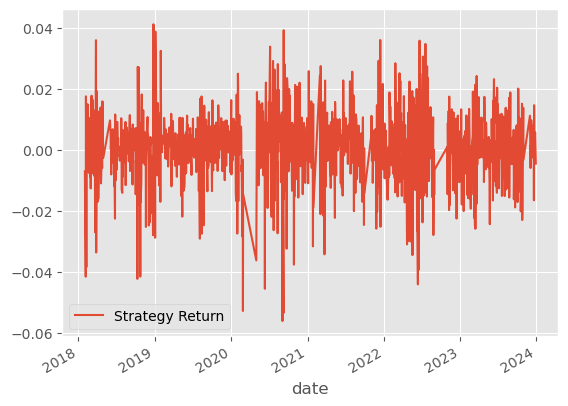

In [141]:
portfolio_df.plot()

A workaround for that is to assign equal weights for our portfolio whenever the solver is unable to determine the max sharpe ratio weights

In [145]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:
    
        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                       lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
            
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T

        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                        .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                               left_index=True,
                               right_index=True)\
                        .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
        
    except Exception as e:
        print(e)
        
portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Optimization failed for 2018-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2023-11-01, Continuing with Equal-Weights
'return'


Strategy Return
date                       
2018-02-01        -0.007097
2018-02-02        -0.017952
2018-02-05        -0.041640
2018-02-06         0.017543
2018-02-07         0.001828
...                     ...
2023-12-22         0.002407
2023-12-26         0.005684
2023-12-27         0.002800
2023-12-28        -0.000932
2023-12-29        -0.004532

[1488 rows x 1 columns]

In [142]:
# pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
#              index=optimization_df.columns.tolist(),
#              columns=pd.Series(0)).T

ABT       ACN       AMD       AMT      AVGO       AXP        BA  \
0  0.029412  0.029412  0.029412  0.029412  0.029412  0.029412  0.029412   

        BAC      BKNG       BLK  ...       MAR       MCD       MMM        MS  \
0  0.029412  0.029412  0.029412  ...  0.029412  0.029412  0.029412  0.029412   

       QCOM       RCL       SHW       TGT      TMUS       UNP  
0  0.029412  0.029412  0.029412  0.029412  0.029412  0.029412  

[1 rows x 34 columns]

<Axes: xlabel='date'>

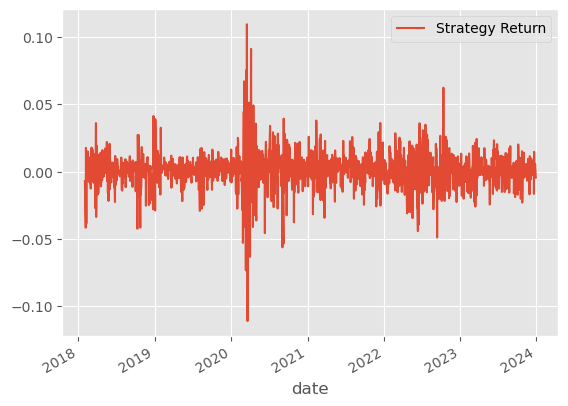

In [146]:
portfolio_df.plot()

# 8. Visualize Portfolio returns and compare to SP500 returns

In [147]:
# Download the returns for SP500 so we can compare against it

spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today())

spy

[*********************100%%**********************]  1 of 1 completed


Open        High         Low       Close   Adj Close  \
Date                                                                     
2015-01-02  206.380005  206.880005  204.179993  205.429993  174.806778   
2015-01-05  204.169998  204.369995  201.350006  201.720001  171.649826   
2015-01-06  202.089996  202.720001  198.860001  199.820007  170.033035   
2015-01-07  201.419998  202.720001  200.880005  202.309998  172.151901   
2015-01-08  204.009995  206.160004  203.990005  205.899994  175.206696   
...                ...         ...         ...         ...         ...   
2024-01-04  468.299988  470.959991  467.049988  467.279999  467.279999   
2024-01-05  467.489990  470.440002  466.429993  467.920013  467.920013   
2024-01-08  468.429993  474.750000  468.299988  474.600006  474.600006   
2024-01-09  471.869995  474.929993  471.350006  473.880005  473.880005   
2024-01-10  474.160004  477.450012  473.869995  476.559998  476.559998   

               Volume  
Date                   
2015-01-02  121465900  
2015-01-05  169632600  
2015-01-06  209151400  
2015-01-07  125346700  
2015-01-08  147217800  
...               ...  
2024-01-04   84232200  
2024-01-05   86060800  
2024-01-08   74879100  
2024-01-09   65931400  
2024-01-10   67310600  

[2271 rows x 6 columns]

In [150]:
spy_ret = np.log(spy[['Adj Close']]).diff().dropna()

spy_ret

Adj Close
Date                 
2015-01-05  -0.018225
2015-01-06  -0.009464
2015-01-07   0.012384
2015-01-08   0.017589
2015-01-09  -0.008046
...               ...
2024-01-04  -0.003226
2024-01-05   0.001369
2024-01-08   0.014175
2024-01-09  -0.001518
2024-01-10   0.005639

[2270 rows x 1 columns]

In [151]:
spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

spy_ret

SPY Buy&Hold
Date                    
2015-01-05     -0.018225
2015-01-06     -0.009464
2015-01-07      0.012384
2015-01-08      0.017589
2015-01-09     -0.008046
...                  ...
2024-01-04     -0.003226
2024-01-05      0.001369
2024-01-08      0.014175
2024-01-09     -0.001518
2024-01-10      0.005639

[2270 rows x 1 columns]

In [152]:
portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

Strategy Return  SPY Buy&Hold
2018-02-01        -0.007097     -0.001136
2018-02-02        -0.017952     -0.022010
2018-02-05        -0.041640     -0.042722
2018-02-06         0.017543      0.019511
2018-02-07         0.001828     -0.005440
...                     ...           ...
2023-12-22         0.002407      0.002008
2023-12-26         0.005684      0.004214
2023-12-27         0.002800      0.001806
2023-12-28        -0.000932      0.000378
2023-12-29        -0.004532     -0.002899

[1488 rows x 2 columns]

In [156]:
plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return

Strategy Return  SPY Buy&Hold
2018-02-01        -0.007097     -0.001136
2018-02-02        -0.024921     -0.023121
2018-02-05        -0.065524     -0.064856
2018-02-06        -0.049130     -0.046610
2018-02-07        -0.047392     -0.051796
...                     ...           ...
2023-12-22         1.230967      0.637959
2023-12-26         1.243648      0.644861
2023-12-27         1.249931      0.647832
2023-12-28         1.247834      0.648454
2023-12-29         1.237646      0.643675

[1488 rows x 2 columns]

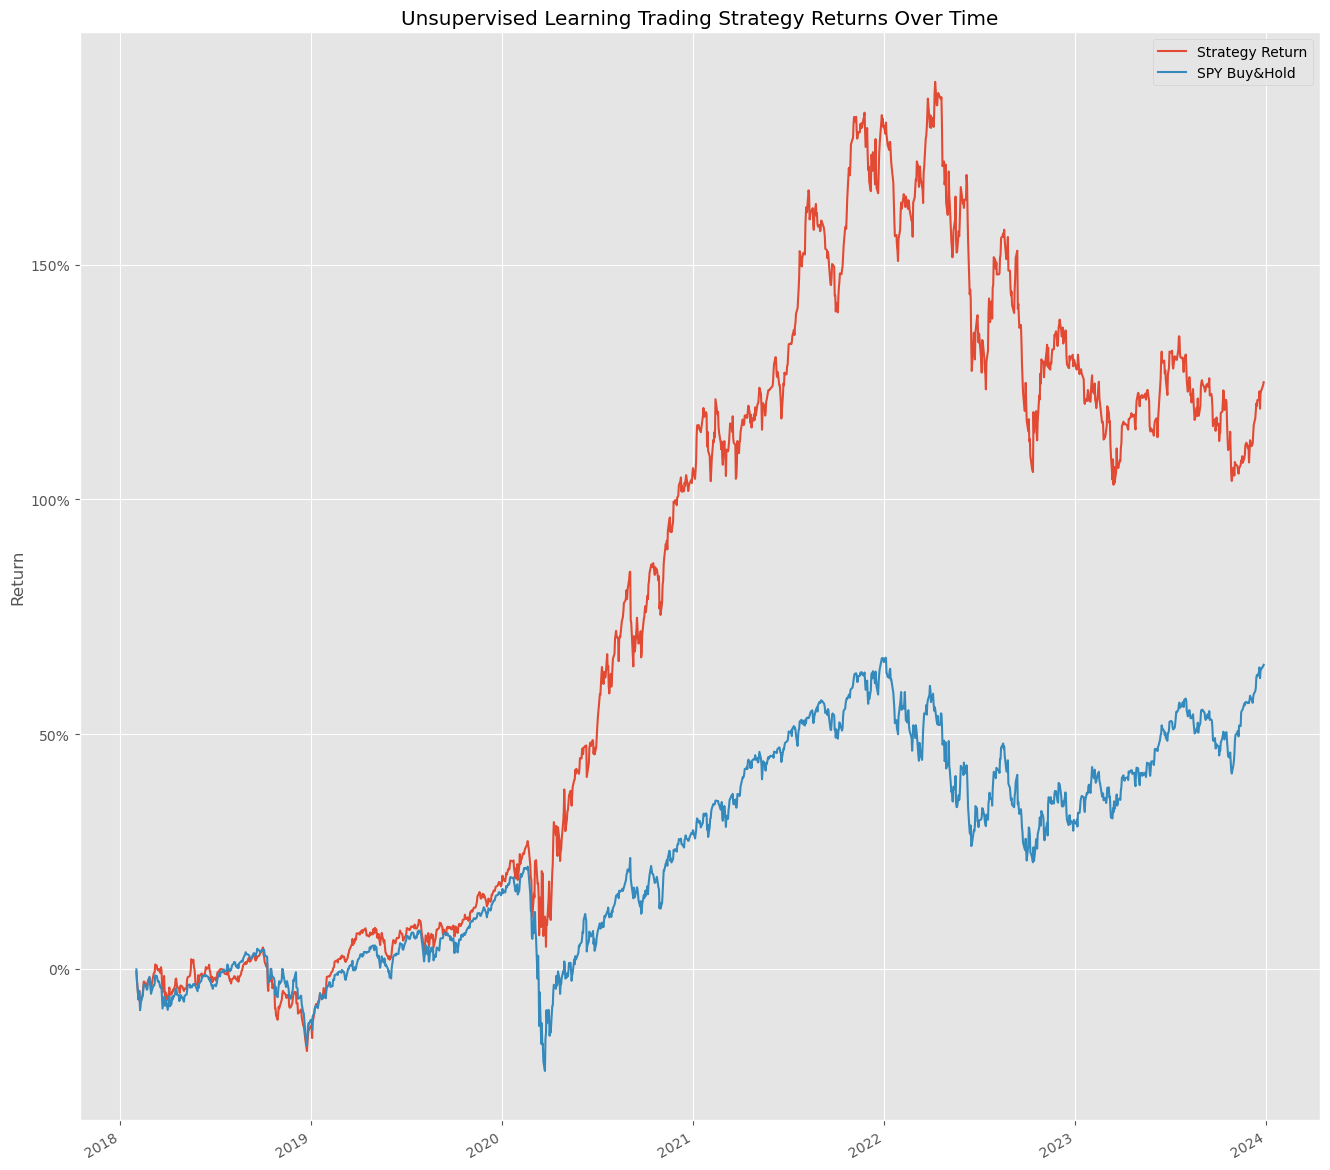

In [158]:
import matplotlib.ticker as mtick

portfolio_cumulative_return[:'2023-12-27'].plot(figsize=(16,16))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()